# NBA Data Exploration and Predictive Modeling

By: Logan Kerr, Eric Lu, Jeffrey Wang, Annie Yang


### Overview and Motivation
 
The movie Moneyball helped raise public awareness of sabermetrics, which uses mathematical and statistical analysis of baseball records to predict future game outcomes. That said, sabermetrics is only one of many methodologies for applying statistics to sports– APBRmetrics, the basketball equivalent of sabermetrics, has proved to be a robust framework for predicting player and team stats. As die-hard NBA fans, our team was interested in seeing how effective the APBRmetrics were against simpler, more "brute force" metrics. In addition, we were interested in seeing how accurate models can be in predicting basketball games, which are notoriously volatile due to the close score margins. 
 
Our team has applied APBRmetrics and simple scoring metrics to form various models for predicting game outcomes. Applying these metrics to historical game and player data from the past few years, we predicted and visualized the NBA Playoffs, verifying our results against the actual playoff outcome. We also generated playoff brackets for the 2013-2014 season (henceworth referred to as the 2014 season; 2012-2013 season will be referred to as the 2013 season, and so on).

### Related Works and References

http://www.sonicscentral.com/statsite.html (GO SONICS!).

Basketball on Paper by Dean Oliver

http://www.basketballprospectus.com/

All data were pulled from: http://www.basketball-reference.com/ 

### Initial Questions

What are the factors (scores per game, assists, turnovers, etc.) that are most predictive of the outcome of a game?

How well do well-known APBRmetrics stack up against simpler models that only examine 1-2 factors?

How often do team rankings change and how drastically do they change from year to year? Are there any sudden changes (i.e. dropping from first seed to last seed)? If so, can our models capture these unexpected changes? If not, what are some factors that could be causing these changes?

What do the playoff brackets look like for the 2013-2014 season?

### Outline of the Notebook

1. Data Scraping: 2008-2014
    1. Final Results of Regular Games
    2. Individual Player Data
    
2. Data Exploration

3. Simple Model: Frequentist Approach
    1. Baseline Score Model
    2. Adjustments to Score Model: Changing the Starting Lineup
    3. Adjustments to Score Model: Taking into consideration teams' historical win/loss margins
    4. Adjustments to the Score Model: Taking into consideration of player interaction (assists, turnovers, offensive rebounds)

4. APBRmetric Model: Bayasian Approach
    1. Offensive Rating Model
    2. Adjustment to Offensive Rating Model: Accounting for Assists
5. Game Scores Model
    1. Adjustment to Offensive Rating Model: Accounting for teamwork, offense, and defense using Game Score
    2. Visualizing team ranking from 2009-2013
    
5. Bracket Building for 2014
    1. Building the seeds
    2. Simulating the playoffs (**NOTE: Due to complications with bokeh, visualization code is saved in a separate file. Only screenshots will be shown here**)

In [225]:
from fnmatch import fnmatch
from matplotlib import rcParams
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import requests
import html5lib
from bs4 import BeautifulSoup
import csv
from datetime import datetime
import scipy.stats as stats
import sklearn.cross_validation as cv
from collections import defaultdict 
import datetime, time
from random import choice
import operator
from IPython.display import Image
#import pattern (removed as still not compatible with Python3)

import warnings
warnings.filterwarnings("ignore")

#set matplotlib global
plt.rcParams['figure.figsize'] = (10.0, 10.0)

%matplotlib inline

team_acronym = {'Atlanta Hawks': 'ATL',
'Brooklyn Nets': 'BKN',
'New Jersey Nets': 'BKN',
'Boston Celtics': 'BOS',
'Charlotte Bobcats': 'CHA',
'Chicago Bulls': 'CHI',
'Cleveland Cavaliers': 'CLE',
'Dallas Mavericks': 'DAL',
'Denver Nuggets': 'DEN',
'Detroit Pistons': 'DET',
'Golden State Warriors': 'GSW',
'Houston Rockets': 'HOU',
'Indiana Pacers': 'IND',
'Los Angeles Clippers': 'LAC',
'Los Angeles Lakers': 'LAL',
'Memphis Grizzlies': 'MEM',
'Miami Heat': 'MIA',
'Milwaukee Bucks': 'MIL',
'Minnesota Timberwolves': 'MIN',
'New Orleans Hornets': 'NOH',
'New Orleans Pelicans': 'NOH',
'New York Knicks': 'NYK',
'Oklahoma City Thunder': 'OKC',
"Seattle SuperSonics": "OKC",
'Orlando Magic': 'ORL',
'Philadelphia 76ers': 'PHI',
'Phoenix Suns': 'PHX',
'Portland Trail Blazers': 'POR',
'Sacramento Kings': 'SAC',
'San Antonio Spurs': 'SAS',
'Toronto Raptors': 'TOR',
'Utah Jazz': 'UTA',
'Washington Wizards': 'WAS'}

team_names = dict(zip(team_acronym.values(), team_acronym.keys()))

NBA_teams= ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 
            'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 
            'IND', 'LAC','LAL','MEM', 'MIA', 'MIL', 
            'MIN', 'NOH', 'NYK', 'OKC', 'ORL', 
            'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

NBA_divisions= {"Atlantic": ['BOS','BKN','PHI','NYK','TOR'], "Central":['CHI','CLE','DET','IND','MIL'] , 
                "SE":['ATL','CHA','MIA','ORL','WAS'], "NW":['DEN','MIN','OKC','POR','UTA'], "Pacific":['GSW','LAC','LAL','PHX','SAC'], 
                "SW":['DAL','HOU','MEM','NOH','SAS']}

NBA_conferences = {"East": ["Atlantic", "Central", "SE"], 
                   "West": ["NW", "Pacific", "SW"] }

NBA_conferencesT = {"East": ['BOS','BKN','PHI','NYK','TOR','CHI','CLE','DET','IND','MIL', 'ATL','CHA','MIA','ORL','WAS'],
                   "West": ['DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHX','SAC','DAL','HOU','MEM','NOH','SAS']}


# Data Scraping

Our models will be based on both individual player statistics per game from 2008-2014 and on the final results of regular season games from basketball-reference.com. The following code are general functions that can retrieve and format the HTML tables from basketball-reference.com.
The code turns the HTML table into BeautifulSoup objects, then reconstructed the table into a pandas DataFrame, and finally wrote the table into a csv file.

In [62]:
'''grab table header
input: html table (beautifulsoup format), string to filter by id
output: array of data table
'''
def makeheader(head):
    #find all "th" tags
    head_names = []
    table_head = head.find('thead')
    
    for x in table_head.findAll('th'):
        #grab the text within the tags; "N" if empty tag
        header = x.find(text=True)
        if header == None:
            header = "N"
        head_names.append(header) 
    return head_names

'''turn html table into 2D array
input: html table (beautifulsoup format), string to filter by id
output: 2D array of data table
'''
def maketable(table, id_string=None):
    data = []
    
    #retrieve all rows. filter by id if necessary
    if id_string==None:
        allrows = table.findAll('tr')
    else:
        allrows = table.findAll('tr', id=lambda x: x and x.startswith(id_string))
    
    for row in allrows:
        cells = []
        #grab each cell, append data to row variable
        allcols = row.findAll('td')
        for col in allcols:
            cells.append(col.find(text=True))
        #append row variable to data matrix
        data.append(cells)
    
    return data

Let us first retrieve final game results on a yearly basis and write it to a csv file.

Our code scrapes pages such as http://www.basketball-reference.com/leagues/NBA_2014_games.html for each year between 2008 and 2014.

In [63]:
'''retrieve schedule results for individual player statistics
input: string of the year that a season ends. For example, for the 2012-2013 season, the input should be "2013"
output: None, function writes directly to a csv file
'''
def game_finalscores(date):
    
    #retrieve html of site
    url = "http://www.basketball-reference.com/leagues/NBA_"+date+"_games.html"
    site= requests.get(url).text
    soup = BeautifulSoup(site, 'html.parser') 
    
    #retrieve table and transform into DataFrame
    table = soup.find('table', {'id': 'games'})
    table_head = makeheader(table)
    table_data = maketable(table)    
    table_mod = pd.DataFrame(table_data, columns=table_head)
    
    #remove unneeded columns and empty row
    del table_mod["N"]
    del table_mod["Notes"]
    
    #remove empty columns
    table_mod = table_mod.dropna(how="all")
    
    #apply the team acronyms
    table_mod["Visitor/Neutral"] = table_mod["Visitor/Neutral"].applymap(lambda x: team_acronym[x])
    table_mod["Home/Neutral"] = table_mod["Home/Neutral"].applymap(lambda x: team_acronym[x])
    
    #write to csv file
    filename = "finalscore_"+date+".csv"
    table_mod.to_csv(filename, index=False)
    
    print("Done")

In [64]:
%%capture
'''The code below retrieves the data for 2008-2014. This has been commented out as the csv files have already been made
year = ["2014","2013", "2012", "2011", "2010", "2009", "2008"]
for x in year:
    gamescores = game_finalscores(x)'''

Now, let us retrieve individual player data per game on a yearly basis from 2008-2014.

Our code starts with the page: http://www.basketball-reference.com/players/ . From this page, we scrape the URL suffixes that reference to pages containing links to the pages for individual players whose last name start with the same letter. For example, if we wanted to find all players whose last name start with "A", we would scrape the previously mentioned page to find the URL suffix "players/a/". We take this suffix and construct the URL string http://www.basketball-reference.com/players/a/ to access the page that contains links to the pages of individual players whose last name start with "A".

Then, the player directory page, we scrape for the URL construct of each individual players' page. For example, Alaa Abdelnaby's personal player page has the URL construct "/players/a/abdelal01.html". We scrape this information and use it to construct the URL string http://www.basketball-reference.com/players/a/abdelal01.html

We will ONLY look at currently active players, which are bolded in the player dictionary page, mainly due to performance issues.

In [65]:
'''scrape the "All Players" page to retrieve URLs of pages with a list of URLS of players whose last names start with the name letter
input: URL of the "All Players" page
returns: list of ending URLS for players by last name
'''
#match function to only grab URL with players' last names
def is_name(l):  
    pattern = '*players/?/'
    return fnmatch(l, pattern)

def find_nameurl(url):
    
    #retrieve the html
    dom = web.Element(requests.get(url).text)
    
    #retrieve all links
    links = [a.attributes.get('href', '') for a in dom.by_tag('a')] 
    #filter for letters of last names
    links = [x for x in links if is_name(x)]
    
    #remove duplicate links
    return list(set(links))

'''scrape the page to retrieve URLs of pages of players 
input: URL of the page with all players' URL listed
returns: list of ending URLS for players by last name
'''

#match function to only retrieve links to players' stats pages
def is_player(l):  
    pattern = '*players/?/*.html'
    return fnmatch(l, pattern)

def find_playerurl(suffix):
    #retrieve html
    url = "http://www.basketball-reference.com"+suffix
    dom = web.Element(requests.get(url).text)
    
    #retrieve active players (whose names are bolded)
    links = []
    for link in dom.by_tag('strong'):
        for a in link.by_tag('a'):
            links.append(a.attributes.get('href', ''))

    links = [x for x in links if is_player(x)]
    
    return list(set(links))
 

In [66]:
'''retrieves all 2014 active players' URL
input: none
returns: list of url suffix for all players
'''
def retrieve_playerdata():
    name_url = find_nameurl("http://www.basketball-reference.com/players/")
    player_url = []
    
    #grab URL suffixes
    for x in name_url:
        player_url.extend(find_playerurl(x))
        
    return player_url 

In [67]:
'''writes players game data into csv file
input: unique url segment of a player, year
output: None, write to csv file for performance issues
'''
def get_table(player_url, date):

    #retrieve table headers
    url = "http://www.basketball-reference.com/players/f/foyera01/gamelog/"+date+"/"
    site= requests.get(url).text
    soup = BeautifulSoup(site, 'html.parser') 
    table = soup.find('table', {'id': 'pgl_basic'})
    col_names = makeheader(table)
    col_names.append("name")

    #write table headers
    filename = "playerdata_"+date+".csv"
    with open(filename,'wb') as fp:
        writer = csv.writer(fp, delimiter=',')
        writer.writerow(col_names)
        
        for y in player_url:
            #trim player_url
            y = y[0:-5]
            
            #grab html
            url = "http://www.basketball-reference.com"+str(y)+"/gamelog/"+date+"/"
            site= requests.get(url).text
            soup = BeautifulSoup(site, 'html.parser')
            
            #find name of player
            children = soup.find('p', {'class': 'margin_top'}).findChildren()
            name = children[0].text
            
            #grab data table html
            table = soup.find('table', {'id': 'pgl_basic'})
            if table == None:
                continue
            
            #retrieve 2D array of table
            table_mod = maketable(table, 'pgl')
            
            #write to csv
            table_mod = np.asarray([x + [name] for x in table_mod])
            np.savetxt(fp, table_mod, delimiter=",", fmt="%s")
            
    fp.close()
    
    print("Done")


In [68]:
%%capture
'''The code below retrieves the data for 2008-2014. This has been commented out as the csv files have already been made
urls = retrieve_playerdata()
year = ["2014", "2013", "2012", "2011", "2010", "2009", "2008"]
for x in year:
    playerdata_totals = get_table(urls, x)'''

In [69]:
%%capture
'''Formatting of data files to account for changes in team names

#combine all players_data files and change team acronyms for consistency
players_data = pd.read_csv("playerdata_2013.csv", delimiter=',')

players_data = players_data.append(pd.read_csv("playerdata_2012.csv", delimiter=','))
players_data = players_data.append(pd.read_csv("playerdata_2011.csv", delimiter=','))
players_data = players_data.append(pd.read_csv("playerdata_2010.csv", delimiter=','))
players_data = players_data.append(pd.read_csv("playerdata_2009.csv", delimiter=','))
players_data = players_data.append(pd.read_csv("playerdata_2008.csv", delimiter=','))

players_data["Tm"]= players_data["Tm"].map(lambda x: "BKN" if x=="NJN" else x)
players_data["Tm"]= players_data["Tm"].map(lambda x: "BKN" if x=="BRK" else x)
players_data["Tm"]= players_data["Tm"].map(lambda x: "OKC" if x=="SEA" else x)
players_data["Tm"]= players_data["Tm"].map(lambda x: "PHX" if x=="PHO" else x)

players_data.to_csv("playersdata_all.csv", index=False)

#combine all finalscore files and change team acronyms for consistency
allscores = pd.read_csv("finalscore_2013.csv", delimiter=',')
allscores = allscores.append(pd.read_csv("finalscore_2012.csv", delimiter=','))
allscores = allscores.append(pd.read_csv("finalscore_2011.csv", delimiter=','))
allscores = allscores.append(pd.read_csv("finalscore_2010.csv", delimiter=','))
allscores = allscores.append(pd.read_csv("finalscore_2009.csv", delimiter=','))
allscores = allscores.append(pd.read_csv("finalscore_2008.csv", delimiter=','))

allscores["Visitor/Neutral"]= allscores["Visitor/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
allscores["Visitor/Neutral"]= allscores["Visitor/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
allscores["Visitor/Neutral"]= allscores["Visitor/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
allscores["Visitor/Neutral"]= allscores["Visitor/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

allscores["Home/Neutral"]= allscores["Home/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
allscores["Home/Neutral"]= allscores["Home/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
allscores["Home/Neutral"]= allscores["Home/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
allscores["Home/Neutral"]= allscores["Home/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

allscores.to_csv("finalscore_all.csv", index=False)

scores_2014 = pd.read_csv("finalscore_2014.csv", delimiter=",")
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "NOH" if x=="NOP" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "NOH" if x=="NOP" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

scores_2014.to_csv("finalscore_2014.csv", index=False)


players_2014 = pd.read_csv("playerdata_2014.csv", delimiter=',')
players_2014["Tm"]= players_2014["Tm"].map(lambda x: "NOH" if x=="NOP" else x)
players_2014["Tm"]= players_2014["Tm"].map(lambda x: "BKN" if x=="NJN" else x)
players_2014["Tm"]= players_2014["Tm"].map(lambda x: "BKN" if x=="BRK" else x)
players_2014["Tm"]= players_2014["Tm"].map(lambda x: "OKC" if x=="SEA" else x)
players_2014["Tm"]= players_2014["Tm"].map(lambda x: "PHX" if x=="PHO" else x)

players_2014.to_csv("playerdata_2014.csv", index=False)


scores_2014 = pd.read_csv("finalscore_2014120813.csv", delimiter=",")
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "NOH" if x=="NOP" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "NOH" if x=="NOP" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
scores_2014["Visitor/Neutral"]= scores_2014["Visitor/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "BKN" if x=="NJN" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "BKN" if x=="BRK" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "OKC" if x=="SEA" else x)
scores_2014["Home/Neutral"]= scores_2014["Home/Neutral"].map(lambda x: "PHX" if x=="PHO" else x)

scores_2014.to_csv("finalscore_2014120813.csv", index=False)

'''

# Data Exploration

In this section, we will take a look at some interesting game metrics such as average points per game and three point shots (also known as field goals).

In [70]:
#let us read in the csv files we have just made
players_data = pd.read_csv("playersdata_all.csv", delimiter=',', low_memory=False)
gamescores = pd.read_csv("finalscore_2013.csv", delimiter=',')
allscores = pd.read_csv("finalscore_all.csv", delimiter=',')

#record the 2014 schedule
schedule_2014 = pd.read_csv("finalscore_2014.csv", delimiter=",")

#record only the games played so far in 2014
scores_2014 = schedule_2014.dropna(how='any')

#player data so far for 2014
players_2014 = pd.read_csv("playerdata_2014.csv", delimiter=',')

#append 2014 data to the 2008-2013 data
players_data_08_14 = players_data.append(players_2014)

#append 2014 data to the 2008-2013 final results
allscores_2014 = allscores.append(scores_2014)

print(players_data.info())
print (gamescores.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113108 entries, 0 to 113107
Data columns (total 31 columns):
Rk      113108 non-null int64
G       113108 non-null int64
Date    113108 non-null object
Age     113108 non-null object
Tm      113108 non-null object
N       113108 non-null object
Opp     113108 non-null object
N.1     113108 non-null object
GS      113108 non-null int64
MP      113108 non-null object
FG      113108 non-null int64
FGA     113108 non-null int64
FG%     113108 non-null object
3P      113108 non-null int64
3PA     113108 non-null int64
3P%     113108 non-null object
FT      113108 non-null int64
FTA     113108 non-null int64
FT%     113108 non-null object
ORB     113108 non-null int64
DRB     113108 non-null int64
TRB     113108 non-null int64
AST     113108 non-null int64
STL     113108 non-null int64
BLK     113108 non-null int64
TOV     113108 non-null int64
PF      113108 non-null int64
PTS     113108 non-null int64
GmSc    113108 non-null float64
+/-    

We will take a look at last year's, 2012-2013 season, data. First, we will note the number of active players that season and the duration of the season. Second, we will look at the distribution of games played by players. Third, we will look at the total and average point scored by players. Fourth, we will look at the average number of 3 point throws made by players and the correlation between average 3-point and average points scored. Fifth, we looked examined the concept of the "3 and D" player. Finally, we looked at the performance of the top 15 players in 2008 over time until the 2012-2013 season.

In [71]:
players_data_13 = pd.read_csv("playerdata_2013.csv", delimiter=',')

all_players = players_data_13.groupby("name").groups.keys()
print("Total Active Players: " + str(len(all_players)))

all_teams = players_data_13.groupby("Tm").groups.keys()
print("Total Active Teams: " + str(len(all_teams)))

all_dates = sorted(players_data_13.groupby("Date").groups.keys())
print("First date of season: " + all_dates[0])
print("Last date of season: " + all_dates[-1])

Total Active Players: 444
Total Active Teams: 30
First date of season: 2012-10-30
Last date of season: 2013-04-17


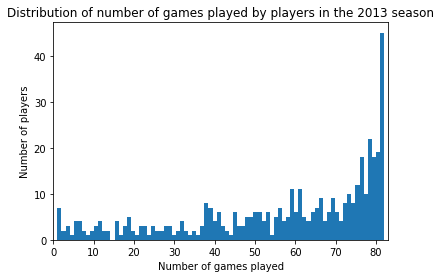

Number of players who played all 82 regular season games: 28


In [72]:
players_dict = players_data_13.groupby("name").groups
games_dict = {}

#count the number of games played per player
for player, games in players_dict.items():
    games_dict[player] = len(games)

#plot graph

plt.title("Distribution of number of games played by players in the 2013 season")
plt.xlim(0, 83)
plt.hist(games_dict.values(), bins=80)
plt.ylabel("Number of players")
plt.xlabel("Number of games played")
plt.show()
full_season_players = []
for player, games in players_dict.items():
    if len(games) > 81:
        full_season_players.append(player)
print("Number of players who played all 82 regular season games:", len(full_season_players))

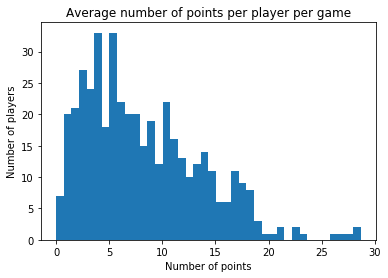

Top 10 players with the highest average number of points per game:
name
Aaron Jamal Brooks        7.094340
Aaron Jamal Crawford     16.513158
Aaron John Baynes         2.687500
Aaron Michael Gray        2.833333
Al Jefferson             17.833333
Al-Farouq Aminu           7.302632
Alan Jeffery Anderson    10.661538
Albert Harrington         5.100000
Alec Burks                7.046875
Aleksandar Pavlovic       2.641026
Name: PTS, dtype: float64


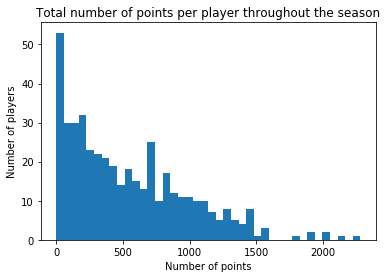

Top 10 scorers in the 2012-13 season and number of points:
name
Aaron Jamal Brooks        376
Aaron Jamal Crawford     1255
Aaron John Baynes          43
Aaron Michael Gray        119
Al Jefferson             1391
Al-Farouq Aminu           555
Alan Jeffery Anderson     693
Albert Harrington          51
Alec Burks                451
Aleksandar Pavlovic       103
Name: PTS, dtype: int64


In [73]:
#display average score per game per player
points = players_data_13["PTS"].groupby(players_data_13["name"]).mean()
plt.hist(points.values, bins=40)
plt.title("Average number of points per player per game")
plt.ylabel("Number of players")
plt.xlabel("Number of points")
plt.show()

print("Top 10 players with the highest average number of points per game:")
players = players_data_13["PTS"].groupby(players_data_13["name"]).mean().copy()
players.sort_values(ascending=False)
print(players[0:10])

#total number of points per player
points = players_data_13["PTS"].groupby(players_data_13["name"]).sum().copy()
plt.hist(points.values, bins=40)

plt.title("Total number of points per player throughout the season")
plt.ylabel("Number of players")
plt.xlabel("Number of points")
plt.show()
print("Top 10 scorers in the 2012-13 season and number of points:")
players = players_data_13["PTS"].groupby(players_data_13["name"]).sum()
players.sort_values(ascending=False)
print(players[0:10])

Surprising here is that there is a large difference between Stephen Curry and the next highest scorer, Monta Ellis. Curry scored 1786, and the next highest scorer, Ellis, has only 1577, a difference of 209 points. We can see that the top 7 scorers are a large segment above the rest of the players in the league - these top 7 players are viewed as the most "elite" players in the league - Durant, Bryant, James, Harden, Anthony, Westbrook, and Curry.

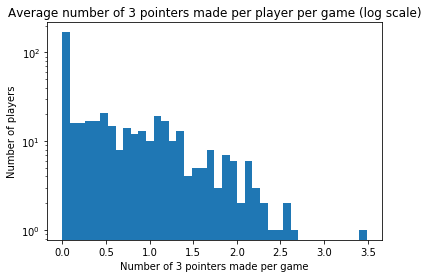

Top 5 3-point shooters in the 2012-13 season and the number of 3-pointers made:
name
Aaron Jamal Brooks       50
Aaron Jamal Crawford    149
Aaron John Baynes         0
Aaron Michael Gray        0
Al Jefferson              2
Name: 3P, dtype: int64


In [74]:
#calculate average number of 3 points made per player per game
points = players_data_13["3P"].groupby(players_data_13["name"]).mean()

plt.hist(points.values, bins=40, log=True)
plt.title("Average number of 3 pointers made per player per game (log scale)")
plt.ylabel("Number of players")
plt.xlabel("Number of 3 pointers made per game")
plt.show()

print("Top 5 3-point shooters in the 2012-13 season and the number of 3-pointers made:")
players = players_data_13["3P"].groupby(players_data_13["name"]).sum()
players.sort_values(ascending=False)
print(players[0:5])

What's the correlation between three point shooting and high scorers? Do high scorers in the NBA take many three pointers?

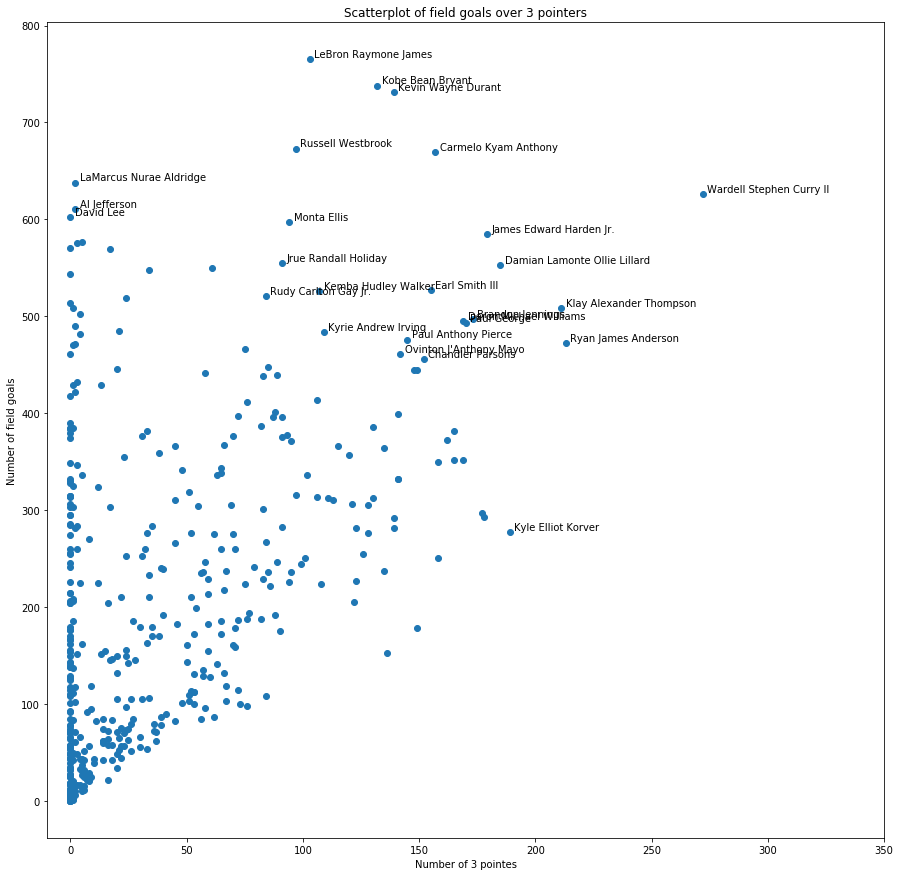

In [75]:
plt.figure(figsize=(15, 15))
three_point_shooting = players_data_13['3P'].groupby(players_data_13["name"]).sum()
field_goals = players_data_13['FG'].groupby(players_data_13["name"]).sum()
labels = []

#find three point shooting scores
for i, shots in enumerate(three_point_shooting):
    if ((shots > 80 and field_goals[i] > 450) or (field_goals[i] > 600) or (shots > 180)):
        labels.append((three_point_shooting.index[i], three_point_shooting[i], field_goals[i]))
plt.scatter(three_point_shooting, field_goals)

for label in labels:
    (name, x, y) = label
    plt.annotate(name, (x + 2, y + 2))
plt.ylabel("Number of field goals")
plt.xlabel("Number of 3 pointes")
plt.title("Scatterplot of field goals over 3 pointers")
plt.xlim(-10, 350)
plt.show()

We can see that the high scoring players from before leverage a good balance of field goals and 3 pointers. Stephen Curry is a huge outlier, shooting a high number of 3 pointers as well as a relatively high number of field goals. It's very interesting to look at outlying players like LaMarcus Aldridge and David Lee, who shoot a high number of shots from the paint, and Kyle Korver, who is known for his ability to shoot 3s. Super stars like Lebron James and Kobe Bryant, of course, shoot a high number of both types of shots.

A new trend in the NBA is the idea of the "3 and D" guy - a player who plays solid defense, and on offense clears out to the wing or the outside of the floor, thus spacing out the floor and allowing more offensively talented players to get into the paint. The 3 and D guy often shoots many threes but also has a high defensive rating when he's on the floor. To see a ranking of these players, we can examine the total number of 3 pointers made, and also the total numbers of steals as well as their +/- rating. The +/- rating is a measurement of the player's contribution when they are on the floor. Thus, a highly defensive player would make the intangible contribution to their team when they are on the floor. 

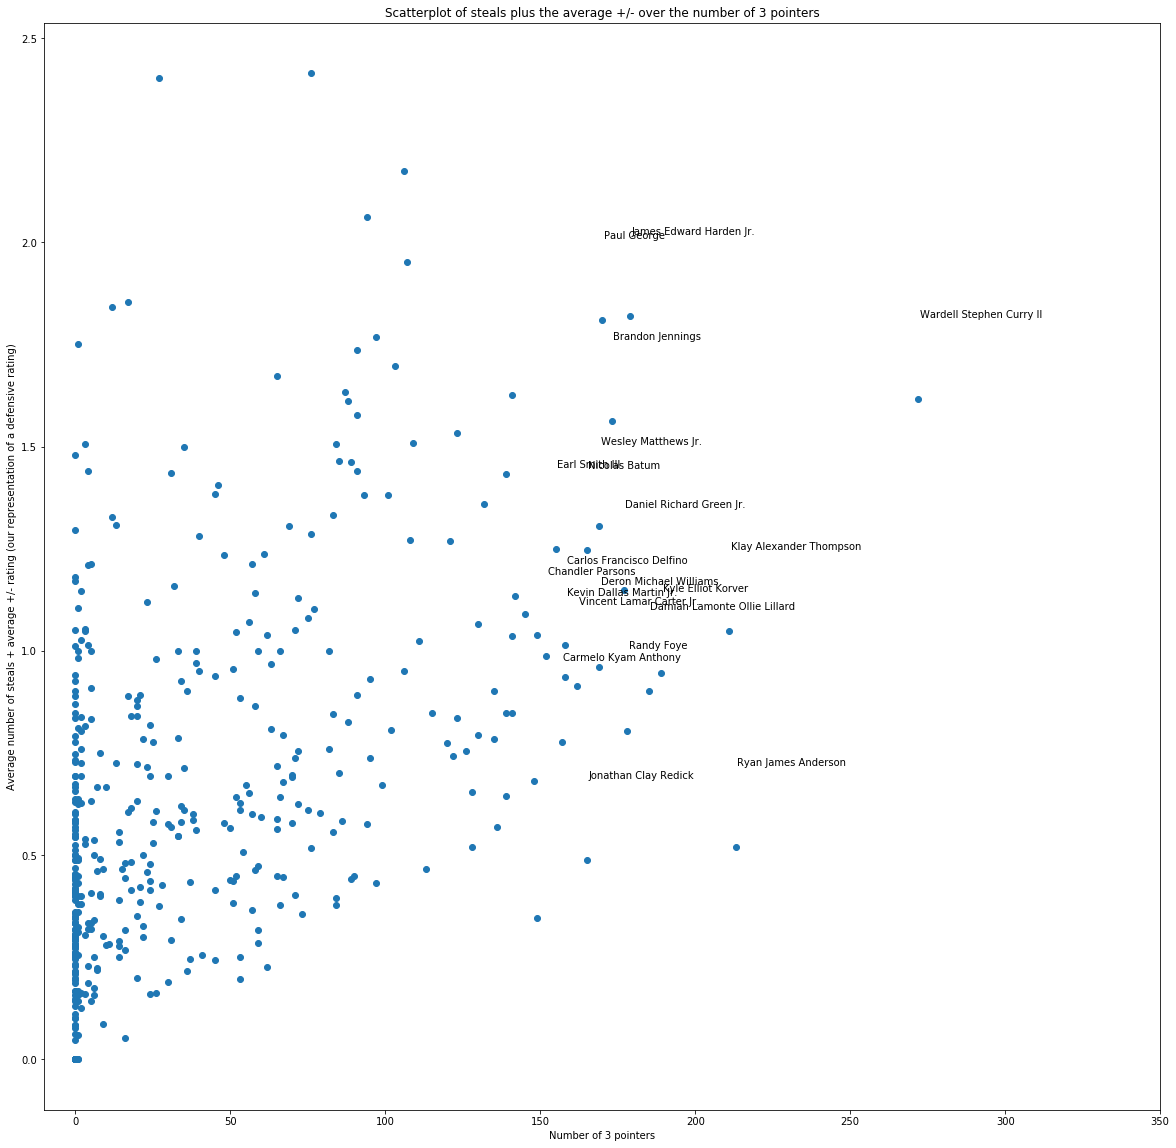

In [76]:
plt.figure(figsize=(20, 20))


#find scores, steals, and +/-
three_point_shooting = players_data_13['3P'].groupby(players_data_13["name"]).sum()
steals = players_data_13['STL'].groupby(players_data_13["name"]).mean()
plusminus = players_data_13['+/-'].groupby(players_data_13["name"])

plusminus2 = []

#calculate +/- adjusted metric
for values in plusminus:
    result = []
    for v in values[1:]:
        v.astype(str);
        if v is not None:
            result.append(0)
        else:
            v.astype(int)
            result.append(int(v))
    plusminus2.append(float(sum(result))/len(result))

#combine steals and +/-    
steals_and_plusminus = []
for i, s in enumerate(steals):
    steals_and_plusminus.append(s + plusminus2[i])

#grab player labels
labels = []
for i, shots in enumerate(three_point_shooting):
    if shots > 150 or steals_and_plusminus[i] > 8 or steals_and_plusminus[i] < -5:
        labels.append((three_point_shooting.index[i], three_point_shooting[i], steals_and_plusminus[i]))

#plot
plt.scatter(three_point_shooting, steals_and_plusminus)
for label in labels:
    (name, x, y) = label
    plt.annotate(name, (x + 0.5, y + 0.2))
plt.ylabel("Average number of steals + average +/- rating (our representation of a defensive rating)")
plt.xlabel("Number of 3 pointers")
plt.title("Scatterplot of steals plus the average +/- over the number of 3 pointers")
plt.xlim(-10, 350)
plt.show()

A very interesting analysis appears when we consider the three-point field goals alongside a personalized representation of defense from our available data. While superstars like James and Durant are still present, we see some interesting new names emerge. Namely, Kyle Korver, Danny Green, Earl Smith, Wesley Matthews, and JJ Redick are all somewhat known for their ability to play the "3-and-D" role, being shooters from the wing who play good defense. Another interesting insight here is that Kobe Bryant's name falls off the chart. This suggests that while Kobe is an extremely talented offenseive player, his contributions on defense are not particularly as valuable.

Another interesting exploration could be a look at the progression of the top 15 scorers of last season and see how their scoring in the league has changed over time. 

In [77]:
players_data_13 = pd.read_csv("playerdata_2013.csv", delimiter=',')
players_data_12 = pd.read_csv("playerdata_2012.csv", delimiter=',')
players_data_11 = pd.read_csv("playerdata_2011.csv", delimiter=',')
players_data_10 = pd.read_csv("playerdata_2010.csv", delimiter=',')
players_data_09 = pd.read_csv("playerdata_2009.csv", delimiter=',')
players_data_08 = pd.read_csv("playerdata_2008.csv", delimiter=',')

In [78]:
players12 = players_data_12["PTS"].groupby(players_data_12["name"]).sum().to_dict()
players11 = players_data_11["PTS"].groupby(players_data_11["name"]).sum().to_dict()
players10 = players_data_11["PTS"].groupby(players_data_10["name"]).sum().to_dict()
players09 = players_data_11["PTS"].groupby(players_data_09["name"]).sum().to_dict()
players08 = players_data_11["PTS"].groupby(players_data_08["name"]).sum().to_dict()

In [170]:
# First get the top 15 scorers who have played from the 08 until the 13 seasons.
players13 = players_data_13["PTS"].groupby(players_data_13["name"]).sum()
players13.sort_values(ascending=False)
players13.to_dict()
veterans = []
for i, points in enumerate(players13):
    name = players13.index[i]
    if name in players12 and name in players11 and name in players10 and name in players09 and name in players08:
        veterans.append(name)
    if (len(veterans) > 15):
        break
season13 = []
season12 = []
season11 = []
season10 = []
season09 = []
season08 = []
for name in veterans:
    season13.append(players13[name])
    season12.append(players12[name])
    season11.append(players11[name])
    season10.append(players10[name])
    season09.append(players09[name])
    season08.append(players08[name])
    
d = {'07-08': pd.Series(season08, index=veterans), 
     '08-09': pd.Series(season09, index=veterans), 
     '09-10': pd.Series(season10, index=veterans),
     '10-11': pd.Series(season11, index=veterans), 
     '11-12': pd.Series(season12, index=veterans), 
     '12-13': pd.Series(season13, index=veterans)}
df = pd.DataFrame(d)
print(df)

                            07-08  08-09  09-10  10-11  11-12  12-13
Aaron Jamal Crawford          967    781    708   1077    837   1255
Aaron Michael Gray            556    332    672    129    191    119
Al Jefferson                  394    341    944   1528   1170   1391
Albert Harrington             662   1090   1939    765    910     51
Aleksandar Pavlovic           416    814    743     76    120    103
Alfred Joel Horford           951    715    746   1178    136   1289
Amar'e Carsares Stoudemire    782    534    693   1971    823    413
Amir Jalla Johnson            696    450   1577    688    452    813
Anderson Franca Varejao       277    857    876    282    271    353
Andray Blatche                584    983    724   1076    221    843
Andre Lloyd Miller           1242    488    609   1029    639    786
Andre Tyler Iguodala          268   1510    636    945    771   1038
Andrea Bargnani               881    904    970   1414    603    443
Andrew Melvin Gooden          698 

Below we will set up the plot for parallel coordinates, which will allow us to look at the production of the above scoreers over the last few seasons.

In [190]:
"""
Function
--------
parallel_coordinates(df, style=None,fmt=None)

Plot parallel_coordinates plot of given DataFrame.

Parameters
----------
df : DataFrame 
    Line names should be in the index (not first row). The data (numerical only) for those lines should be in the body of the 
    DataFrame. The column names become the names of the y-axes. See cell below for example of properly formatted dataset. 
    Note that besides these minimal parameters, the function dynamic accommodates theoretically infinite many rows and columns.

(optional) style: Array
    Array of matplotlib color+line formatting combinations (such as 'r--' or 'k-.'). Default is automatic color/line cycle.
    
(optional) fmt: rcParams function
    rcParams function determining style of graph. Default is plt.xkcd().

See cell below for properly formatted dataset. 

Returns
-------
Plot parallel_coordinates plot of given DataFrame.
"""
import itertools as itertools
def parallel_coordinates(df, fig_size, font_size, style=None):
    
        
    rcParams['figure.figsize'] = (fig_size, fig_size)
    rcParams['figure.dpi'] = 150
    rcParams['lines.linewidth'] = 2
    rcParams['axes.grid'] = False
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = font_size
    rcParams['patch.edgecolor'] = 'none'

    # Convert dataframe to list of lists.
    data_sets = []
    for teamnumber, teamval in enumerate(df.index):
        foo = [x for x in df.iloc[teamnumber]]
        data_sets.append(foo)

    dims = len(data_sets[0])
    x    = range(dims)
    fig, axes = plt.subplots(1, dims-1, sharey=False)

    # Set color styles.
    if style is None:
        cyc = []
        style = []
        lines = ["-","--",":"]
        colors = ["b","g","r","c","m","y","k"]
        for linetype in lines:
            for colortype in colors:
                cyc.append(linetype + colortype)
        cyc = itertools.cycle(cyc)
        for i in range(len(data_sets)):
            style.append(next(cyc))

    # Calculate the limits on the data
    min_max_range = list()
    for m in zip(*data_sets):
        mn = min(m)
        mx = max(m)
        if mn == mx:
            mn -= 0.5
            mx = mn + 1.
        r  = float(mx - mn)
        min_max_range.append((mn, mx, r))

    # Normalize the data sets
    norm_data_sets = list()
    for ds in data_sets:
        nds = [(value - min_max_range[dimension][0]) / 
                min_max_range[dimension][2] 
                for dimension,value in enumerate(ds)]
        norm_data_sets.append(nds)
    data_sets = norm_data_sets

    # Plot the datasets on all the subplots
    for i, ax in enumerate(axes):
        for dsi, d in enumerate(data_sets):
            ax.plot(x, d, style[dsi], label=df.index[dsi])
        ax.set_xlim([x[i], x[i+1]])
        ax.set_xticklabels([df.columns[i],df.columns[len(axes)]]) 
        ax.xaxis.tick_top()
        ax.spines["top"].set_visible(False)

    # Set the x axis ticks 
    for dimension, (axx,xx) in enumerate(zip(axes, x[:-1])):
        axx.xaxis.set_major_locator(plt.FixedLocator([xx]))
        ticks = len(axx.get_yticklabels())
        labels = []
        step = min_max_range[dimension][2] / (ticks - 1)
        mn   = min_max_range[dimension][0]
        for i in range(ticks):
            v = mn + i*step
            labels.append('%4.2f' % v)
        axx.set_yticklabels(labels)

    # Move the final axis' ticks to the right-hand side
    axx = plt.twinx(axes[-1])
    dimension += 1
    axx.xaxis.set_major_locator(plt.FixedLocator([x[-2], x[-1]]))
    ticks = len(axx.get_yticklabels())
    step = min_max_range[dimension][2] / (ticks - 1)
    mn   = min_max_range[dimension][0]
    labels = ['%4.2f' % (mn + i*step) for i in range(ticks)]
    axx.set_yticklabels(labels)

    # Stack the subplots 
    plt.subplots_adjust(wspace=0)

    #added this to get the legend to work
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, ncol=dims-1,loc='upper center', bbox_to_anchor=(-1,-0.1))

    return plt

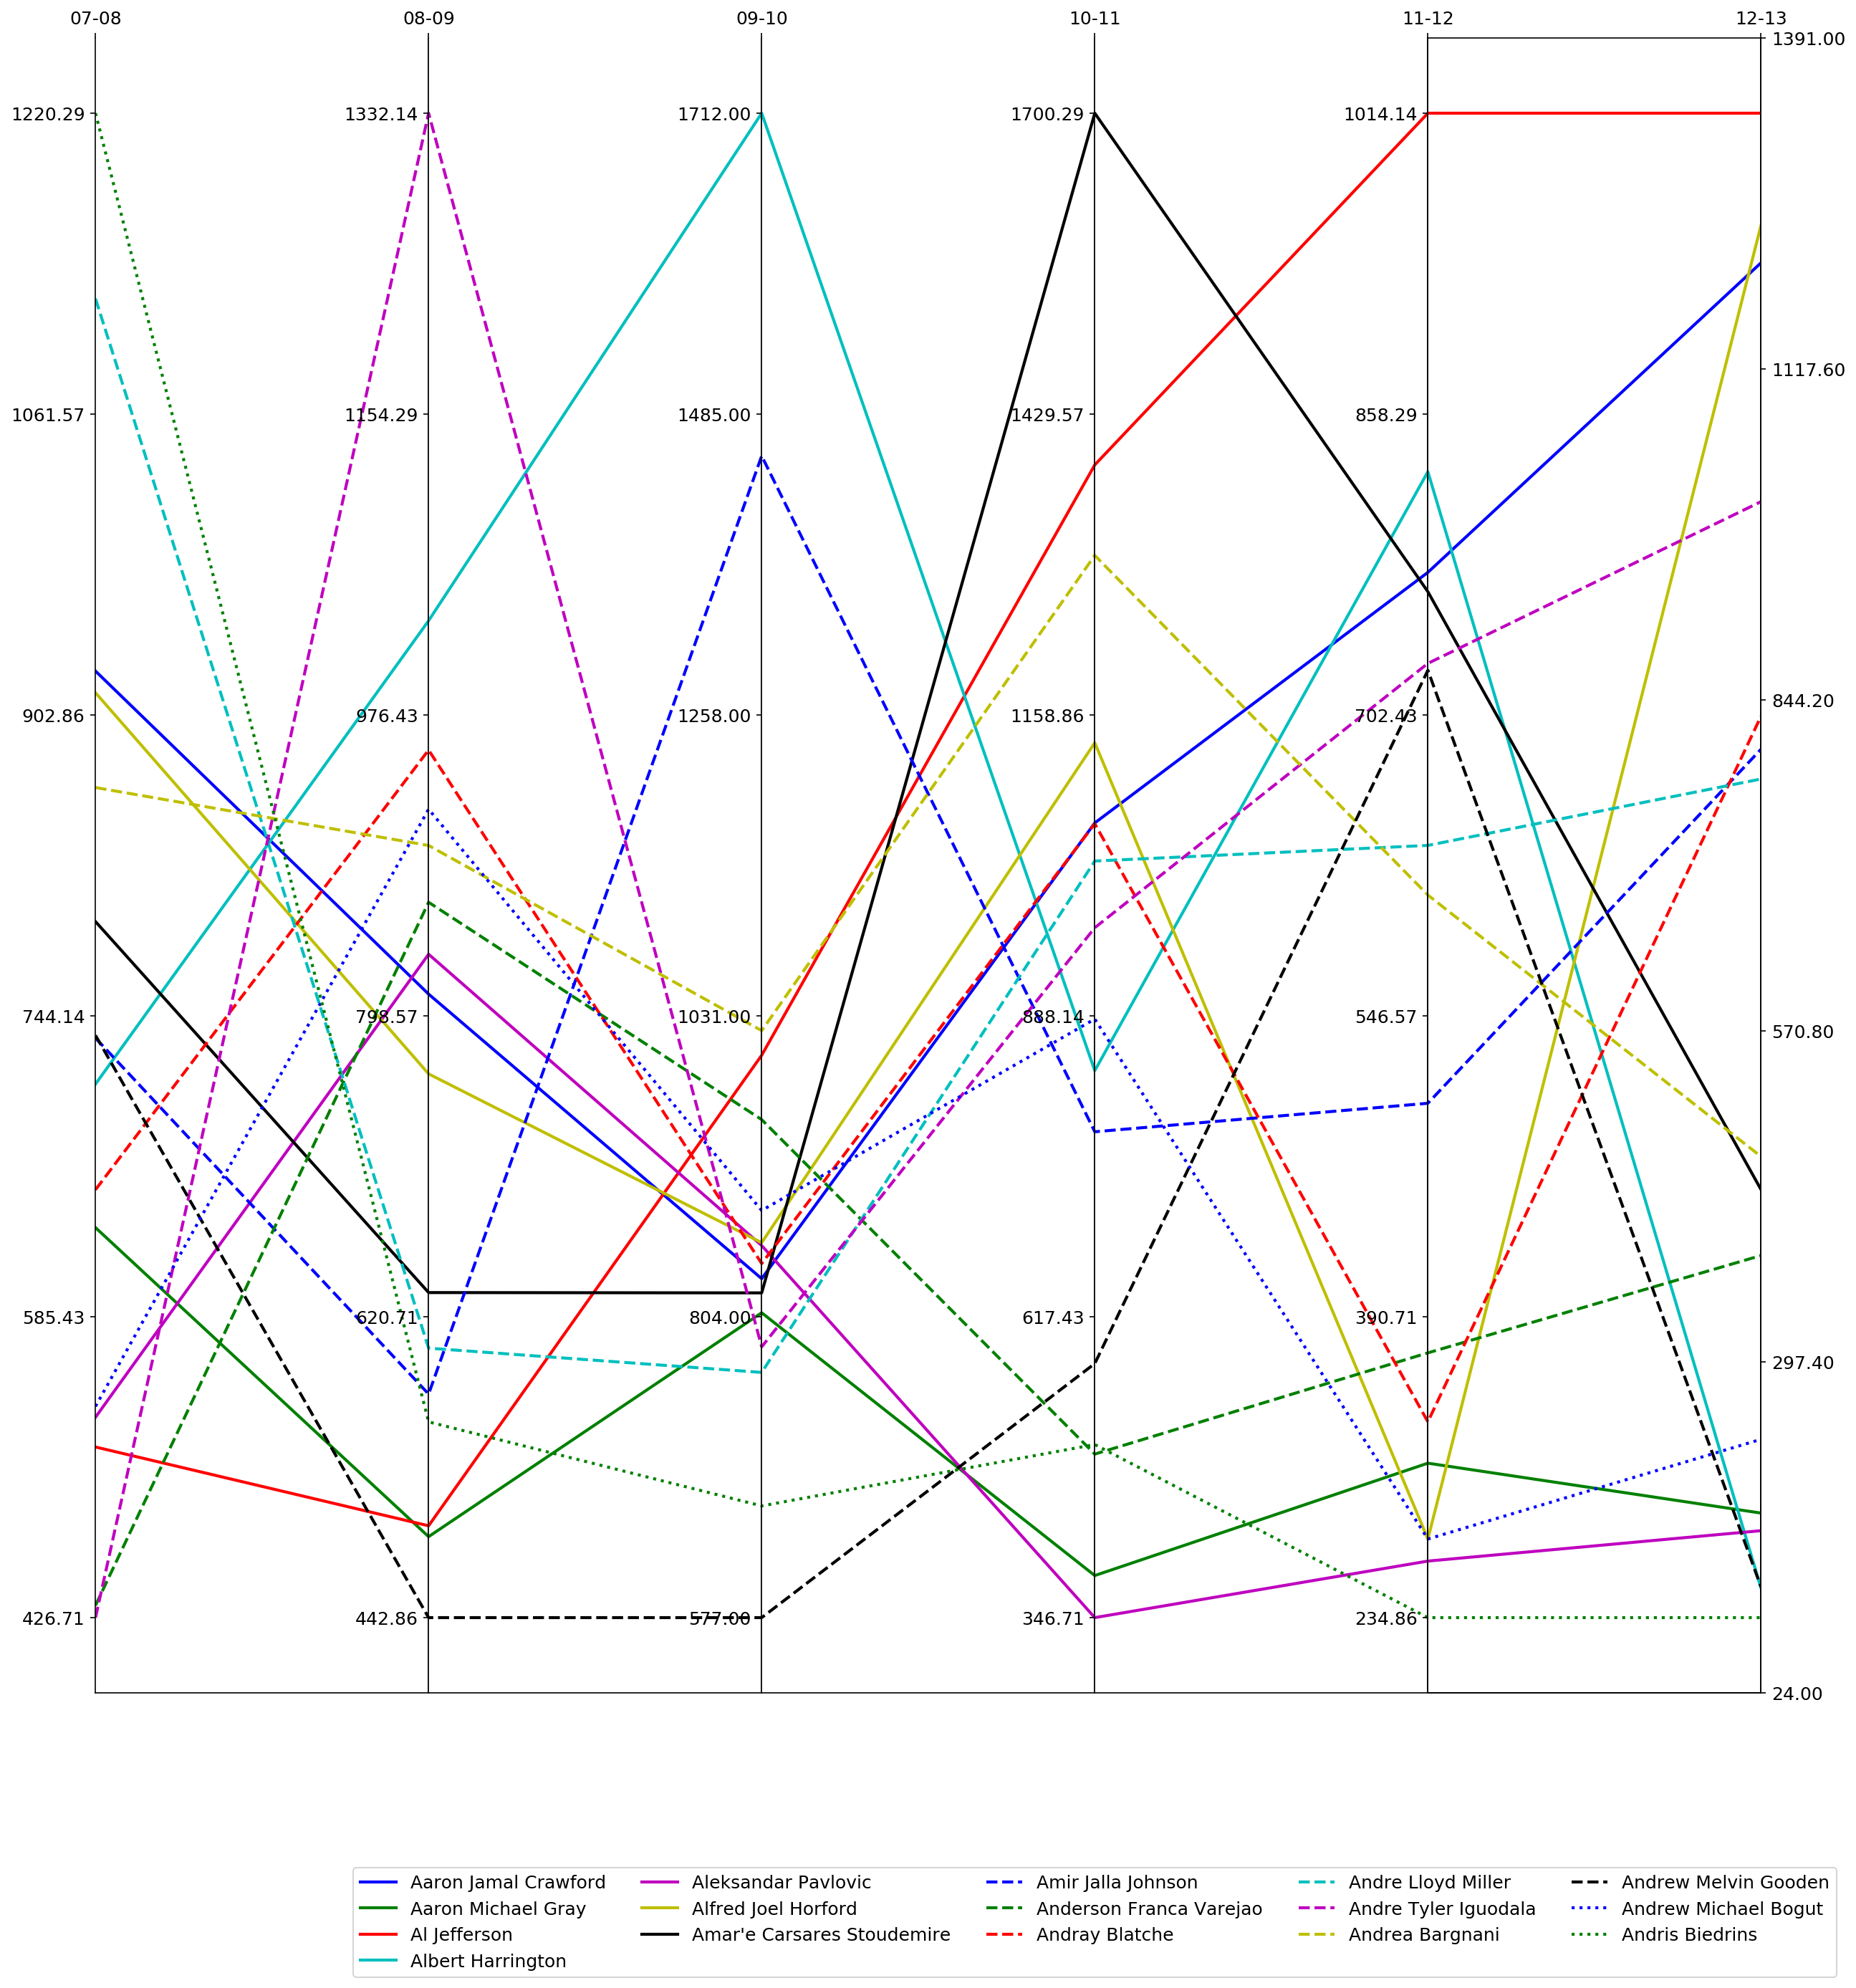

In [191]:
# Run graph.
parallel_coordinates(df, 20, 12).show()

Above we see the relative scoring power of the highest scoring players who have been playing in the league since 2007. We can see how players like Kevin Durant and Kobe Bryant have strongly increased their scoring prowess over time. Other players who used to be high scorers, like Deron Williams, have relatively declined over time.

# Frequentist Score-Based Model

In this section, we experimented with two frequentist methods of predicting a given team's probability of winning/losing a game. Win/Loss probabilities were calculated using the sum of each team's starting five players' historical points-per-game. 

For our first method, we fitted a statistical distribution onto the historical points-per-game data for individual players. Baseline predictions were made by sampling from the resulting fitted distributions. The second method involved creating a bootstrap sampling of our historical points-per-game data. In this case, our baseline was the average of a random sampling across the starting five players for each team.

 From these baseline predictions, we made adjustments to our prediction using the following variables:

1. Historical win/loss margins for team X vs. team Y
We computed the win/loss margins for each game played by team X against team Y. Next, we averaged a random sampling of these margins to create a predictive variable for team X.

2. Individual player factors for team X vs team Y
First, we took a random sample of a given player's assists-per-game/turnovers-per-game/offensive rebounds-per-game. Next, we repeated this process for the starting five players of each team, adding up the assists-per-game/turnovers-per-game/offensive rebounds-per-game for each group of five to derive baseline team values. Finally, we subtracted each of team X's variables from the corresponding variables of team Y to find the advantage/disadvantage for team X as predicted by each of the given variables.



### Distribution Model
To create our distribution model, first, we must determine which distribution best fit our data. To do so, we ran a Kolmogorov-Smirnov test on popular distributions within the scipy library that, at first glance of the histogram above, appears to fit our the total points distribution for all players. 

In [82]:
'''Determine which distribution best fit the points distribution'''
points = players_data["PTS"].groupby(players_data["name"]).mean()
cdfs = [
    "norm",            #Normal (Gaussian)
    "beta",            #Beta
    "chi",             #Chi
    "chi2",            #Chi-squared
    "expon",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "f",               #F (Snecdor F)
    ]
for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("stats."+cdf+".fit(players_data['PTS'])");
 
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = stats.kstest(points, cdf, args=parameters);
 
    #pretty-print the results
    print (cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D)+"  Param: "+str(parameters));

norm            p: 0.0                   D: 0.212225573233  Param: (10.592990769883651, 8.1548512899035153)
beta            p: 0.0                   D: 0.244794626761  Param: (0.51329209285243838, 3.0646332259874867, -5.2087734171371121e-28, 101.9807016282769)
chi             p: 3.97459842816e-14     D: 0.179202353537  Param: (0.65588454914638661, -1.3244418572842142e-28, 16.393606770949582)
chi2            p: 0.0                   D: 0.322425374041  Param: (1.2113136594625686, -3.2870350679168357e-19, 6.1003841212902383)
expon           p: 6.1017402464e-08      D: 0.132854855099  Param: (-4.8302310515885004e-10, 10.592961042135162)
fatiguelife     p: 1.82217489653e-06     D: 0.119116336222  Param: (0.56512361013922008, -4.9258064921388396, 13.374680004236485)
f               p: 0.0                   D: 0.464598931285  Param: (1.3720826005299152, 1.0139810321961984, -3.5462762386363132e-30, 1.5685362728800558)


Chi and fatiguelife appear to be the best fitting distributions for our data. Now, let us fit these distributions to each individual players historical score distribution and store the parameters of this fit in a database.

In [83]:
'''store fitted param for individual players' score distributions
input: distribution name in scipy, optional: DataFrame to retrieve the data from
output: dictionary of fitted parameters
'''
def distribution_param(distribution, data=players_data):
    
    #grab all players names
    player_namesunique  = list(set(data['name']))
    player_distribution = {}
    
    #fit the distribution to the player
    for x in player_namesunique:
        points = list(data[data['name']==x].PTS)
        param= eval("stats."+distribution+".fit(points)")
        player_distribution.setdefault(x, []).append(param)
    
    return player_distribution

In [84]:
player_distributionchi = distribution_param("chi")
player_distributionfl = distribution_param("fatiguelife")

### Bootstrap Model
Now, let us create a model for bootstrap sampling. For each matchup in 2013, we will find each team's starting player's historical points scored per game and store it in a dictionary. Later on, our actual sampling code will randomly select from this historical data for each player on the starting lineup of a team.   

In [85]:
''' Creates a dictionary from which the bootstrap function will 
randomly sample historical points scored per player per game

input: DataFrame of the players data
output: dictionary of individual players' historical score

'''

def bootstrap_build(data=players_data):
    
    #grab all unique players
    player_namesunique  = list(set(data['name']))
    result = dict.fromkeys(player_namesunique, [])

    #find the points scored by each player
    for x in player_namesunique:
        points = list(data[data['name']==x].PTS)
        result[x] = points
        
    return result

In [86]:
database_simplePTS = bootstrap_build()

In [87]:
print (database_simplePTS["LeBron Raymone James"])

[26, 23, 20, 23, 20, 21, 20, 38, 30, 27, 21, 28, 30, 23, 21, 26, 31, 24, 27, 31, 23, 22, 24, 30, 29, 27, 35, 26, 36, 32, 30, 24, 22, 15, 20, 32, 25, 39, 31, 23, 34, 24, 28, 30, 31, 32, 30, 32, 30, 39, 24, 26, 16, 28, 40, 18, 29, 20, 26, 25, 13, 15, 27, 28, 22, 37, 25, 29, 32, 24, 32, 36, 27, 28, 20, 24, 37, 26, 35, 34, 16, 28, 33, 32, 26, 23, 35, 33, 31, 28, 28, 18, 32, 31, 35, 22, 40, 19, 30, 24, 17, 18, 23, 35, 23, 28, 25, 18, 20, 38, 35, 25, 21, 31, 27, 19, 35, 29, 14, 20, 17, 17, 24, 19, 26, 23, 41, 34, 21, 26, 36, 30, 19, 29, 37, 28, 27, 32, 31, 16, 15, 20, 20, 20, 23, 20, 35, 23, 20, 32, 29, 25, 25, 20, 23, 30, 18, 38, 22, 17, 33, 25, 25, 20, 21, 32, 32, 19, 36, 27, 18, 20, 25, 38, 25, 26, 44, 27, 34, 38, 24, 39, 23, 24, 51, 19, 12, 41, 16, 22, 27, 23, 31, 29, 25, 27, 29, 26, 26, 31, 19, 27, 21, 19, 43, 33, 19, 32, 33, 27, 35, 27, 31, 29, 23, 27, 34, 38, 23, 24, 14, 27, 25, 33, 36, 34, 21, 31, 34, 40, 32, 34, 25, 25, 12, 23, 14, 43, 27, 33, 44, 23, 36, 26, 25, 29, 34, 26, 29, 14,

### Sampling

Next, we will create our sampling models. For both models, the steps are the same as follows:

1. Determine the starting lineup (5 players) for a given match. The information on the starting lineup for any given game is not readily available on basketball-reference.com. Though we could have created a scrapping algorithm and piece together the retrieved information, we believe that we can obtain equally accurate results by making a few assumptions to determine which players are part of the starting lineup. For this first model, the starting lineup will be composed of the 5 players with the highest historical average score per game. Our logic behind this assumption is that players who have historically been high scorers are more likely to be chosen to be part of the startling lineup. 
    
2. Iterate through all of the match-ups for 2013. For each match-up, predict the scores of each team by sampling from the fitted distribution or historical scores of individual players in the starting lineup

In [88]:
'''find the 5 players with the highest average score per game. We will draw from their distributions
input: players DataFrame
output: Dictionary of the starting 5 players for each team
'''
def starting_lineup(data):
    #calculate the average points scored for each player and sort by the average points
    players_grouped = data.groupby(['Tm','name']).PTS.mean()
    players_grouped = players_grouped.sort_values(ascending = False)
    players_grouped = pd.DataFrame(players_grouped.reset_index())
    
    #retrieve the five highest scorers, which will represent the starting lineup
    players_grouped2 = players_grouped.groupby(['Tm'])
    starters = {}
    for name, group in players_grouped2:
        starters[name] = group['name'][0:5].values
    return starters


In [89]:
'''Function that randomly select points scored from a given distribution
input: data, fitted param, distribution type
output: predicted team score
'''
def projected_score(team, starting, fit, dist):
    
    distribution =0
    #find the starting lineup
    players = starting[team]
    
    #fit the curve to the data using the parameters determined above and randomly select a score
    for name in players:
        p0,p1, p2= fit[name][0]
        distribution += eval("stats."+dist+".rvs(p0, p1, p2)")
    return distribution


In [90]:
'''Bootstrap Sampling Function
input: string of team name, database of player data
output: sampled team score
'''

def projected_score_boot(team, database, starting, actual=gamescores, data=players_data):
    
    t_scores= 0 
    
    #retrieve the players on the starting lineup
    players = starting[team]
 
    #randomly select a score for each player and add to the team total
    for name in players:
        t_scores += choice(database[name])
  
    return t_scores

In [91]:
#retrieve the starting lineup based on highest historical average score
starting_five = starting_lineup(players_data)
print (starting_five["GSW"])

['Monta Ellis' 'Aaron Jamal Crawford' 'Corey Antoine Maggette'
 'Wardell Stephen Curry II' 'David Lee']


In [92]:
print (projected_score("BOS", starting_five, player_distributionchi, "chi"))
print (projected_score("BOS", starting_five, player_distributionfl, "fatiguelife"))
print (projected_score_boot("BOS", database_simplePTS, starting_five))

46.1344327358
105.789366774
71


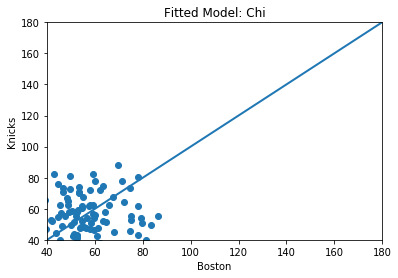

Probability of BOS Win: 0.55


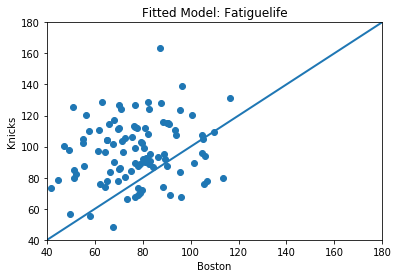

Probability of BOS Win: 0.21


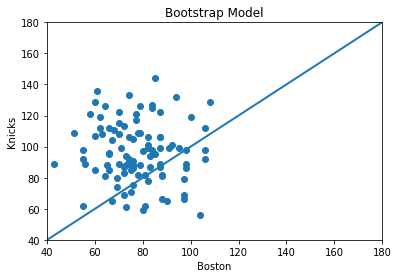

Probability of BOS Win: 0.2


In [226]:
#predict probability of winning using these 2 models

#prediction using the chi distribution
result = []

#find predicted team score for both teams
for x in range (0,100):
    t1_r = projected_score("BOS", starting_five, player_distributionchi, "chi")
    t2_r = projected_score("NYK", starting_five, player_distributionchi, "chi")
    result.append([t1_r, t2_r])

#plot the simulation results
result = np.array(result)
plt.scatter(result[:,0], result[:,1])
plt.plot([40,180], [40,180])
plt.xlim([40,180])
plt.ylim([40,180])
plt.title("Fitted Model: Chi")
plt.ylabel("Knicks")
plt.xlabel("Boston")
plt.show()

#determine the probability of BOS win
bos_win = len(result[result[:,0]>result[:,1]])/100.
print ("Probability of BOS Win: "+str(bos_win))


#prediction using the fatiguelife distribution
result = []
for x in range (0,100):
    t1_r = projected_score("BOS", starting_five, player_distributionfl, "fatiguelife")
    t2_r = projected_score("NYK", starting_five, player_distributionfl, "fatiguelife")
    result.append([t1_r, t2_r])
result = np.array(result)
plt.scatter(result[:,0], result[:,1])
plt.plot([40,180], [40,180])
plt.xlim([40,180])
plt.ylim([40,180])
plt.title("Fitted Model: Fatiguelife")
plt.ylabel("Knicks")
plt.xlabel("Boston")
plt.show()
bos_win = len(result[result[:,0]>result[:,1]])/100.
print ("Probability of BOS Win: "+str(bos_win))

#prediction using bootstrap sampling
result = []
for x in range (0,100):
    t1_r = projected_score_boot("BOS", database_simplePTS, starting_five)
    t2_r = projected_score_boot("NYK", database_simplePTS, starting_five)
    result.append([t1_r, t2_r])
result = np.array(result)
plt.scatter(result[:,0], result[:,1])
plt.plot([40,180], [40,180])
plt.xlim([40,180])
plt.ylim([40,180])
plt.title("Bootstrap Model")
plt.ylabel("Knicks")
plt.xlabel("Boston")
plt.show()
bos_win = len(result[result[:,0]>result[:,1]])/100.
print ("Probability of BOS Win: "+str(bos_win))

We will now test our models against the results from the 2013 season. To compare the performance of our model against actual 2013 results, we will examine 2 metrics, percentage of games that we correctly predicted and the predicted win percentage for each team. For the former metric, in addition to displaying the percentage of games that we correctly predicted, we will also break down the accuracy in terms of percentage of close games predicted and percentage of blowout games predicted. For the later metric, we will display a graph plotting the predicted win percentage per team against the actual win percentage per team. 

In [94]:
#calculate win percentage of 2013 for comparison
winloss = dict.fromkeys(NBA_teams, 0)
for index, row in gamescores.iterrows():
    if row["PTS"]>row["PTS.1"]:
        winloss[row["Visitor/Neutral"]] +=1
    else:
        winloss[row["Home/Neutral"]] +=1

#divide by 82 games, the official number of games played by most NBA teams
winloss = {x:winloss[x]/82. for x in winloss}
print (winloss)

{'ATL': 0.5365853658536586, 'BKN': 0.5975609756097561, 'BOS': 0.5, 'CHA': 0.25609756097560976, 'CHI': 0.5487804878048781, 'CLE': 0.2926829268292683, 'DAL': 0.5, 'DEN': 0.6951219512195121, 'DET': 0.35365853658536583, 'GSW': 0.573170731707317, 'HOU': 0.5487804878048781, 'IND': 0.5975609756097561, 'LAC': 0.6829268292682927, 'LAL': 0.5487804878048781, 'MEM': 0.6829268292682927, 'MIA': 0.8048780487804879, 'MIL': 0.4634146341463415, 'MIN': 0.3780487804878049, 'NOH': 0.32926829268292684, 'NYK': 0.6585365853658537, 'OKC': 0.7317073170731707, 'ORL': 0.24390243902439024, 'PHI': 0.4146341463414634, 'PHX': 0.3048780487804878, 'POR': 0.4024390243902439, 'SAC': 0.34146341463414637, 'SAS': 0.7073170731707317, 'TOR': 0.4146341463414634, 'UTA': 0.524390243902439, 'WAS': 0.35365853658536583}


In [95]:
'''Calculates percentage of games (all games, close games, and blowout games) correctly predicted 
input: DataFrame with HWin column which displays the probability of the home team winning
output: three floats corresponding to a model's percentage of correctly predicted games (all games, close games, and blowouts)
'''

def calc_accuracy(predictions):
    #determine the margins of actual wins
    predictions["Margins"] = predictions["PTS.1"] - predictions["PTS"]
    
    accuracy_all = 0
    accuracy_close = 0
    accuracy_blowouts = 0
    
    #determine the accuracy of all games
    for index, row in predictions.iterrows():
        #if we correctly predicted a home win or if we correctly predicted a visitor win, increase accuracy by 1
        if ((row["Margins"]<0)&(row["HWin"]<=0.5)) or ((row["Margins"]>0)&(row["HWin"]>0.5)):
            accuracy_all += 1
    accuracy_all = accuracy_all/float(len(predictions))
    
    #determine the accuracy of close games
    predictions_close = predictions.loc[abs(predictions["Margins"])<=3]
    for index, row in predictions_close.iterrows():
        if ((row["Margins"]<0)&(row["HWin"]<=0.5)) or ((row["Margins"]>0)&(row["HWin"]>0.5)):
            accuracy_close += 1
    accuracy_close = accuracy_close/float(len(predictions_close))
    
    #determine the accuracy of blowout games
    predictions_blowouts = predictions.loc[abs(predictions["Margins"])>=10]
    for index, row in predictions_blowouts.iterrows():
        if ((row["Margins"]<0)&(row["HWin"]<=0.5)) or ((row["Margins"]>0)&(row["HWin"]>0.5)):
            accuracy_blowouts += 1
    accuracy_blowouts = accuracy_blowouts/float(len(predictions_blowouts))
    
    return accuracy_all, accuracy_close, accuracy_blowouts

#sanity check to make sure the function works
temp = gamescores.copy()
temp["HWin"] = 0
temp["Margins"] = temp["PTS.1"] - temp["PTS"]
temp.loc[temp["Margins"]>0, "HWin"] =1
print (calc_accuracy(temp))

(1.0, 1.0, 1.0)


In [96]:
'''Simulates a full season using a distribution model

input: 
fit: string of distribution identifier at the end of player_distribution (ex: fit="chi" if you want to access player_distributionchi)
dist: string of the scipy name for the distribution

output:
'''

def predict_results_dist(fit, dist, actual, starting, df=0, adjust=0, param=0):

    #keep track of team wins
    result_team = dict.fromkeys(NBA_teams, 0)
    
    #keep track of predicted result for Home team of each match
    result_games = []

    #create predictions for each game in 2013
    for index, row in actual.iterrows():
        team1 = row["Home/Neutral"]
        team2 = row["Visitor/Neutral"]
        date = row["Date"]
        
        #retrieve initial score prediction
        t1 = projected_score(team1, starting, fit, dist)
        t2 = projected_score(team2, starting, fit, dist)
        
        #adjust prediction for other variables (to be used later in the notebook)
        if adjust !=0:
            code = compile("adjust("+param+")", "<string>", "eval")
            t1 += eval(code)
        
        #if team 1's score is more than team 2's score, add a win to team1 and a win to the Home team for this match
        if t1>t2:
            result_team[team1] += 1
            result_games.append(1)
        else:
            result_team[team2] +=1
            result_games.append(0)
    
    return result_team, result_games

'''Runs simulation model and outputs overall accuracy metrics
'''
def runmodel_dist (n, distributions, actual, param):
    #testing the chi, fatiguelife
    for d in distributions:
        
        #determine the total number of games
        numgames =  float(len(actual[actual["Home/Neutral"]=="ATL"])+len(actual[actual["Home/Neutral"]=="ATL"]))
        if numgames < 80:
            numgames = 20.
        else:
            numgames = 82.
        
        #grabs the distribution database
        dist = eval("player_distribution"+d[0])
        
        #holds the predicted win percentage
        predicted_winper = {}
        
        #DataFrame that will be passed to calc_accuracy
        predicted_result = actual.copy()
        
        #will hold the probability of a Home team win for any given match
        predicted_result["HWin"] = 0
        for x in range (0,n):
            
            #retrieve the number of predicted wins by team and by match
            result_t, result = predict_results_dist(dist, d[1], actual, *param)
            
            #add the predicted win percentage
            result_t = {x:result_t[x]/numgames for x in result_t}
            for k, v in result_t.items():
                predicted_winper.setdefault(k, []).append(v)
                
            #add the predicted Home wins for each game
            predicted_result["HWin"] += result
        
        #calculate the probability of a Home win for each game
        predicted_result["HWin"] /= float(n)
        
        #grab the three accuracy ratings
        accuracy = calc_accuracy(predicted_result)
        
        #print metrics and graph
        print (d[1]+" Model")
        print ("Overall, the model correctly predicts: {0:.2%} of game outcomes".format(accuracy[0]))
        print ("Overall, the model correctly predicts: {0:.2%} of close outcomes".format(accuracy[1]))
        print ("Overall, the model correctly predicts: {0:.2%} of blowout outcomes".format(accuracy[2]))
        plot_predictvactual(winloss, predicted_winper)

In [97]:
def predict_results_boot(actual, database, starting, df=0, adjust=0, param=0):
    #keep track of team wins
    result_team = dict.fromkeys(NBA_teams, 0)
    
    #keep track of predicted result for Home team of each match
    result_games = []

    #create predictions for each game in 2013
    for index, row in actual.iterrows():
        team1 = row["Home/Neutral"]
        team2 = row["Visitor/Neutral"]
        date = row["Date"]
        
        #retrieve initial score prediction
        t1 = projected_score_boot(team1, database, starting)
        t2 = projected_score_boot(team2, database, starting)
        
        #adjust prediction for other variables
        if adjust !=0:
            code = compile("adjust("+param+")", "<string>", "eval")
            t1 += eval(code)
        
        #if team 1's score is more than team 2's score, add a win to team1 and a win to the Home team for this match
        if t1>t2:
            result_team[team1] += 1
            result_games.append(1)
        else:
            result_team[team2] +=1
            result_games.append(0)
            
    return result_team, result_games

def runmodel_boot(n, actual, database, param=0):
        
        numgames = float(len(actual[actual["Home/Neutral"]=="ATL"])+len(actual[actual["Home/Neutral"]=="ATL"]))
        
        if numgames < 80:
            numgames = 20.
        else:
            numgames = 82.
        
        #holds the predicted win percentage
        predicted_winper = {}
        
        #DataFrame that will be passed to calc_accuracy
        predicted_result = actual.copy()
        
        #will hold the probability of a Home team win for any given match
        predicted_result["HWin"] = 0
        
        for x in range (0,n):
            
            #retrieve the number of predicted wins by team and by match
            result_t, result = predict_results_boot(actual, database, *param)
            
            #add the predicted win percentage
            result_t = {x:result_t[x]/numgames for x in result_t}
            for k, v in result_t.items():
                predicted_winper.setdefault(k, []).append(v)
                
            #add the predicted Home wins for each game
            predicted_result["HWin"] += result
        
        #calcualte the probability of a Home win for each game
        predicted_result["HWin"] /= float(n)
        
        #grab the three accuracy ratings
        accuracy = calc_accuracy(predicted_result)
        
        #print metrics and graph'''
        print ("Bootstrap Model")
        print ("Overall, the model correctly predicts: {0:.2%} of game outcomes".format(accuracy[0]))
        print ("Overall, the model correctly predicts: {0:.2%} of close outcomes".format(accuracy[1]))
        print ("Overall, the model correctly predicts: {0:.2%} of blowout outcomes".format(accuracy[2]))
        plot_predictvactual(winloss, predicted_winper)
        return
    

In [98]:
'''Plot predicted win percentage (x-axis) against actual win percentage (y-axis)
input: Dictionary of actual win percentages by team, Dictionary of predicted win percentages by team
output: None
'''

def plot_predictvactual(final_result, predicted_result):    
    
    predicted_means = final_result.copy()
    
    #calculate the mean predicted win percentage and the standard deviation
    for key, value in predicted_result.items():
        temp = np.array(value)
        predicted_means[key] = [np.mean(temp), np.std(temp)]

    list_actualmeans = []
    list_predictmeans = []
    list_predicterror = []
    
    #create arrays of actual win percentage, mean predicted win percentage, and standard error in the correct order
    for key, value in final_result.items():
        list_actualmeans.append(value)
        list_predictmeans.append(predicted_means[key][0])
        list_predicterror.append(predicted_means[key][1]) 

    #plot
    plt.errorbar(list_predictmeans, list_actualmeans, yerr=list_predicterror, ls="none", fmt='ro')
    plt.plot([0.1,1], [0.1,1])
    plt.xlim([0.1,1])
    plt.ylim([0.1,1])
    plt.xlabel("Mean of Predicted Win Percentage")
    plt.ylabel("Actual Win Percentage") 
    plt.show()
    return

chi Model
Overall, the model correctly predicts: 52.24% of game outcomes
Overall, the model correctly predicts: 55.26% of close outcomes
Overall, the model correctly predicts: 52.45% of blowout outcomes


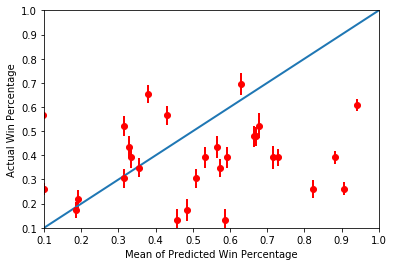

fatiguelife Model
Overall, the model correctly predicts: 57.85% of game outcomes
Overall, the model correctly predicts: 56.84% of close outcomes
Overall, the model correctly predicts: 59.70% of blowout outcomes


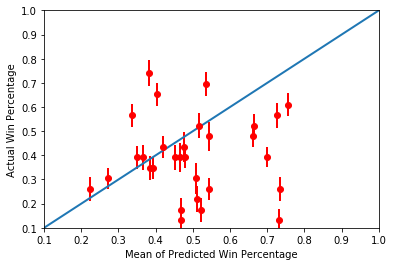

Bootstrap Model
Overall, the model correctly predicts: 57.04% of game outcomes
Overall, the model correctly predicts: 54.74% of close outcomes
Overall, the model correctly predicts: 59.53% of blowout outcomes


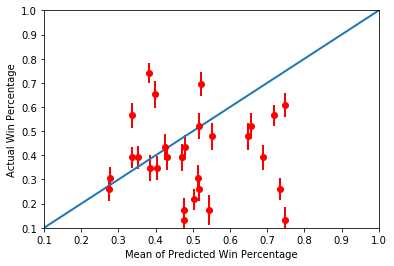

In [227]:
testing_dist = [["chi","chi"], ["fl","fatiguelife"]]
runmodel_dist(50, testing_dist, gamescores, [starting_five])
runmodel_boot(50, gamescores, database_simplePTS, [starting_five])

Our models here were fairly accurate, with an overall accuracy of around 55-60%, higher than 50% due to chance. Predictably, our models are better at predicting blowout games, which often occur due to a sizable gap in skill level between teams, than close games, which is often driven by luck as both teams are equally skilled.

This accuracy is emphasized by the graphs above. Here, we are plotting the mean predicted win percentage on the x-axis against the actual win percentage on the y-axis, with error bars illustrating standard deviation within the predicted win percentages. The x=y blue line represents a perfectly calibrated system where all the mean predictions are equal to the actual win percentages. Thus, the closer our results are to the blue line, the higher the chance that our data is overfitted; the further away they are, the higher the chance that they are underfit.

We can see that our data has reasonable errorbars and that, with the exception of a few outliers, our model is fairly accurate at predicting 2013 results. A vast majority of our points either lie on the blue line or have error bars that emcompass the blue line. Even the points that do not emcompass the blue line still lie reasonably close to the line. Our model does not appear to be overfitted as there are a fair number of points that do not lie on the line.

In comparing the fitted models to the bootstrap model, we can see that there is not much difference between the two models. The fitted models do appear to be slightly more overfitted with more points lying directly on the blue line. They also appear to have smaller error bars than the bootstrap model. 

### Adjustments to the Starting Lineup

We will now test other variations of this model by changing how the starting lineup is determined. First, instead of creating the starting lineup from the top average scorers, we will create the starting lineup from the top scorers of 2013. 

chi Model
Overall, the model correctly predicts: 54.92% of game outcomes
Overall, the model correctly predicts: 54.74% of close outcomes
Overall, the model correctly predicts: 56.32% of blowout outcomes


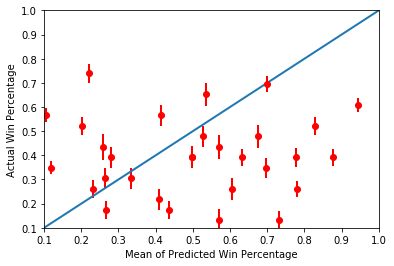

fatiguelife Model
Overall, the model correctly predicts: 60.70% of game outcomes
Overall, the model correctly predicts: 54.74% of close outcomes
Overall, the model correctly predicts: 64.92% of blowout outcomes


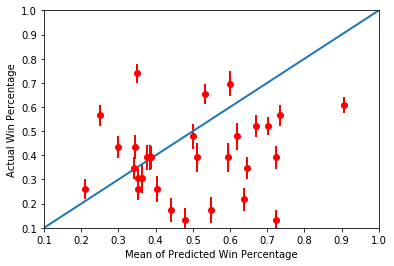

Bootstrap Model
Overall, the model correctly predicts: 59.48% of game outcomes
Overall, the model correctly predicts: 55.79% of close outcomes
Overall, the model correctly predicts: 62.90% of blowout outcomes


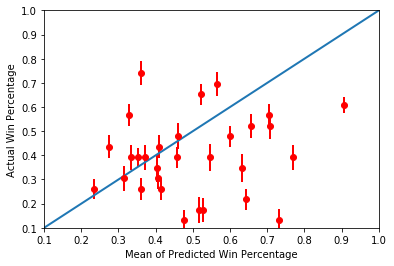

In [228]:
#base starting lineup on 2013 scores ONLY
starting_five2013 = starting_lineup(players_data[players_data['Date'].str.contains("2013")])

runmodel_dist(50, testing_dist, gamescores, [starting_five2013])
runmodel_boot(50, gamescores, database_simplePTS, [starting_five2013])

Creating the starting lineup from top scorers of 2013 improved our overall accuracy by around 5%. This makes sense intuitively as players who have high historical scores per game may have had a bad season in 2013, leading them to be benched, or were injured in 2013. Most often, the player that replaces these historical top scorers will also be fairly high scorers themselves, hence why our first model still performed better than chance, but there are a few cases where the replacement player is significantly less skilled than the original player. However, because these cases are few and far in between, the accuracy of our model did not improve drastically.

In the next iteration, we will directly base our starting lineup on minutes played in 2013. The starting five will be the players on a team who had the highest average playing time. This variation should be close in accuracy to the previous model that used highest average score in 2013 since players who scored the most were probably also on the court for the longest period of time. 

In [101]:
'''Transform minutes:second format into total seconds
input: String of time in the format of MM:SS
output: integer of the time in seconds
'''
def convert_time(original):

    #handles the corner case of 60:00
    try:
        #convert to time format
        x = time.strptime(original.split(',')[0],'%M:%S')
    except ValueError:
        return 3600
    
    #return total seconds
    return datetime.timedelta(minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

players_MP13 = players_data[players_data['Date'].str.contains("2013")]
players_MP13['MP'] = players_MP13['MP'].map(lambda x: convert_time(x))

In [102]:
'''Create a starting lineup based on minutes played
input: DataFrame of player data
output: Dictionary of each team's starting lineup
'''
def starting_lineupMP(data):
    #calculate the average minutes played for each player and sort by the average points
    players_grouped = data.groupby(['Tm','name']).MP.mean()
    players_grouped = players_grouped.sort_values(ascending = False)
    players_grouped = pd.DataFrame(players_grouped.reset_index())
    
    #retrieve the five highest MP, which will represent the starting lineup
    players_grouped2 = players_grouped.groupby(['Tm'])
    starters = {}
    for name, group in players_grouped2:
        starters[name] = group['name'][0:5].values
    return starters
starting_fiveMP13 = starting_lineupMP(players_MP13)

chi Model
Overall, the model correctly predicts: 55.98% of game outcomes
Overall, the model correctly predicts: 56.84% of close outcomes
Overall, the model correctly predicts: 56.66% of blowout outcomes


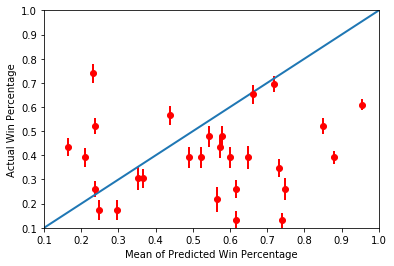

fatiguelife Model
Overall, the model correctly predicts: 61.03% of game outcomes
Overall, the model correctly predicts: 56.84% of close outcomes
Overall, the model correctly predicts: 64.76% of blowout outcomes


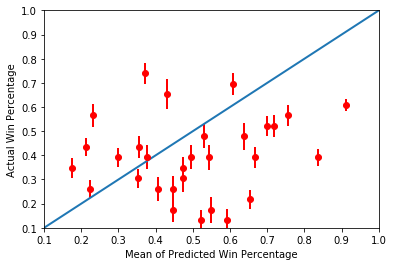

Bootstrap Model
Overall, the model correctly predicts: 59.80% of game outcomes
Overall, the model correctly predicts: 54.74% of close outcomes
Overall, the model correctly predicts: 63.58% of blowout outcomes


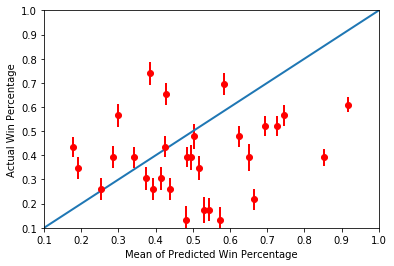

In [229]:
runmodel_dist(50, testing_dist, gamescores, [starting_fiveMP13])
runmodel_boot(50, gamescores, database_simplePTS, [starting_fiveMP13])

As we can see, there does not appear to be a major change in the accuracy metrics of the model which continue to hover around 60%. There is a slight change to the distribution of the results, which appear to flatten out as the points move slightly closer to the blue line.

Although there does not appear to be any major difference between using average points scored in 2013 and average minutes-played in 2013 in creating the starting lineup, we will be using the starting lineup built by average minutes-played as total court time is a more reliable indication of being part of the starting lineup. This method avoids potential corner cases where a substitute may have scored a large number of points during the few minutes they play on the court.

### Adjustments to Baseline Score Model: History Against Other Teams

As we can see above, our baseline score models, using 2013 minutes-played to determine the starting lineup, are all reasonably accurate with an overall accuracy of around 60%, higher than the 50% accuracy due to pure chance. However, our models only factor in individual players' scores and do not take into consideration interaction between teams. Some teams, while otherwise a very strong team overall, may have chronically poor performance against one team in particular whether it is because they are long-time rivals or because that particular opponent has figured the strategy behind the team's success.

In our next iteration, we will incorporate into our models this interaction between teams by sampling from the historical win/loss margins of teams against their opponents. Furthermore, as we can see above, the performance of the chi and fatiguelife model are very similar. So, for performance and runtime sake, we will now only examine the fatiguelife model and the bootstrap model. 

In [230]:
''' Create a DataFrame of the historical win/loss margins of a team vs. a specific opponent
input: DataFrame of historical scores
output: DataFrame of historical margins of all possible match-ups
'''

def historical_margins(finalscores):
    
    #create DataFrame with the match-up as the index
    finalscores["matches"] = finalscores["Home/Neutral"] + ","+ finalscores["Visitor/Neutral"]
    finalscores = finalscores.set_index("matches")
    
    #determine the margins by which the HOME TEAM won/lost
    finalscores["margins"] = finalscores["PTS.1"]-finalscores["PTS"]
    
    #drop unnecessary columns
    finalscores = finalscores.drop(["Visitor/Neutral","Home/Neutral", "PTS", "PTS.1"], 1)
    
    return finalscores

hist_margins = historical_margins(allscores)
print (hist_margins.head())

                      Date  margins
matches                            
CLE,WAS  Tue, Oct 30, 2012       10
LAL,DAL  Tue, Oct 30, 2012       -8
MIA,BOS  Tue, Oct 30, 2012       13
CHI,SAC  Wed, Oct 31, 2012        6
DET,HOU  Wed, Oct 31, 2012       -9


In [105]:
'''Adjust the predicted score by randomly sampling from historical margins
input: string of team1 name, string of team2 name, DataFrame holding the historical margins
output: int radomly selected from historical margins between team1 and team2
'''
def margin_adjust (team1, team2, margins):
        #grab historical margins for HOME, VISITOR
        result = []
        match = team1+","+team2
        result.extend(margins.loc[match, "margins"])
        
        #grab historical margins for VISITOR, HOME
        match = team2+","+team1
        #multiply by -1 since margins are by how much the HOME team won/loss by
        result.extend(-1*margins.loc[match, "margins"])
        
        #randomy return from among these historical margins
        return choice(result)


fatiguelife Model
Overall, the model correctly predicts: 63.06% of game outcomes
Overall, the model correctly predicts: 55.26% of close outcomes
Overall, the model correctly predicts: 66.95% of blowout outcomes


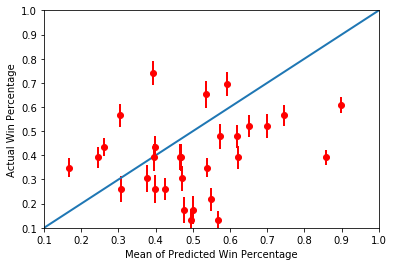

Bootstrap Model
Overall, the model correctly predicts: 62.25% of game outcomes
Overall, the model correctly predicts: 58.42% of close outcomes
Overall, the model correctly predicts: 65.26% of blowout outcomes


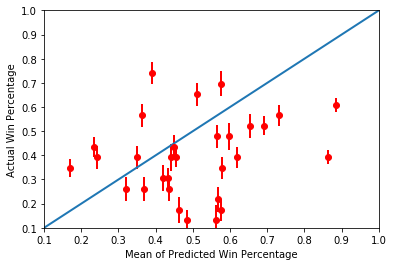

In [231]:
testing_dist = [["fl","fatiguelife"]]
runmodel_dist(50, testing_dist, gamescores, [starting_fiveMP13, hist_margins, margin_adjust, "team1, team2, df"])
runmodel_boot(50, gamescores, database_simplePTS, [starting_fiveMP13, hist_margins, margin_adjust, "team1, team2, df"])

Interestingly, introducing historical margins did not significantly improve our accuracy metrics. However, looking at the graphs, sampling from historical margins appears to have introduced more variation to our results and decreased the calibration of the model; there are now less points directly on the blue line.

One possible explanation for the lack of increased accuracy is that perhaps a team does not have a consistent history against an opposing team. It could be that their win percentage against most teams, historically, amount to around 50% or, if they do have a historically low win percentage against a team, that the margins by which they lose/win is not large enough to truely impact our baseline scoring model.  

Even though accounting for historical margins do not appear to have increased our accuracy, we will keep this adjustment in our models as it introduces more variability to the data and appears to be effective at preventing overfitting.

### Additional Adjustments to the model: Assists, Turnovers, and Offensive Rebounds
Now, let us introduce more variables to the model. Specifically, we will look at assists, offensive rebounds, and turnovers, the later two quoted by Dean Oliver as among the 4 most important statistics in basketball. 

In [107]:
''' Creates a dictionary from which the assist_adjust function will randomly sample historical assists per game per player
input: dictionary of the starting lineup for each team, DataFrame of the schedule, DataFrame of the players data
output: dictionary of individual players' historical assists for each match-up on the schedule
'''

def adjust_build(starting, var, actual=gamescores, data=players_data):
    
    #create a Dataframe of all possible match-ups, ignoring home vs. visitor distinctions
    actual_mod = actual.drop_duplicates(subset = ["Home/Neutral","Visitor/Neutral"])
    matches = actual_mod["Home/Neutral"] + ","+ actual_mod["Visitor/Neutral"]
    result = dict.fromkeys(matches, [])
    
    #for each match-up, find the historical assist numbers for each teams' starting players
    for index, row in actual_mod.iterrows():
        assists_totalt1 = []
        assists_totalt2 = []
        
        #grab the team names
        team1 = row["Home/Neutral"]
        team2 = row["Visitor/Neutral"]
        
        #grab starting players
        playerst1 = starting[team1]
        playerst2 = starting[team2]
        
        #retrieve history of assists by starting players
        for name in playerst1:
            assists_ind = eval("data[data['name']==name]."+var)
            assists_totalt1.append(assists_ind.values)
        for name in playerst2:
            assists_ind = eval("data[data['name']==name]."+var)
            assists_totalt2.append(assists_ind.values)
        
        #add assists to dictionary
        result[team1+","+team2] = [assists_totalt1,assists_totalt2]
        
    return result


In [ ]:
'''#sanity check to ensure the database was properly made
assists_database = adjust_build(starting_fiveMP13, "AST")
print (assists_database["CLE,WAS"][0])

In [109]:
''' Adjust the baseline score prediction

inputs: 
team1- String for team 1
team2- String for team2
margins- DataFrame of historical margins
weight- weight for assist, turnover, and rebound variable
database_adjust- DataFrame from which to sample assist/turnover/rebound for individual players
actual- DataFrame of actual results to compare against, default is 2013 results
starting- Dictionary of starting lineup for each team, default is starting lineup determined by minutes-played
data- DataFrame of individual players data, default is players_data for 2008-2013

output: int by which to adjust the baseline prediction
'''
def model_adjust(team1, team2, margins, weight, database_adjust, actual=gamescores, starting=starting_fiveMP13, data=players_data):
    
    #margin adjustment
    adjust1 = margin_adjust(team1, team2, margins)
    
    #scores for each team
    t1= 0
    t2 = 0

    #retrieve the historical number of assists per player per team
    adjust_team1 = database_adjust[team1+","+team2][0]
    adjust_team2 = database_adjust[team1+","+team2][0]
    
    #randomly select an assist number for each player
    for x in adjust_team1:
        t1 += choice(x)
    for x in adjust_team2:
        t2 += choice(x)
  
    adjust1 += (t1-t2)*weight
    
    return adjust1

In [110]:
#rerun actual win/loss calculation due to weird bug in which win/loss sometimes mutates by this run
winloss = dict.fromkeys(NBA_teams, 0)
for index, row in gamescores.iterrows():
    if row["PTS"]>row["PTS.1"]:
        winloss[row["Visitor/Neutral"]] +=1
    else:
        winloss[row["Home/Neutral"]] +=1

#divide by 82 games, the official number of games played by most NBA teams
winloss = {x:winloss[x]/82. for x in winloss}
print (winloss)

{'ATL': 0.5365853658536586, 'BKN': 0.5975609756097561, 'BOS': 0.5, 'CHA': 0.25609756097560976, 'CHI': 0.5487804878048781, 'CLE': 0.2926829268292683, 'DAL': 0.5, 'DEN': 0.6951219512195121, 'DET': 0.35365853658536583, 'GSW': 0.573170731707317, 'HOU': 0.5487804878048781, 'IND': 0.5975609756097561, 'LAC': 0.6829268292682927, 'LAL': 0.5487804878048781, 'MEM': 0.6829268292682927, 'MIA': 0.8048780487804879, 'MIL': 0.4634146341463415, 'MIN': 0.3780487804878049, 'NOH': 0.32926829268292684, 'NYK': 0.6585365853658537, 'OKC': 0.7317073170731707, 'ORL': 0.24390243902439024, 'PHI': 0.4146341463414634, 'PHX': 0.3048780487804878, 'POR': 0.4024390243902439, 'SAC': 0.34146341463414637, 'SAS': 0.7073170731707317, 'TOR': 0.4146341463414634, 'UTA': 0.524390243902439, 'WAS': 0.35365853658536583}


In [111]:
database_adjustAST = adjust_build(starting_fiveMP13, "AST")
database_adjustTOV = adjust_build(starting_fiveMP13, "TOV")
database_adjustORB = adjust_build(starting_fiveMP13, "ORB")

Bootstrap Model
Overall, the model correctly predicts: 67.37% of game outcomes
Overall, the model correctly predicts: 62.63% of close outcomes
Overall, the model correctly predicts: 70.66% of blowout outcomes


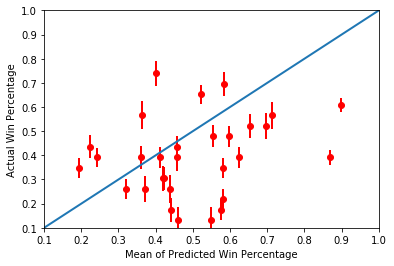

Bootstrap Model
Overall, the model correctly predicts: 66.31% of game outcomes
Overall, the model correctly predicts: 57.89% of close outcomes
Overall, the model correctly predicts: 70.15% of blowout outcomes


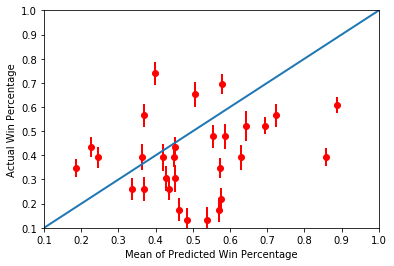

Bootstrap Model
Overall, the model correctly predicts: 66.48% of game outcomes
Overall, the model correctly predicts: 60.00% of close outcomes
Overall, the model correctly predicts: 70.49% of blowout outcomes


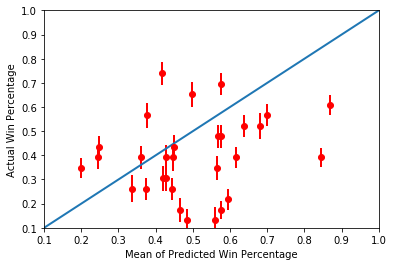

Bootstrap Model
Overall, the model correctly predicts: 66.23% of game outcomes
Overall, the model correctly predicts: 60.00% of close outcomes
Overall, the model correctly predicts: 69.14% of blowout outcomes


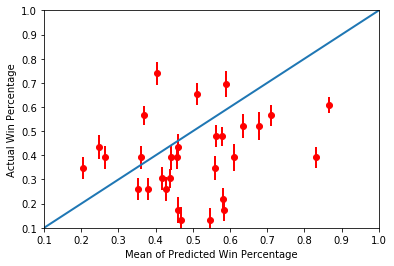

In [232]:
weights = [0.5,1.,1.5,2.]

#testing only on bootstrap due to speed, following code is a modified runmodel_boot
for weight in weights:
        #holds the predicted win percentage
        predicted_winper2 = {}
        
        #DataFrame that will be passed to calc_accuracy
        predicted_result2 = gamescores.copy()
        
        #will hold the probability of a Home team win for any given match
        predicted_result2["HWin"] = 0
        
        for x in range (0,50):
        
            #retrieve the number of predicted wins by team and by match
            result_t2, result2 = predict_results_boot(gamescores, database_simplePTS, starting_fiveMP13, 
                                                    hist_margins, model_adjust, "team1, team2, df, weight, database_adjustAST, gamescores")
    
            #add the predicted win percentage
            result_t2 = {x:result_t2[x]/82. for x in result_t2}
            for k, v in result_t2.items():
                predicted_winper2.setdefault(k, []).append(v)
                
            #add the predicted Home wins for each game
            predicted_result2["HWin"] += result2
    
        #calculate the probability of a Home win
        predicted_result2["HWin"] /= float(30)
        
        #return accuracy metrics
        accuracy2 = calc_accuracy(predicted_result2)
        
        #plot
        print ("Bootstrap Model")
        print ("Overall, the model correctly predicts: {0:.2%} of game outcomes".format(accuracy2[0]))
        print ("Overall, the model correctly predicts: {0:.2%} of close outcomes".format(accuracy2[1]))
        print ("Overall, the model correctly predicts: {0:.2%} of blowout outcomes".format(accuracy2[2]))
        plot_predictvactual(winloss, predicted_winper2)

As we can see above, adding the assist variable does not improve overall accuracy, but does appear to improve the accuracy of blowout outcomes. In addition, as we can see in the graphs above, there is very little change to the overall calibration of the model. Furthermore, interestingly, the graph seems to shrink on itself as the optimization weight increases, with the dots moving closer to the center. This suggests that setting the weight at too high a value may begin to smooth out the variability between teams, causing the predictions to move closer to the 50% win percentage point.

Now let us examine turnovers and offensive rebounds.

Bootstrap Model
Overall, the model correctly predicts: 66.48% of game outcomes
Overall, the model correctly predicts: 58.42% of close outcomes
Overall, the model correctly predicts: 69.81% of blowout outcomes


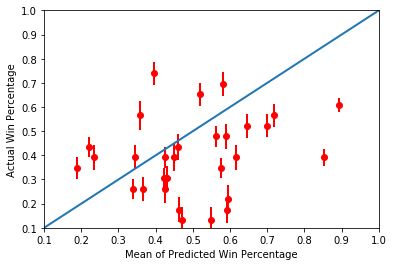

Bootstrap Model
Overall, the model correctly predicts: 66.72% of game outcomes
Overall, the model correctly predicts: 57.37% of close outcomes
Overall, the model correctly predicts: 70.66% of blowout outcomes


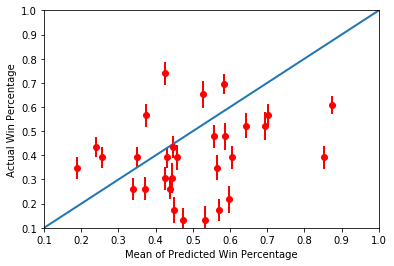

Bootstrap Model
Overall, the model correctly predicts: 66.64% of game outcomes
Overall, the model correctly predicts: 57.37% of close outcomes
Overall, the model correctly predicts: 70.99% of blowout outcomes


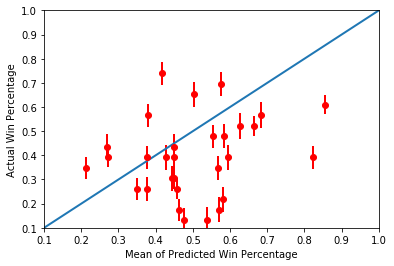

Bootstrap Model
Overall, the model correctly predicts: 66.31% of game outcomes
Overall, the model correctly predicts: 61.05% of close outcomes
Overall, the model correctly predicts: 70.83% of blowout outcomes


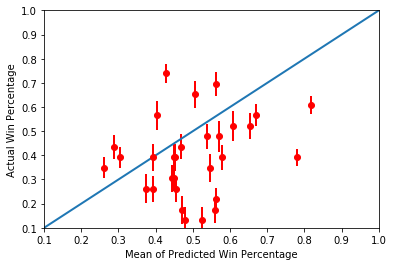

In [233]:
weights = [1.,2.,4.,6.]


#testing only on bootstrap due to speed, following code is a modified runmodel_boot
for weight in weights:
        #holds the predicted win percentage
        predicted_winper3 = {}
        
        #DataFrame that will be passed to calc_accuracy
        predicted_result3 = gamescores.copy()
        
        #will hold the probability of a Home team win for any given match
        predicted_result3["HWin"] = 0
        
        for x in range (0,50):
        
            #retrieve the number of predicted wins by team and by match
            result_t3, result3 = predict_results_boot(gamescores, database_simplePTS, starting_fiveMP13, 
                                                    hist_margins, model_adjust, "team1, team2, df, weight, database_adjustTOV, gamescores")
    
            #add the predicted win percentage
            result_t3 = {x:result_t3[x]/82. for x in result_t3}
            for k, v in result_t3.items():
                predicted_winper3.setdefault(k, []).append(v)
                
            #add the predicted Home wins for each game
            predicted_result3["HWin"] += result3
        
        #calculate the probability of a Home win
        predicted_result3["HWin"] /= float(30)
        
        #return accuracy metrics
        accuracy3 = calc_accuracy(predicted_result3)
        
        #plot
        print ("Bootstrap Model")
        print ("Overall, the model correctly predicts: {0:.2%} of game outcomes".format(accuracy3[0]))
        print ("Overall, the model correctly predicts: {0:.2%} of close outcomes".format(accuracy3[1]))
        print ("Overall, the model correctly predicts: {0:.2%} of blowout outcomes".format(accuracy3[2]))
        plot_predictvactual(winloss, predicted_winper3)

Bootstrap Model
Overall, the model correctly predicts: 65.42% of game outcomes
Overall, the model correctly predicts: 56.32% of close outcomes
Overall, the model correctly predicts: 68.97% of blowout outcomes


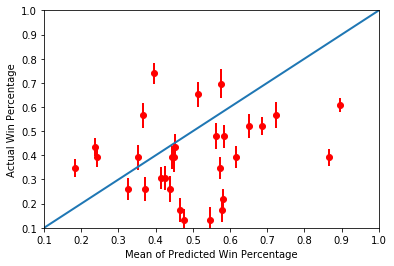

Bootstrap Model
Overall, the model correctly predicts: 66.88% of game outcomes
Overall, the model correctly predicts: 59.47% of close outcomes
Overall, the model correctly predicts: 70.83% of blowout outcomes


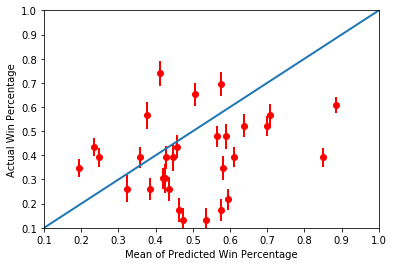

Bootstrap Model
Overall, the model correctly predicts: 65.58% of game outcomes
Overall, the model correctly predicts: 60.00% of close outcomes
Overall, the model correctly predicts: 69.14% of blowout outcomes


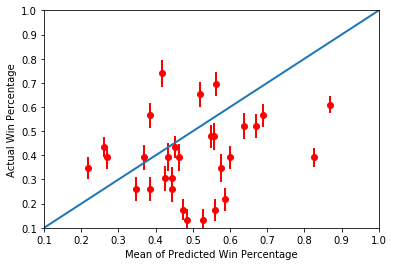

Bootstrap Model
Overall, the model correctly predicts: 65.17% of game outcomes
Overall, the model correctly predicts: 58.95% of close outcomes
Overall, the model correctly predicts: 69.48% of blowout outcomes


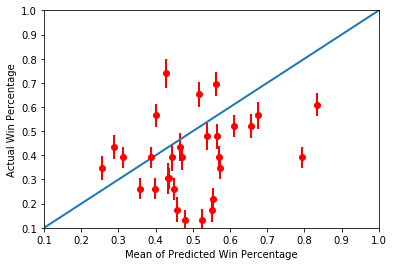

In [234]:
weights = [1.,2.,4.,6.]
database_adjust = adjust_build(starting_fiveMP13, "ORB")

#testing only on bootstrap due to speed, following code is a modified runmodel_boot
for weight in weights:
        #holds the predicted win percentage
        predicted_winper4 = {}
        
        #DataFrame that will be passed to calc_accuracy
        predicted_result4 = gamescores.copy()
        
        #will hold the probability of a Home team win for any given match
        predicted_result4["HWin"] = 0
        
        for x in range (0,50):
            
            #retrieve the number of predicted wins by team and by match
            result_t4, result4 = predict_results_boot(gamescores, database_simplePTS, starting_fiveMP13, 
                                                    hist_margins, model_adjust, "team1, team2, df, weight, database_adjustORB, gamescores")
    
            #add the predicted win percentage
            result_t4 = {x:result_t4[x]/82. for x in result_t4}
            for k, v in result_t4.items():
                predicted_winper4.setdefault(k, []).append(v)
                
            #add the predicted Home wins for each game
            predicted_result4["HWin"] += result4
        
        #calculate the probability of a Home win
        predicted_result4["HWin"] /= float(30)
        
        #return accuracy metrics
        accuracy4 = calc_accuracy(predicted_result4)
        
        #plot
        print ("Bootstrap Model")
        print ("Overall, the model correctly predicts: {0:.2%} of game outcomes".format(accuracy4[0]))
        print ("Overall, the model correctly predicts: {0:.2%} of close outcomes".format(accuracy4[1]))
        print ("Overall, the model correctly predicts: {0:.2%} of blowout outcomes".format(accuracy4[2]))
        plot_predictvactual(winloss, predicted_winper4)

Interestingly, we can see above that adding a turnover variable and rebound variable appears to produce the same effect as adding an assist variable, namely an increase in the accuracy of blowout games. Granted, it is possible that the weights we are using may not be the optimal weights for the three variables we are testing or that the way we are adjusting the predicted scores is not correct, thus explaining why we are not seeing an increase in accuracy. However, it is equally likely that there is no significant increase in overall accuracy because these three variables fail to capture factors not already captured by the original scoring model. In other words, assists, turnovers, and offensive rebounds just reaffirm what points per game is already measuring, namely that a player is a good player who can make big plays. This is reaffirmed by the fact that a player's score per game is strongly positively correlated with these three variables.

In [115]:
print (stats.pearsonr(players_data["PTS"], players_data["AST"]))
print (stats.pearsonr(players_data["PTS"], players_data["TOV"]))
print (stats.pearsonr(players_data["PTS"], players_data["ORB"]))

(0.39182844377330173, 0.0)
(0.39405786398036008, 0.0)
(0.23724094217446742, 0.0)


Giving the lack of significant positive improvement in accuracy, the risk of overfitting, and runtime, we will not utilize any additional adjustments to the baseline model besides adjusting for historical margins. Using this historical margins adjusted model, let us now predict the results for the 2014 season for both the fitted chi model and the bootstrap model.

In [116]:
#grab new 2014 data
players_MP14 = players_2014.copy()
players_MP14["MP"] = players_2014['MP'].map(lambda x: convert_time(x))

#recreate the starting lineup
starting_fiveMP14 = starting_lineupMP(players_MP14)


In [117]:
#update individual player's historical numbers
database_PTS2014 = bootstrap_build(players_data_08_14)

In [235]:
#update historical margins
hist_margins_14 = historical_margins(allscores_2014)
print (hist_margins_14.head())

                      Date  margins
matches                            
CLE,WAS  Tue, Oct 30, 2012     10.0
LAL,DAL  Tue, Oct 30, 2012     -8.0
MIA,BOS  Tue, Oct 30, 2012     13.0
CHI,SAC  Wed, Oct 31, 2012      6.0
DET,HOU  Wed, Oct 31, 2012     -9.0


In [119]:
#calculate win percentage of 2014 for comparison
winloss = dict.fromkeys(NBA_teams, 0)
for index, row in scores_2014.iterrows():
    if row["PTS"]>row["PTS.1"]:
        winloss[row["Visitor/Neutral"]] +=1
    else:
        winloss[row["Home/Neutral"]] +=1

#divide by 23 games, the official number of games played so far
winloss = {x:winloss[x]/23. for x in winloss}

Bootstrap Model
Overall, the model correctly predicts: 53.82% of game outcomes
Overall, the model correctly predicts: 55.56% of close outcomes
Overall, the model correctly predicts: 58.87% of blowout outcomes


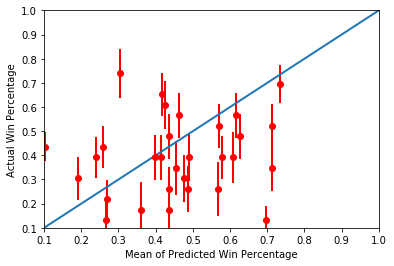

In [236]:
#re-run our bootstrap model builder with the margin function
runmodel_boot(100, scores_2014, database_PTS2014, [starting_fiveMP14, hist_margins_14, margin_adjust, "team1, team2, df"])

In [121]:
#update player fit param
player_distributionfl = distribution_param("fatiguelife", players_data_08_14)

fatiguelife Model
Overall, the model correctly predicts: 56.00% of game outcomes
Overall, the model correctly predicts: 64.44% of close outcomes
Overall, the model correctly predicts: 58.06% of blowout outcomes


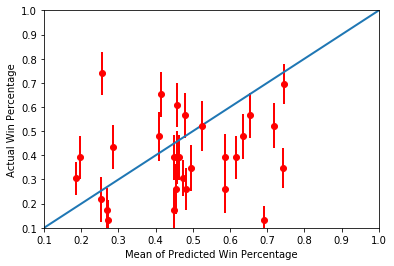

In [237]:
#re-run fit fit builder with the margin function
runmodel_dist(100, testing_dist, scores_2014, [starting_fiveMP14, hist_margins_14, margin_adjust, "team1, team2, df"])

Above, for both the fitted model and the bootstrap model, the overall accuracy was around 55%, slightly higher than 50% chance. Interestingly, both accuracy for close games and blowouts were above chance at 55% and 60% respectively.

Looking at the graphs, we can see that both models have high errors, most likely due to the low number of games played so far in 2014. It also appears that, for most team, both models are overpredicting their win percentages. Again, this may be due to the low number of games; perhaps some of the better teams are just having a rough start to the season. The calibration of the model is significantly lower than for 2013, with many points failing to emcompass the blue line.

# Bayesian Analysis:
## Building on the Points-only Model: Using ABPRmetrics to account for Possessions
#### APBRmetrics
The Association for Professional Basketball Research Metrics refers to the analysis of basketball using statistics, much akin to sabermetrics for baseball. A key idea to APBRmetrics is that a team's performance should be evaluated based on their number of possessions. In other words, only the ratio: total points/total possessions is useful i.e. a team that score 100 points in 50 possessions is much better than a team that scores 100 points in 75 possessions. 

To account for this, we will use the APBR metric Offensive Rating. Mathematically, $Offensive Rating=\frac{Points\cdot{100}}{Possessions}$ representing Total Points Scored per 100 Possessions. The formula for Possessions is given by Kubatko et. al's "A Starting Point for Analyzing Basketball Statistics," which appears as follows:

$Possessions=0.96(Field Goal Attempts - Offensive Rebounds+Turnovers+0.44\cdot{Free Throw Attempts})$ 

For every player and for every basketball game, we will calculate an Offensive Rating for that player for that game. Because APBRmetrics typically apples to a team on a per game basis rather than players, we will weight each player's offensive rating by the percentage of the game they actually played. We do this because if a player who plays for 30 seconds in a game shoots a 3-point shot in only 1 possession, he would get an Offensive rating of $OffRating=\frac{3\cdot{100}}{1}$ which would be extremely inaccurate compared to a player who plays 40 minutes in a game, scores 30 points, but in 20 possessions. The latter has a much more influential impact to the team than the former. By weighing Offensive Rating by % game played, players who have less game time will have lower adjusted ratings, which should be the case.

In [123]:
"""
Function grabs the player dataframe and makes calculations to arrive at:
    Offensive Rating = (Adj_PTS_byminutes/Possessions)*100
"""
def df_with_rating(dataframe):
    df=dataframe.copy()
    
    #calculate possessions
    df['Possessions']=0.96*(df['FGA']-df['ORB']+df['TOV']+0.44*df['FTA'])
    #check to make sure possessions can't be less than 1
    df['Possessions']=df['Possessions'].apply(lambda x: check_possession(x))
    
    #calculate percent of total game time, adjust MP
    df['MP']=df['MP'].apply(lambda x: tominutes(x)/48.)
    #adjust points by multiplying by percent of total game time
    df['Pts_adj']=df['MP']*df['PTS']
    #calculate a player's rating
    df['Rating']=100*df['Pts_adj']/df['Possessions']
    #change Date to monthly
    df['Date']=df['Date'].apply(lambda x: tomonth(x))
    return df

"""
    date is in the string format 2010-01-13
    returns a string that is just 01 (we only want the month)
"""
def tomonth(string):
    time=string.split('/')[0]
    return time

#convert the time to minutes
def tominutes(string):
    time=string.split(':')
    minutes=float(time[0])+float(time[1])/60. #0th index is minutes, 1st index is seconds
    return minutes

#prevent nonsensical possessions, a player can't have less than 1 possession per game
def check_possession(possession):
    if possession < 1.:
        return 0.96 #in the APBR model, weight possessions by 0.96
    else:
        return possession

In [124]:
#looking at previous year's data (2013)
players_data_j = pd.read_csv("playerdata_2013.csv")
#get df for 2013 season
df=df_with_rating(players_data_j)
#group by player name
gb=df.groupby('name')

#### Frequentist Setting:
We will attempt to model each player's Offensive Rating during the NBA season ending in 2013. By looking at the distribution of players' offensive rating, we notice they are bell-shaped and many appear approximately normal. Thus, we will make a reasonable assumption that a player's 2013 Offensive Rating is distributed $OffRating\sim{N(\mu,\sigma^2)}$ where $\mu$ and $\sigma$ will be approximated by the fitted normal. 

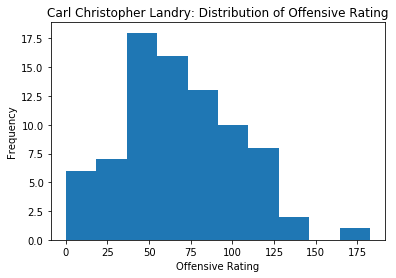

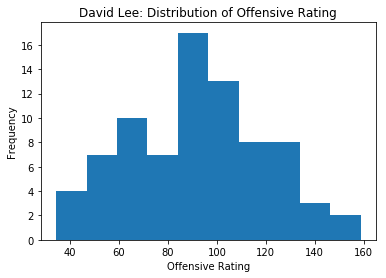

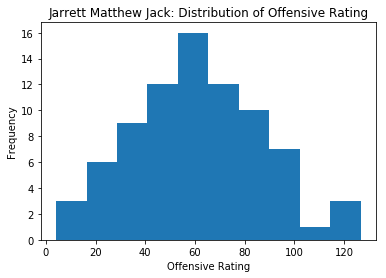

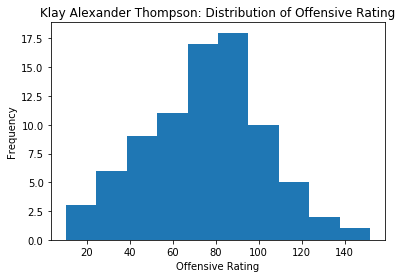

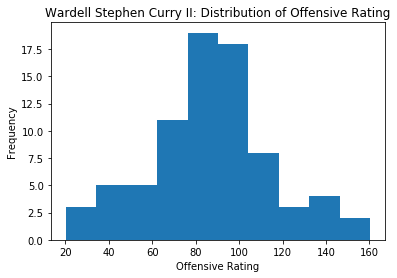

In [238]:
fixed_starting = ["Carl Christopher Landry", "David Lee", "Jarrett Matthew Jack", "Klay Alexander Thompson", "Wardell Stephen Curry II"]

"""
Function rating_distribution() plots histograms showing distribution of offensive ratings during the 
2012-2013 NBA season.

arguments are: 
        team: string such as BOS for the Celtics 
        groupby: holds player offensive ratings grouped by Tm
"""
def rating_distribution(team,groupby):
    #we will make the assumption that each player's offensive rating is normally distributed
    for name, group in groupby:
        
        #take for example the Boston Celtics
        for player in fixed_starting:
            if name==player:
                rating=list()
                for each in group['Rating']:
                    if np.isnan(each)==False and math.isinf(each)==False:
                        rating.append(each)
                        
                #a look at the histograms reveals bell-shaped, approximately normal distribution
                plt.hist(rating,bins=10)
                plt.title('%s' % player + ': Distribution of Offensive Rating')
                plt.xlabel('Offensive Rating')
                plt.ylabel('Frequency')
                plt.figure()
    return

#check out the Los Angeles Clippers!
rating_distribution('LAC',gb)

Again, by looking at the distribution of players' offensive rating, we make the assumption that a player's 2013 Offensive Rating is normally distributed. Thus, we must approximate each player's parameters of their normal offensive rating distribution, $\mu$ and $\sigma$. We do so using the module scipy.

In [126]:
"""
We make the assumption that the data is approximately normal and 
thus find the parameters of the normal per player.

Input argument: 
    groupby with playerdata
    column: string of the column name we are analyzing, for example 'Rating' 
function returns a dictionary with player info:
    name, team, and params for normal distribution 
"""
def player_info(groupby,column):
    #create a new dictionary to store player info
    rating_dic={}
    rating_dic['name']=[]
    rating_dic['Tm']=[]
    rating_dic['mew']=[]
    rating_dic['sigma']=[]
    
    #calculate the parameters for each player's normal distribution of offensive rating
    for name,group in groupby:
        rating_dic['name'].append(name)
        rating_dic['Tm'].append(group['Tm'].values[0])
        
        #remove nans 
        rating=list()
        for each in group[column]:
            if np.isnan(each)==False:
                rating.append(each)
                
        #append mean and standard deviation
        if len(rating)>0:
            #use scipy.stats to fit a normal distribution
            norm_params=stats.norm.fit(rating)
            #index 0 is mean, index 1 is std. deviation
            rating_dic['mew'].append(norm_params[0])
            rating_dic['sigma'].append(norm_params[1])
        else:
            rating_dic['mew'].append(float(nan))
            rating_dic['sigma'].append(float(nan))   
    return rating_dic

In [127]:
#create dataframe that includes player info: name, team, and params from fitted normal distribution 
off_rating=pd.DataFrame(player_info(gb,'Rating'))
#group the new dataframe by team name
gb2=off_rating.groupby('Tm')
#sex index by player name to make for easier indexing
off_rating=off_rating.set_index('name')

#### Bayesian Setting:
We assume that the standard deviation $\sigma$ for a player's Offensive Rating distribution is $known$, and the mean $\mu$ is an unknown parameter with its own distribution. We make this assumption because it makes logical sense that an NBA player's volatility in his Offensive Rating for the 2014 season, is represented by the volatility he experienced during the most recently completed season, 2013. However, his true Mean Offensive Rating $\mu$, may fluctuate throughout his career due to difficult-to-model factors such as momentum, confidence, experience, etc. It may be that 2013 was just a great year for him, but typically his confidence and momentum fluctuates each season, affecting his Mean Offensive Rating $\mu$.

#### Finding a Prior:
We will find a prior distribution for each player's Mean Offensive rating $\mu$. To do so, we will look at historical player data over the past 5 years (5 completed seasons). For each player, we calculate his mean offensive rating for every month played over the past 5 seasons. We will then look at the distribution of mean offensive ratings and determine a reasonable prior. 

We are modeling mean offensive rating by month because ultimately we want to predict NBA game outcomes for the month of *December 2013* in the current 2013-2014 NBA season. We will soon use the month of *November 2013* from the current NBA season to update the prior to get the posterior. We will then use this posterior to predict December game outcomes (which are happening as we speak)!

In [128]:
"""
Function hist_rating_mean() finds the mean offensive ratings for every single month a player has played 
over the past NBA seasons represented by years
    Input argument: years is a list of ints i.e. years=[2009,2011,2012,...]

Returns:
    dictionary with 
    key: player name
    value: list of mean monthly offensive ratings from all seasons in years
"""
#gets the mean of player offensive ratings per month across past years
def hist_rating_mean(years):
    #create the dictionary
    historical_player_off_rating_mean={}
    
    #for each player in each month, get the mean of offensive rating
    #go through all years in past few seasons and get the means
    for yr in years:
        players_data = pd.read_csv('playerdata_' + '%s' % yr +'.csv')
        #get the offensive ratings from function above
        df=df_with_rating(players_data)
        
        #group by player name and Month 
        new_groupby=df.groupby(['name','Date'])
        #collect the means of player offensive ratings per month
        for name, group in new_groupby:
            calc=list()
            #get rid of nans and infs
            for rating in group['Rating']:
                if np.isnan(rating)==False and math.isinf(rating)==False:
                    calc.append(rating)
            np.array(calc)
            #append the mean for that month to the player's name
            #name is a tuple ('Kobe Bean Bryan',12), we only want index 0
            if len(calc)>0:
                historical_player_off_rating_mean.setdefault(name[0],[]).append(np.mean(calc))
    
    return historical_player_off_rating_mean

In [129]:
#we will do this for the past 5 seasons
years=[2009,2010,2011,2012,2013]
historical_mean=hist_rating_mean(years)

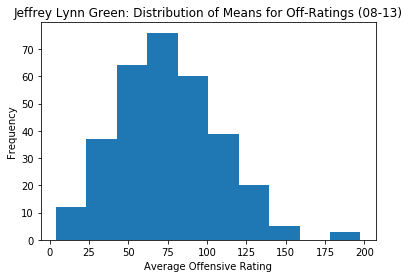

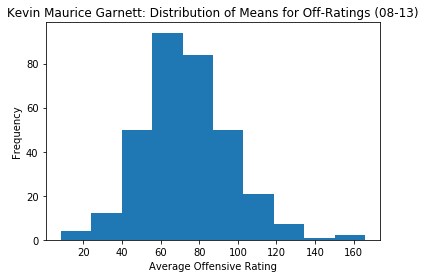

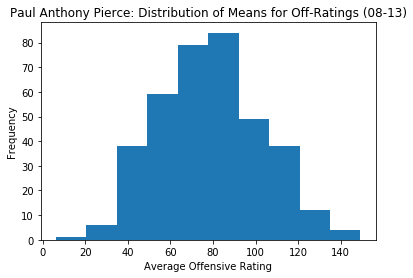

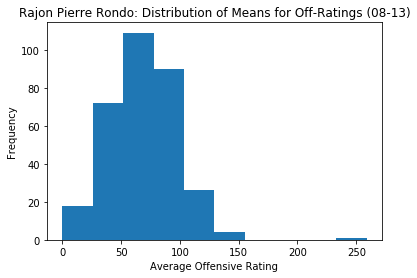

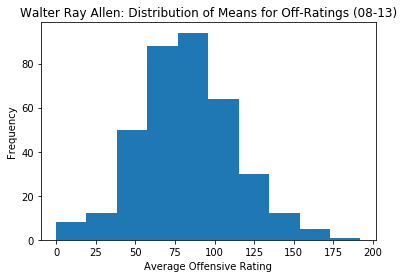

In [239]:
#testing group

"""
Function check_normal_prior() displays histograms for historical mean offensive ratings for players 
in a specific NBA team
"""
def check_normal_prior(team):
    #Examine to see if assuming an normal distribution as a prior for the mean is reasonable
    for name,means in historical_mean.items():
        
        #check out the Boston Celtics
        for player in starting_five[team]:
            if name==player:
                
                #a look at the histograms to reveal approx. bell-shaped distributions
                plt.hist(means,bins=10)
                plt.title('%s' % player + ': Distribution of Means for Off-Ratings (08-13)')
                plt.xlabel('Average Offensive Rating')
                plt.ylabel('Frequency')
                plt.figure()
    return 

#check out the Boston Celtics!
check_normal_prior('BOS')

#### Assuming a Normal for the Prior Distribution:
Looking at the histograms for players' historical mean offensive ratings, we notice they are bell-shaped and appear roughly normal. Thus, we will make a reasonable assumption that mean offensive rating is normally distributed. Therefore, the prior distribution for mean offensive rating $\mu$ is as follows: $\mu\sim{N(\alpha,\beta^2)}$ where the parameters $\alpha$ and $\beta$ are constants. We will model these parameters by using, again, the scipy.stats module.

In [131]:
"""
We assume that the bell-shaped distributions of historical offensive ratings
can be approximated by a normal distribution. We will again use a normal fit to find the prior parameters.

Function returns a dictionary with 3 columns: 
    player name, prior distribution mean, prior distribution std deviation
"""
#get the prior parameters for all players
def prior_parameters(dictionary):
    #new dictionary holds player name and their prior parameters
    dic={}
    dic['name']=[]
    dic['prior_mew']=[]
    dic['prior_sigma']=[]
    
    #iterate for each player
    for playername,means in dictionary.items():
        #get the prior parameters
        params=stats.norm.fit(means)
        #append parameters to the dictionary
        dic['name'].append(playername)
        dic['prior_mew'].append(params[0])
        dic['prior_sigma'].append(params[1])
    
    return dic

"""
The prior reprensents mew and sigma for a player's avererage rating. 
It encompasses games from 2009-2013 seasons
"""
prior=prior_parameters(historical_mean)
#turn into pandas dataframe
df_prior=pd.DataFrame(prior)
df_prior=df_prior.set_index('name')

### Bayesian Model: Using Likelihood to update the Prior and calculate a Posterior

We model Offensive Rating as $Offensive Rating\sim{N(\mu,\sigma^2)}$ where st deviation $\sigma$ is $known$, and $\mu\sim{N(\alpha,\beta^2)}$. Therefore, we have a Normal-Normal conjugate-prior where we can expect the posterior distribution for $\mu$ to also be normally distributed. 

The posterior distribution of $\mu$ is modeled as $f(\mu|x_i)\propto{f(x_i |\mu,\sigma)\cdot{\psi(\mu| \alpha,\beta)}}$, where $\psi$ is the prior distribution for $\mu$ and $f(x_i |\mu,\sigma)$ is the likelihood of mean offensive ratings to be updated. 

We will attribute $\mu_p$ and $\sigma_p$ as the mean and standard deviation estimates for the posterior normal distribution $\mu\sim{N(\mu_p,\sigma_p^2)}$. We find the values of these parameters from Professor Kevin P. Murphy's paper "Conjugate Bayesian Analysis of the Gaussian Distribution." 

$\mu_p = (\frac{\alpha}{\beta^2} + \frac{\sum_{i=1}^n{x_i}}{\sigma^2})\cdot{\frac{1}{(\frac{n}{\sigma^2}+\frac{1}{\beta^2})}}$

$\sigma_p = \frac{1}{(\frac{n}{\sigma^2}+\frac{1}{\beta^2})}$

Here, $\sum_{i=1}^n{x_i}$ represents the actual data we use to update the prior.


http://www.seas.harvard.edu/courses/cs281/papers/murphy-2007.pdf


In [132]:
"""
We are currently in the 2013-2014 basketball season and thus we have more data about each player's 
performance! Bayesian statistics tells us to use this new data to update our prior distribution about 
each players avg. offensive rating

First we grab the 2014 season player data and do necessary rating calculations.
"""
#grab 2014 player data, calculate each player's offensive rating
playerdata_j2=pd.read_csv('playerdata_2014.csv')
yr2014=df_with_rating(playerdata_j2)
#group by name for easier indexing
groupby2014=yr2014.groupby(['name','Date'])

In [133]:
"""
We assume that the variance of the rating distribution is known, 
and thus we have a normal-normal conjugate pair.

We calculate the posterior distribution for each player below:

Input arguments: 
    player frequentist std. deviation (assume this is known)
    prior distribution's std. deviation
    prior distribution's mean offensive rating
    updates (that player's new ratings from the 2014 season we should use to update

Return: that player's updated posterior hyperparamters, also disributed normal
"""
#calculate posterior hyperparameters based on formula above
def posterior_params(freq_sigma,prior_sigma,prior_mew,updates):
    #get rid of nans, so we find posterior only based on actual values
    likelihood=list()
    for update in updates:
        if np.isnan(update)==False:
            likelihood.append(update)
        
    #if there is no updated data, then posterior = prior
    if len(likelihood)==0:
        return prior_mew, prior_sigma 
    
    #2014 season gives us updated data i.e. new offensive ratings
    elif len(likelihood)>0:
        #calculate the posterior mean
        pos_mean_numerator=(prior_mew/(prior_sigma**2))+(sum(likelihood)/(freq_sigma**2))
        pos_mean_denominator=(1/(prior_sigma**2))+(len(likelihood)/(freq_sigma**2))
        pos_mean=pos_mean_numerator/pos_mean_denominator
        #calculate posterior sigma
        pos_sigma_numerator=1.
        pos_sigma_denominator=(1/(prior_sigma**2))+(len(likelihood)/(freq_sigma**2))
        pos_sigma=(pos_sigma_numerator/pos_sigma_denominator)**0.5
        
        return pos_mean,pos_sigma

We want to predict results of games in the month of December 2013-2014 season after updating the prior from the November results. 

In [134]:
"""
Function calcualtes the posterior hyperparameters from the proof above.

Inputs arguments:
    newseason_groupby is a pandas dictionary grouped by the players names
    months is a list of months (by strings i.e. November is str(11)) 
        of the data we are updating from 2014 season
Return:
    Dataframe with following information:
    -player name
    -player's team
    -frequentist distribution mean
    -frequentist distribution st deviation
    -prior distribution mean
    -prior distribution st deviation
    -posterior distribution mean
    -posterior distribution st deviation
"""
#get the posterior by updating prior from the 2014 season player data 
def get_posterior(newseason_groupby,months):
    #new dictionary holds the avg. off-rating from the month of November in the 2013-2014 season
    new_data={}
    
    #name is a tuple i.e. ('Kobe Bean Bryan',11) because the groupby = year2014.groupby(['name','Date'])
    for name,group in newseason_groupby:
        for month in months: #update based on each month the user wants to update
            if name[1]==month: #we are only looking at the month of November because our prior is monthly data 
                calc=list()
                #append offensive ratings but get rid of nans
                for rating in group['Rating']:
                    if np.isnan(rating)==False: 
                            calc.append(rating)
                if len(calc)>0:
                    #append average off-rating for that month
                    new_data.setdefault(name[0],[]).append(sum(calc)/len(calc))
                else:
                    new_data.setdefault(name[0],[]).append(float(nan))
                    
    #create new dictionary to hold posterior information
    posterior_dict={}
    
    #for every player in the 2014, use off_rating and df_prior to calculate the new posterior distribution for Off Ratings
    for name, newratings in new_data.items():
        if name not in off_rating.index:
            frequentist_mew = None
            frequentist_sigma = None
            prior_mew = None
            prior_sigma = None
        else:
            #extract frequentist mean and variance
            frequentist_mew=float(off_rating.loc[name,'mew'])
            frequentist_sigma=float(off_rating.loc[[name],'sigma'])

            #extract prior information
            prior_mew=float(df_prior.loc[[name],'prior_mew'])
            prior_sigma=float(df_prior.loc[[name],'prior_sigma'])

        #check to make sure frequentist_sigma is not NaN because it is included in posterior calculation
        if pd.isnull(frequentist_sigma)==False and frequentist_sigma!=0.:

            #obtain the new posterior mean and sigma
            posterior_mew,posterior_sigma=posterior_params(frequentist_sigma,prior_sigma,prior_mew,newratings)

            #add new info to the dictionary
            posterior_dict.setdefault('name',[]).append(name)
            posterior_dict.setdefault('frequentist_mew',[]).append(frequentist_mew)
            posterior_dict.setdefault('frequentist_sigma',[]).append(frequentist_sigma)
            posterior_dict.setdefault('prior_mew',[]).append(prior_mew)
            posterior_dict.setdefault('prior_sigma',[]).append(prior_sigma)
            posterior_dict.setdefault('posterior_mew',[]).append(posterior_mew)
            posterior_dict.setdefault('posterior_sigma',[]).append(posterior_sigma)
        else: 
            #posteriors will be nan if frequentist_sigma is also nan
            posterior_dict.setdefault('name',[]).append(name)
            posterior_dict.setdefault('frequentist_mew',[]).append(frequentist_mew)
            posterior_dict.setdefault('frequentist_sigma',[]).append(frequentist_sigma)
            posterior_dict.setdefault('prior_mew',[]).append(prior_mew)
            posterior_dict.setdefault('prior_sigma',[]).append(prior_sigma)
            posterior_dict.setdefault('posterior_mew',[]).append(float(nan))
            posterior_dict.setdefault('posterior_sigma',[]).append(float(nan))
            
    #lastly get the Team name per player
    d = { k : v for k,v in posterior_dict.items()}
    for key,listofnames in d.items():
        if key=='name':
            for player in listofnames:
                #recall: the groupby is grouped by ('name','Tm') as a tuple
                team=newseason_groupby.get_group(tuple((player,months[0])))['Tm'].values[0]
                posterior_dict.setdefault('Tm',[]).append(team)
    
    return pd.DataFrame(posterior_dict)

In [135]:
#only updating posterior based on November 2013 NBA results
months=['11'] 
#get the posterior dictionary with the function above, and convert to dataframe
posterior_df=get_posterior(groupby2014,months)
#group the df by team, so we can see players per team
posterior_groupby=posterior_df.groupby('Tm')
#posterior_groupby.get_group('NOP')

#### Simulation
Now, we will use the offensive rating distribution $Offensive Rating \sim{N(\mu,\sigma^2)}$ and the posterior Mean offensive rating distribution $\mu\sim{N(\mu_p,\sigma_p^2)}$ to simulate an NBA game between 2 teams. 

1) We will draw from each player's posterior distribution to get an estimated mean value $\mu$ for the offensive rating distribution. Then, we draw from that player's offensive rating distribution $Offensive Rating \sim{N(\mu,\sigma^2)}$ to find that player's predicted offensive rating. 

2) We will calculate an **Overall Team Rating**, which is the sum of the team's top 5 ratings (but dropping the highest and the lowest). Typically an NBA team has 5 starting players, so we use the top 5 ratings. However, we drop the highest and the lowest to diminish the effects of large outliers which may skew prediction results.

3) The team with the greater Overall Team Rating is predicted the winner of that game. After running $n$ matchups between the two teams, we count the number of wins per team and estimate the probability of that team defeating the other as $ProbabilityWinning=\frac{TotalPredictedWins}{n}$

In [136]:
"""
Input argument:
    group is a dictionary for 1 NBA team
Return:
    ratings for the team's players sorted in descending order
"""
def team_rating(group):
    ratings=list()
    players=list(group['name'])
    group=group.set_index('name')
    
    for person in players:
        pos_mew=float(group.loc[[person],'posterior_mew'])
        pos_sigma=float(group.loc[[person],'posterior_sigma'])
        
        #draw from posterior distribution to get the bayesian estimate of the mean off-rating
        bayesian_mew=np.random.normal(pos_mew,pos_sigma)
        
        #draw from distribution with known frequentist std. deviation
        freq_sigma=float(group.loc[[person],'frequentist_sigma'])
        
        if freq_sigma == 0.:
            final_rating = 0
        else:
            final_rating=np.random.normal(bayesian_mew,freq_sigma)
        
        #append the rating
        ratings.append(final_rating)
    #return a sorted list with highest ratings 1st
    return sorted(ratings, key=lambda x: 0 if np.isnan(x) else x,reverse=True) 
    
"""
Input argument:
    group is a groupby, which is grouped by 'Tm' (team) such as posterior_groupby
    team1: 3 char string of team name i.e. 'BOS'
    team2: 3 char string of team name i.e. 'ATL'
Return:
    the OVERALL RATING for team1 and team2
"""
def competition(groupby,team1,team2):
    team1_rating=list()
    team2_rating=list()
    
    #get team1 rating
    team1_df=groupby.get_group(team1)
    team1_rating=team_rating(team1_df)
    
    #get team2 rating
    team2_df=groupby.get_group(team2)
    team2_rating=team_rating(team2_df)
    
    #get overall team scores
    team1_score=np.mean(team1_rating[1:4])
    team2_score=np.mean(team2_rating[1:4])
    
    return team1_score,team2_score

"""
Now we will simulate a team playing another team.
Input arguments:
    n is the number of trials
    groupby: the groupbby we will use with posterior i.e. posterior_df
    team1: 3 char team string
    team2: "  "
Return:
    tuple with % chance team1 wins, %change team2 wins
"""
def simulation(n,groupby,team1,team2):
    team_one=0.
    team_two=0.
    for each_sim in range(0,n):
        score1,score2=competition(groupby,team1,team2)
        if score1>score2:
            team_one+=1.
        else:
            team_two+=1.
    return float(team_one/n),float(team_two/n) 

#### Checking the Model Predictions against Real NBA Results

We extract the actual outcomes of NBA games and compare the true outcomes to our predictions.

In [137]:
"""
function gets the df of actual game results for that month

Input argument:
    df is a results dataframe such as finalscore_2014.csv
    month is a 3 letter string for the month such as 'Nov'
"""
def get_actual_results(df,month):
    df['Date']=df['Date'].apply(lambda x: change_month(x))
    
    #group by the month of results
    gameresult=df.groupby('Date')
    return gameresult.get_group(month)

"""
We are only testing on games in the month of December because the posterior 
parameters are updated from November

function changes the string format for months
    Input: a string of format Mon, Dec 1, 2014 and the output is just Dec
"""
def change_month(string):
    new=string.split(', ')
    month=new[1]
    return month[0:3]

In [138]:
#load the results from the 2014 season
finalscore=pd.read_csv('finalscore_2014120813.csv')
#get NBA actual game results for the month of December
Dec_results=get_actual_results(finalscore,'Dec')

#### We run $n$ simulations for all games that have been played during December in the current 2013-2014 season and predict the outcomes.

We include our predicted probabilities of winning for each team as well as actual results: points scored for each team, difference in points scored, etc.

In [139]:
"""
Function simulates team1 vs. team2 basketball game

Input argument:
    resultdf is a results dataframe for actual game results i.e. Dec_results
    n is number of trials
    groupby is a groupby with posterior distribution parameters 
Returns:
    a dataframe with the following information for each game:
    -score difference
    -visitor team
    -visitor points
    -visitor probability winning
    -home team
    -home points
    -home probability winning
    -correctness: whether the model correctly or incorrectly predicted a win
"""
def sim_competition(resultdf,n,groupby):
    #create df with default integer index from 0:len(resultdf)
    resultdf=resultdf.reset_index(drop=True)
    
    #for every game played, create a tuple of the results (visitor team, visitor points, home team, home points)
    result=list()
    for index in range(len(resultdf)):
        #check if points is NaN. if false, then game has already been played
        if pd.isnull(resultdf.loc[[index],'PTS'].item())==False:
            visitor=list(resultdf.loc[[index],'Visitor/Neutral'])[0]
            v_pts=int(resultdf.loc[[index],'PTS'])
            home=list(resultdf.loc[[index],'Home/Neutral'])[0]
            h_pts=int(resultdf.loc[[index],'PTS.1'])
            tup=tuple((visitor,v_pts,home,h_pts))
            result.append(tup)
        else: #if isnan==True, then the game has not been played yet 
            continue
    
    #simulate using the bayesian model to compare prediction with actual result
    sim_result=list()
    for game in result:
        tup=0
        #game is format tuple(v_team, v_pts, h_team, h_pts)
        v_prob,h_prob=simulation(n,groupby,game[0],game[2])
        
        #correct prediction: visitor wins
        if v_prob>h_prob and game[1]>game[3]:
            tup=(game[1]-game[3],game[0],game[1],game[2],game[3],'correct',v_prob,h_prob)
        #correct prediction: home wins
        elif v_prob<h_prob and game[1]<game[3]:
            tup=(game[3]-game[1],game[0],game[1],game[2],game[3],'correct',v_prob,h_prob)
        
        #incorrect prediction: visitor wins
        elif v_prob<h_prob and game[1]>game[3]:
            tup=(game[3]-game[1],game[0],game[1],game[2],game[3],'incorrect',v_prob,h_prob)
        #incorrect prediction: home wins
        elif v_prob>h_prob and game[1]<game[3]:
            tup=(game[1]-game[3],game[0],game[1],game[2],game[3],'incorrect',v_prob,h_prob)
        elif v_prob==h_prob: #model predicts 50% change of either team winning
            tup=(game[1]-game[3],game[0],game[1],game[2],game[3],'tie',v_prob,h_prob)
        
        sim_result.append(tup)
   
        #create dictionary to organize results
    resultdic={}
    for result in sim_result:
        resultdic.setdefault('score difference', []).append(result[0])
        resultdic.setdefault('visitor', []).append(result[1])
        resultdic.setdefault('v_pts', []).append(result[2])
        resultdic.setdefault('home', []).append(result[3])
        resultdic.setdefault('h_pts', []).append(result[4])
        resultdic.setdefault('correctness', []).append(result[5])
        resultdic.setdefault('v_probability_win', []).append(result[6])
        resultdic.setdefault('h_probability_win', []).append(result[7])
    #turn to df
    resultdic=pd.DataFrame(resultdic)
    return resultdic

We determine the **accuracy** of the model *overall* in predicting games as well as in predicting *one possession* games and *blowout* games.

In [140]:
"""
Function: model_correctness() does exploratory analysis on the model's predictions
Input argument: 
    a simulation result dataframe such as sim_result above
    
Returns: 
    Percent of game outcomes the model predicts correctly
    Percent of 1 possession (within 3 pts) game outcomes the model predicts correctly
    Percent of blowout games (>= 10 pts) that the model predicts correctly 
"""
def model_correctness(simulation_result_dataframe):
    sim_gb=simulation_result_dataframe.groupby('correctness')
    
    #how accurate is the model in general in predicting game outcomes?
    correct=0.
    incorrect=0.
    for name, group in sim_gb:
        if name=='correct':
            correct=len(group)
        elif name=='incorrect':
            incorrect=len(group)

    correctness=100*float(correct)/(correct+incorrect)
    print ('Overall, the model correctly predicts: %.1f' %correctness + '%'+ ' of game outcomes.')
    
    #how accurate is the model specifically for 1 possession games (within 3 pts)?
    close_correct=0
    close_incorrect=0
    
    #prediction results for 1 possession games
    for name, group in sim_gb:
        if name=='correct':
            for score in list(group['score difference']):
                if abs(score)<=3:
                    close_correct+=1
        elif name=='incorrect':
            for score in list(group['score difference']):
                if abs(score)<=3:
                    close_incorrect+=1
    #percent of 1 possession games predicted correctly
    close_games=float(close_correct)/(close_correct+close_incorrect)*100                
    print ('For 1 possession games (within 3 pts), the model correctly predicts: %.1f' %close_games + '%')
    
    #how accurate is the model specifically for blowout games, score difference >= 10 pts?
    blowout_correct=0
    blowout_incorrect=0
    
    #prediction results for blowout games
    for name, group in sim_gb:
        if name=='correct':
            for score in list(group['score difference']):
                if abs(score)>=10:
                    blowout_correct+=1
        elif name=='incorrect':
            for score in list(group['score difference']):
                if abs(score)>=10:
                    blowout_incorrect+=1
    
    #percent of 1 possession games predicted correctly
    blowout_games=float(blowout_correct)/(blowout_correct+blowout_incorrect)*100                
    print ('For blowout games (score difference is at least 10 pts), the model correctly predicts: %.1f' %blowout_games+ '%')
    
    return 


We plot our predictions. The scatter plot reveals the difference in probability versus difference in actual scores. 

In an ideal scenario, for evaluation of **correct predictions** we should expact a positive linear trend. Games in which the model predicts a tiny difference in probability means that the model believes each team has around a 50% chance of winning. Thus, the score difference should be small (perhaps a very tight 1 possession game). Similarly, games in which the model predicts a huge difference in probability should result in a a large difference in scores. If the Golden State Warriors have a 80% chance of beating the Chicago bulls, the score difference should be big (blowout game). 

For evaluation for **incorrect predictions**, we should expect a negative trend. As the probability differences get larger, it means, for example, that the model says team A was supposed to beat team B by a longshot. However, team B upset team A in reality. If the model is accurate in predicting an upset, then team B would only beat team A by a few points (by no means blowing team A out of the water).

In [141]:
"""
Take a look at the 'Incorrect' predictions
Input argument: 
    a dataframe with the results of the simulation

Functions prints out each incorrect prediction's difference in probabilties and score differences
"""
def examine_incorrect(simulation_results):
    df=simulation_results.groupby('correctness').get_group('incorrect')
    prob_diff=list(abs(df['h_probability_win']-df['v_probability_win']))
    score_diff=list(abs(df['score difference']))
    
    #scatter plot to see relationship
    plt.scatter(prob_diff,score_diff)
    plt.xlabel('Difference in Estimated Win Percentage')
    plt.ylabel('Difference in Points Scored')
    plt.title('Evaluation of Incorrect Predictions')
    
    #linear fit
    fit=np.polyfit(prob_diff,score_diff,1)
    predicted=np.polyval(fit,prob_diff)
    plt.plot(prob_diff,predicted,'r-',linewidth=1)
    return

"""
Plot of Correct Predictions
"""
def examine_correct(simulation_results):
    df=simulation_results.groupby('correctness').get_group('correct')
    prob_diff=list(abs(df['h_probability_win']-df['v_probability_win']))
    score_diff=list(df['score difference'])
    
    #scatter plot to see relationship
    plt.scatter(prob_diff,score_diff)
    plt.xlabel('Difference in Estimated Win Percentage')
    plt.ylabel('Difference in Points Scored')
    plt.title('Evaluation of Correct Predictions')
    
    #linear fit
    fit=np.polyfit(prob_diff,score_diff,1)
    predicted=np.polyval(fit,prob_diff)
    plt.plot(prob_diff,predicted,'r-',linewidth=1)
    return

In [142]:
#get simulation results
#each game i.e. NYK vs. BOS will be simulated 50 times
sim_result=sim_competition(Dec_results,50,posterior_groupby)  

Overall, the model correctly predicts: 63.2% of game outcomes.
For 1 possession games (within 3 pts), the model correctly predicts: 62.5%
For blowout games (score difference is at least 10 pts), the model correctly predicts: 76.7%


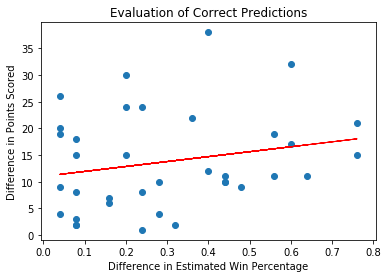

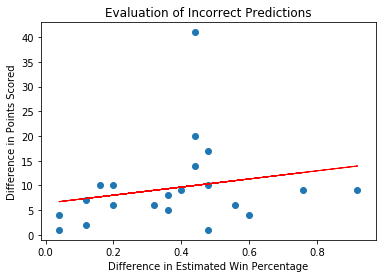

In [240]:
#check accuracy
model_correctness(sim_result)
examine_correct(sim_result)
plt.figure()
examine_incorrect(sim_result)

**Interpretion of Model Results and Scatter Plots Above**
We see that overall, the model correctly predicts about 52% of game outcomes accruately based on real results in December 2014 season. We also notice, however, *the model performs better when team score differences are larger than 10.* Interestingly, this discovery gives us useful insight. When one team is significantly better than the other, the model does a better job i.e. the players' metrics matter significantly. Thus, the model mispredicts most when **score differences are between 4-9 or within 3 (1 possession)**. Sports logic tells us that these games may just be ones in which one team may simply be playing with more confidence on that day or may have some luck on their side. The model, of course, does not take luck/confidence/experience into account. 

**Scatter Plots**
The Scatter Plots tell us the relationship between differences in score and estimated wins percentages. The hypothesis is that in an ideal world, there is a positive linear relationship (for evaluation of correctly predicted games) since Games predicted to have small differences in win percentages *should* have small score differences, and vice-versa. From the "Correct Prediction" plot, we do notice a positive linear relationship, which indicates the model does demonstrate this phenomena (thought there is certainly much error). A look at the "Incorrect Prediction plot" however indicates a slightly negative relationship, which we predicted above.

The model can surely be improved in the next few steps. 

## Building on the APBRmetrics Model: Accounting for Teamwork and Player Interaction by using "Assists"

We now will enhance the model by integrating teamwork and player interaction, rewarding players who help out their teammates to get the win. It is only natural that teams with great teamwork perform better in a game. We will model teamwork by using the Assists Metric. 

We will only model teamwork using 2014 season data because in the 2014 season, the team players are solidified (NBA players are notorious for traveling around and changing teams every season). We cannot model current teamwork using historical player data because players used to be on different teams. The current 2014 season provides teamwork data regarding that team ONLY. For example, LeBron James is currently playing for the Miami Heat. We cannot use his historical "Assists" data from years past because he used to play for the Cleveland Cavaliers. Those historical metrics are not representive of his teamwork skills on the Miami Heat's in the current 2014 season.

We use the Assists Metric because it is a reasonable proxy for teamwork. We will assume a player's 
teamwork performance, estimated by # of Assists, adds to that player's offensive rating. We do this by 
weighing the value of an assist. After hours of running the model continuously to find the optimal weight, we find a weight of 1.7 i.e. 1 assist is valued the same as 85% of a clean basket.

In [144]:
"""
Function df_rating_with_teamwork() is the same as df_with_rating() above, except we are just going to 
add the value gained from a player's "Assists."
"""
def df_rating_with_teamwork(dataframe,weight):
    
    df=dataframe.copy()
    
    #adjust for teamwork using assists metric
    df['PTS_Assists']=df['AST']*weight
    #calculate percent of total game time, adjust MP by dividing it by total minutes per game (48)
    df['MP']=df['MP'].apply(lambda x: tominutes(x)/48.)
    #adjust points by multiplying by percent of total game time
    df['Pts_adj']=df['MP']*(df['PTS']+df['PTS_Assists'])

    #calculate possessions
    df['Possessions']=0.96*(df['FGA']-df['ORB']+df['TOV']+0.44*df['FTA'])
    #check to make sure possessions can't be less than 1
    df['Possessions']=df['Possessions'].apply(lambda x: check_possession(x))
    
    #calculate a player's rating
    df['Rating']=100*df['Pts_adj']/df['Possessions']
    #change Date to monthly
    df['Date']=df['Date'].apply(lambda x: tomonth(x))
    return df

**We find the optimal weight to use for assists. The optimal weight is that which gives the highest percentage of correct game outcome predictions.** 

**Disclaimer: The following code take an extremely long time to run.**

In [145]:
#n is number of simulations

def find_assist_weight(weight,n):
    value=0.
    opt_weight=0.
    for x in weight:
        yr2014_team=df_rating_with_teamwork(playerdata,x)
        #group by name for easier indexing
        groupby2014_team=yr2014_team.groupby(['name','Date'])
        #only updating posterior based on November 2013 NBA results
        months=['11'] 
        #get the posterior dictionary with the function above, and convert to dataframe
        posterior_df_team=get_posterior(groupby2014_team,months)
        #group the df by team, so we can see players per team
        posterior_groupby_team=posterior_df_team.groupby('Tm')
        #run the simulation
        sim_result_team=sim_competition(Dec_results,n,posterior_groupby_team)
        
        sim_gb=sim_result_team.groupby('correctness')
        #how accurate is the model in general in predicting game outcomes?
        correct=0.
        incorrect=0.
        for name, group in sim_gb:
            if name=='correct':
                correct=len(group)
            elif name=='incorrect':
                incorrect=len(group)
        correctness=100*float(correct)/(correct+incorrect)
        #print 'Weight of %.2f' %x +' yields a correctness percentage of %.1f' %correctness
        if correctness>value:
            value=correctness
            opt_weight=x
    return opt_weight

# n=100
# #use proxy for teamwork
# weight=[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
# optimal_weight=find_assist_weight(weight,n)
# print 'The optimal weight for Assists is %.2f' %optimal_weight +'.'"""

In [146]:
#grab 2014 player data, calculate each player's offensive rating 
playerdata_j3=pd.read_csv('playerdata_2014.csv')

n=50
optimalweight=1.7

#calculate new offensive rating but adjusting for teamwork with assists
yr2014_team=df_rating_with_teamwork(playerdata_j3,optimalweight)

#group by name for easier indexing
groupby2014_team=yr2014_team.groupby(['name','Date'])
#only updating posterior based on November 2013 NBA results
months=['11'] 

#get the posterior dictionary with the function above, and convert to dataframe
posterior_df_team=get_posterior(groupby2014_team,months)

#group the df by team, so we can see players per team
posterior_groupby_team=posterior_df_team.groupby('Tm')

sim_result_team=sim_competition(Dec_results,n,posterior_groupby_team)

Overall, the model correctly predicts: 56.9% of game outcomes.
For 1 possession games (within 3 pts), the model correctly predicts: 50.0%
For blowout games (score difference is at least 10 pts), the model correctly predicts: 68.8%


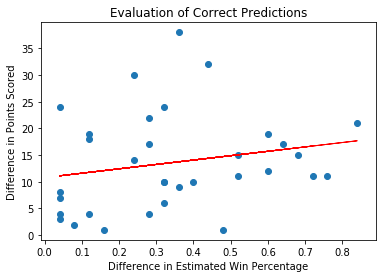

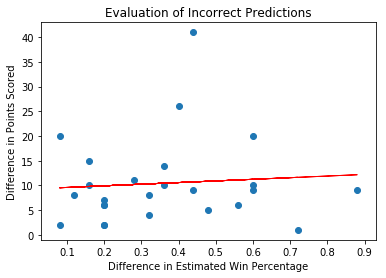

In [241]:
#check the model's correctness
model_correctness(sim_result_team)
examine_correct(sim_result_team)
plt.figure()
examine_incorrect(sim_result_team)

**Interpretion of Model Results**
We see that the model that accounts for teamwork using Assists is a slight improvement over the original offensive rating only model. Interestingly, we realize the model is quite good at prediciting blowout games, but quite poor at momentum/confidence games (score difference 4-9 pts) and 1 possession games that end up quite close. Again, perhaps this may be due to the model's inability to account for team history/experience against others or in cases where there is luck involved (1 possession games).

**Scatter Plots**
The scatter plots above are quite similar to the scatter plots in the offensive rating only model. However, we realize there is indeed much error, since we are definitely not seeing the ideal positive linear trend (for evaluation of correct predicitions): small differences in win percentages should result in small differences in points scored, and vice-versa. Therefore, there are still many factors the model is not accounting for. An explanation may be that the metric "Assists" is inherently flawed in measuring teamwork. Interactions between players involved much more than a metric, as it involves qualititative traits such as confidence, leadership, charisma, and experience that the model doesn't take into account. Furthermore, teamwork from different types of players are evaluated differently. For example, a Point Guard is supposed to be the go-to-man for setting up plays and making the passes. A team with an excellent Point Guard can be a team with great teamwork. But a team with an equally excellent Center would not perform as well (since a Center stays down low under the hoop and does not run plays).

## Further building on the Points-only model: Accounting for Offense, Teamwork, AND DEFENSE using John Hollinger's "Game Scores"

Basketball analyst John Hollinger uses the metric "Game Scores" to determine a player's entire performance. The Game Score metric accounts for offense, defense, and teamwork, calculated as: 

$GmSc = PTS+0.4(FG)-0.7(FGA)-0.4(FTA-FT)+0.7(ORB)+0.3(DRB)+STL$
$+0.7(AST)+0.7(BLK)-0.4(PF)-TOV$

Whereas the models above do not take into account a player's defense capabilities, the metric Game Score uses Defensive Rebounds (DRB) and Blocks (BLK) to estimate defense. Fortunately, the dataset gathered already includes the calculation for Game Score.

http://www.basketball-reference.com/about/glossary.html

In [148]:
"""
Bayesian Analysis using Game Scores: We list all the necessary functions (with alterations of previous) in order
to run the same Bayesian Analysis but using Game Scores.
"""
def df_with_gmsc(df):
    #because gamescore is a single statistic, we do not need to adjust for minutes played
    #gamescore already accounts for it
    df['Date']=df['Date'].apply(lambda x: tomonth(x))
    return df
"""
Getting the prior (similar to above hist_rating_mean(years))
Input argument: years is a list of ints i.e. years=[2009,2011,2012,...]
Returns:
    dictionary with 
    key: player name and value: list of mean monthly Game Scores from all seasons in years
"""
#gets the mean of player Game Scores per month across past years
def hist_gmsc_mean(years):
    #create the dictionary
    historical_player_mean={}
    
    #for all years, collect the means of player offensive ratings per month
    for yr in years:
        players_data = pd.read_csv('playerdata_' + '%s' % yr +'.csv')
        
        #get the gmsc from function above
        df=df_with_gmsc(players_data)
        #group by player name and Month 
        new_groupby=df.groupby(['name','Date'])
       
        #collect the means of player offensive ratings per month
        for name, group in new_groupby:
            calc=list()
            #get rid of nans and infs
            for score in group['GmSc']:
                if pd.isnull(score)==False:
                    calc.append(score)
            np.array(calc)
            
            #append the mean for that month to the player's name: ('Kobe Bean Bryan',12), we only want index 0
            if len(calc)>0:
                historical_player_mean.setdefault(name[0],[]).append(np.mean(calc))
    return historical_player_mean

"""
Function: get_posterior_gmsc(), which is similar to the above get_posterior()
We will calculate the posterior hyperparameters.
Inputs arguments:
    newseason_groupby is a pandas dictionary grouped by the players names
    months is a list of months (by strings i.e. November is str(11)) 
        of the data we are updating from 2014 season
Returns:
    same as get_posterior_gmsc() function
"""
#get the posterior by updating prior from the 2014 season player data 
def get_posterior_gmsc(newseason_groupby,months):
    
    #new dictionary holds the avg. off-rating from the month of November in the 2013-2014 season
    new_data={}
    #name is a tuple i.e. ('Kobe Bean Bryan',11) because the groupby = year2014.groupby(['name','Date'])
    
    for name,group in newseason_groupby:
        for month in months: #update based on each month the user wants to update
            if name[1]==month: #we are only looking at the month of November because our prior is monthly data 
                calc=list()
                #append offensive ratings but get rid of nans
                for rating in group['GmSc']:
                    if np.isnan(rating)==False: 
                            calc.append(rating)
                if len(calc)>0:
                    #append average off-rating for that month
                    new_data.setdefault(name[0],[]).append(sum(calc)/len(calc))
                else:
                    new_data.setdefault(name[0],[]).append(float(nan))
                    
    #create new dictionary to hold posterior information
    posterior_dict={}
    
    #for every player in the 2014 season, extract values from dataframes: off_rating and df_prior 
    #and calculate the new posterior distribution for Offensive Ratings
    for name, newratings in new_data.items():
        if name not in off_rating.index:
            frequentist_mew = None
            frequentist_sigma = None
            prior_mew = None
            prior_sigma = None
        else:
            #extract frequentist mean and variance
            frequentist_mew=float(gmsc.loc[[name],'mew'])
            frequentist_sigma=float(gmsc.loc[[name],'sigma'])

            #extract prior information
            prior_mew=float(df_prior_gmsc.loc[[name],'prior_mew'])
            prior_sigma=float(df_prior_gmsc.loc[[name],'prior_sigma'])
        
        #check to make sure frequentist_sigma is not NaN because it is included in posterior calculation
        if pd.isnull(frequentist_sigma)==False:
            #obtain the new posterior mean and sigma
            posterior_mew,posterior_sigma=posterior_params(frequentist_sigma,prior_sigma,prior_mew,newratings)
            
            #add new info to the dictionary
            posterior_dict.setdefault('name',[]).append(name)
            posterior_dict.setdefault('frequentist_mew',[]).append(frequentist_mew)
            posterior_dict.setdefault('frequentist_sigma',[]).append(frequentist_sigma)
            posterior_dict.setdefault('prior_mew',[]).append(prior_mew)
            posterior_dict.setdefault('prior_sigma',[]).append(prior_sigma)
            posterior_dict.setdefault('posterior_mew',[]).append(posterior_mew)
            posterior_dict.setdefault('posterior_sigma',[]).append(posterior_sigma)
        else: 
            #posteriors will be nan if frequentist_sigma is also nan
            posterior_dict.setdefault('name',[]).append(name)
            posterior_dict.setdefault('frequentist_mew',[]).append(frequentist_mew)
            posterior_dict.setdefault('frequentist_sigma',[]).append(frequentist_sigma)
            posterior_dict.setdefault('prior_mew',[]).append(prior_mew)
            posterior_dict.setdefault('prior_sigma',[]).append(prior_sigma)
            posterior_dict.setdefault('posterior_mew',[]).append(float(nan))
            posterior_dict.setdefault('posterior_sigma',[]).append(float(nan))
            
    #lastly get the Team name per player
    d = { k : v for k,v in posterior_dict.items()}
    for key,listofnames in d.items():
        if key=='name':
            for player in listofnames:
                #recall: the groupby is grouped by ('name','Tm') as a tuple
                team=newseason_groupby.get_group(tuple((player,months[0])))['Tm'].values[0]
                posterior_dict.setdefault('Tm',[]).append(team)
    
    return pd.DataFrame(posterior_dict)


#### The COMPLETE process for the same Bayesian Analysis as above but using John Hollinger's "Game Score" 


In [149]:
#looking at previous year's data (2013)
players_data_13 = pd.read_csv("playerdata_2013.csv")
#get df for 2013 season
df_gmsc=df_with_gmsc(players_data_13)
#group by player name
gb_gmsc=df_gmsc.groupby('name')
#create dataframe that includes player info: name, team, and params from fitted normal distribution 
gmsc=pd.DataFrame(player_info(gb_gmsc,'GmSc'))
#group the new dataframe by team name
gb2_gmsc=gmsc.groupby('Tm')
#sex index by player name to make for easier indexing
gmsc=gmsc.set_index('name')
"""
The prior represents mew and sigma for a players avererage gmsc. 
It encompasses games from 2008-2013 seasons
"""
#we will do this for the past 5 seasons
years=[2009,2010,2011,2012,2013]
historical_mean_gmsc=hist_gmsc_mean(years)
prior_gmsc=prior_parameters(historical_mean_gmsc)
#turn into pandas dataframe
df_prior_gmsc=pd.DataFrame(prior_gmsc)
df_prior_gmsc=df_prior_gmsc.set_index('name')

"""
Begin Bayesian analysis to update based on 2014 season data
First we grab the 2014 season player data and do necessary GmSc calculations.
"""
#grab 2014 player data, calculate each player's GmSc
playerdata_14=pd.read_csv('playerdata_2014.csv')
yr2014_gmsc=df_with_gmsc(playerdata_14)
#group by name for easier indexing
groupby2014_gmsc=yr2014_gmsc.groupby(['name','Date'])

"""
Getting the Posterior
"""
#only updating posterior based on November 2013 NBA results
months=['11'] 
#get the posterior dictionary with the function above, and convert to dataframe
posterior_df_gmsc=get_posterior_gmsc(groupby2014_gmsc,months)
#posterior_df_gmsc.to_csv('posterior_df_gmsc.csv')
#group the df by team, so we can see players per team
posterior_groupby_gmsc=posterior_df_gmsc.groupby('Tm')


In [150]:
"""
Bayesian Simulation using "Game Scores (GmSc)"
"""
n=50

sim_result_gmsc=sim_competition(Dec_results,n,posterior_groupby_gmsc)

Overall, the model correctly predicts: 62.7% of game outcomes.
For 1 possession games (within 3 pts), the model correctly predicts: 66.7%
For blowout games (score difference is at least 10 pts), the model correctly predicts: 71.0%


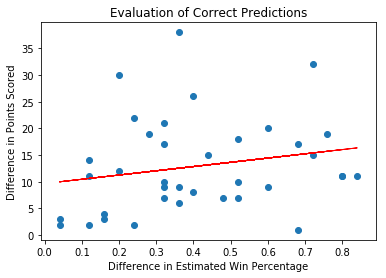

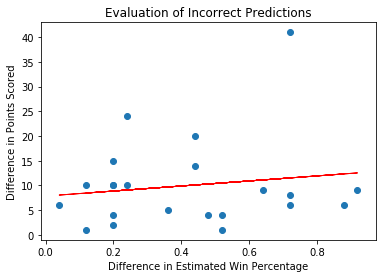

In [242]:
#examine accuracy
model_correctness(sim_result_gmsc)
examine_correct(sim_result_gmsc)
plt.figure()
examine_incorrect(sim_result_gmsc)

**Interpretion of Model Results and Scatter Plots Above**
Looking at the results of the Game Scores model, we see there is not a significant improvement to the offensive ratings model. We notice again, the model predicts blowout games more accurately than predictions overall, reinforcing the notion described above regarding the model's inability to account for qualitative factors such as a team's momentum, confidence the day of the game, quality of coach, etc.

**Scatter Plots** 
The Scatter Plots are again not improved, which may indicate too much error, possibly in the metric Game Score (GmSc). While GmSc contains metrics that attempt to capture offensive, defensive, and teamwork abilities of players, it may not accurately represent these qualities. Similar to the explanation above, different player positions (point guard, shooting guard, forward, center, etc.), there should also be different weights for different positions. Perhaps a shooting guard is more important to one team's strategy than a forward, etc. The scatter plots indicate that the model is somewhat guessing at the actual result, perhaps indicating the innate volatile nature of basketball, which comes down to a only a few baskets.

### Best Bayesian Model
All Bayesian Models appear to give very similar accuracies from 55-60% of predictions. However, it appears that the APBRmetrics Offensive Rating Model accounting for teamwork with Assists is the optimal model, since it provides a larger 1 possession and blowout game prediction accuracies than the Game Score Mode and significant improvement over the baseline Offensive Rating Model. 

### Parallel Coordinates Plots for NBA Divisions using Offensive Rating
We use a Frequentist setting to determine team rankings within Divisions based on overall team rating. We define overall team rating as the average of the top 5 Offensive Ratings per team. 

For every year 2009-2013, we will calculate the mean offensive rating for that player and then calculate team rating based on all players in that team.

In [152]:
"""
Function provides the input to the parallels coordinate plot below.
    Input argument: list of years to calculate ratings
    Returns:
        Dataframe with columns: team name and years i.e. 2013,2012,2011...
        columns under years include the team overall ratings numbers
"""
#gets the mean of player offensive ratings per month across past years
def parallel_coord_rating(years):
    #create the dictionary
    dic={}
    players_data = pd.read_csv('playerdata_2014.csv')
    gb_team=players_data.groupby('Tm')
    #append the team name based on 2014 season team names
    for team, group in gb_team:
        dic.setdefault(team,[]) 
              
    #for each player in each month, get the mean of offensive rating
    #go through all years in past few seasons and get the means
    for yr in years:
        players_data = pd.read_csv('playerdata_' + '%s' % yr +'.csv')
        #get the offensive ratings from function above
        df=df_with_rating(players_data)
        #group by team
        gb_team=df.groupby(['Tm'])
        
        for team, group in gb_team:
            calc=list()
            #group each team by its players' names
            gb_name=group.groupby('name')
            
            #for each player, get the mean offensive rating
            for name, group in gb_name:
                mean_player_rating=group['Rating'].mean() #calculate mean
                #check for nans
                if np.isnan(mean_player_rating)==False:
                    calc.append(mean_player_rating)     
            
            sorted(calc, reverse=True) #sort to descending
            team_rating=np.mean(calc[0:5])
            #append the team rating because teams have changed names
            if team=='PHO':
                dic['PHX'].append(team_rating)
            elif team=='NJN' or team=='BRK':
                dic['BKN'].append(team_rating)
            else:
                dic[team].append(team_rating)
                
    #create a new dictionary
    df_dic={}
    
    #make each year a key
    for yr in years:
        df_dic.setdefault('%s' %yr,[])
    
    #place every team name and rating from various years into the dictionary
    for team, values in dic.items():
        df_dic.setdefault('team',[]).append(team)
        #add the team's division in the NBA
        division=0
        
        for div, team_list in NBA_divisions.items():
            for each in team_list:
                if team==each:
                    #append the division
                    df_dic.setdefault('division',[]).append(div)
                    break
        
        #add team ratings per year
        for tuples in enumerate(years):
            #tuples[0] contains the index number
            #tuples[1] contains the year
            df_dic[str(tuples[1])].append(values[tuples[0]])
    
    #turn to dataframe
    df_dic=pd.DataFrame(df_dic)
    df_dic=df_dic.set_index('team',drop=True)
    return df_dic


In [153]:
year_list=[2013,2012,2011,2010,2009]
input_to_parallel=parallel_coord_rating(year_list)

Parallel Coordinates Plot for Team Ratings in the Atlantic Division


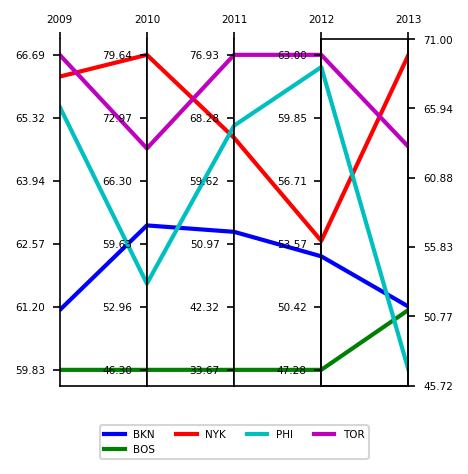

Parallel Coordinates Plot for Team Ratings in the Central Division


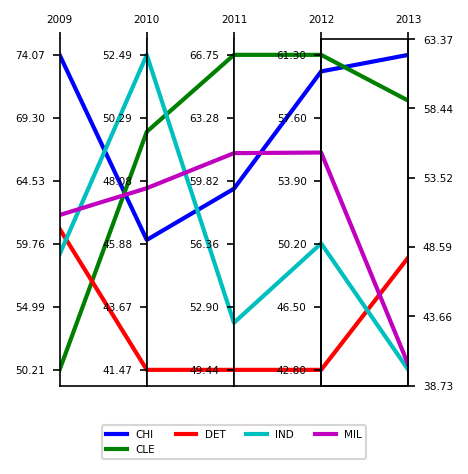

Parallel Coordinates Plot for Team Ratings in the NW Division


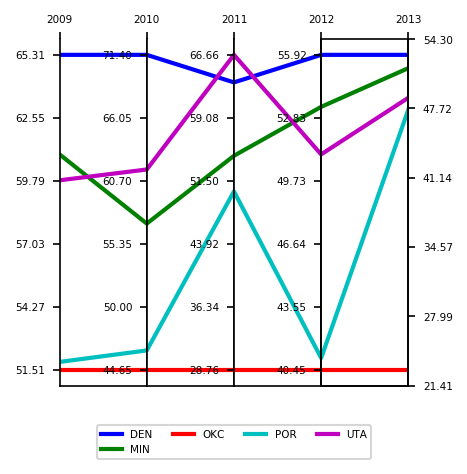

Parallel Coordinates Plot for Team Ratings in the Pacific Division


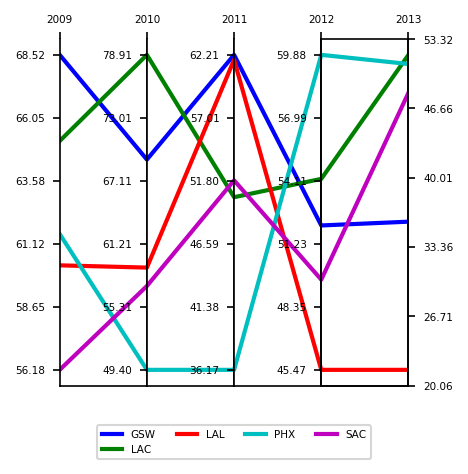

Parallel Coordinates Plot for Team Ratings in the SE Division


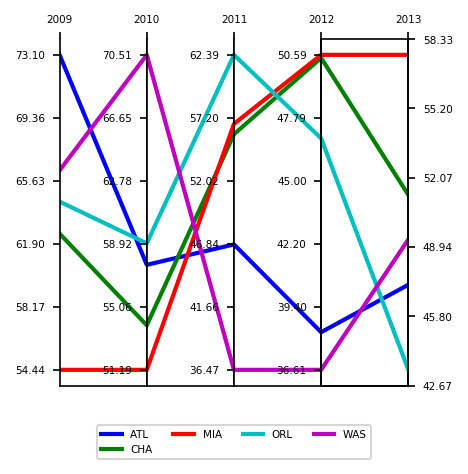

Parallel Coordinates Plot for Team Ratings in the SW Division


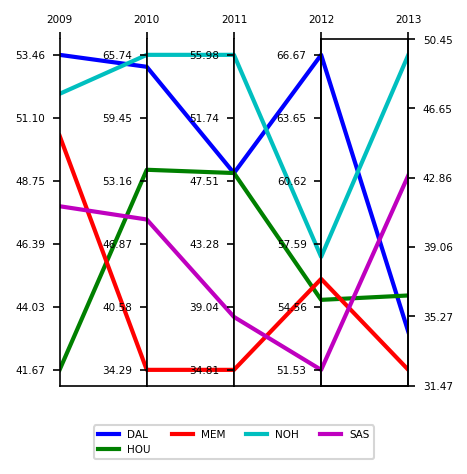

In [193]:
"""
For every division, we will make a parallel coordinates. 
"""
def plot_division(dataframe):
    parallel_gb=dataframe.groupby('division')
    
    for name, group in parallel_gb:
        df=group.copy()
        del df['division']
        print ('Parallel Coordinates Plot for Team Ratings in the %s ' %name +'Division')
        parallel_coordinates(df, 3, 5).show()
        plt.figure()
    return

plot_division(input_to_parallel)

# Building the Bracket

We have now created two models for predicting the outcomes of NBA games. While it is interesting to see the results of regular season games, most sports fans (us included) are interested in the playoffs. We thought it would be interesting to see what our models predict for the 2014 season playoffs, compare our two models against each other, and compare the results of both models to current NBA standings. 

In the NBA, which teams make is to the playoffs is determined by the seed, or ranking, of a team within its conferences. The NBA is split into two conferences, East and West. Within each conference, there are 3 divisions. In the East Conference, there are the Atlantic division, the Central division, and the Southeast division. In the West Conference, there are the Northwest division, the Pacific division, and the Southwest division. 

In each conference, the top 8 seeds will move on to the playoffs. The first 3 seeds are occupied by the teams with the most wins WITHIN each division. The team with the most number of wins among the divisional winners will be ranked 1st seed, followed by the divisional winner with the second-most wins and the divisional winner with the third-most wins. The remaining 5 seeds are given to the teams with the highest number of wins in the conference, irrespective of their division, in the order of their number of wins. Note here that within this ranking system, it is possible that a 4th seed team has more wins than a 2nd seed team if the 2nd seed team comes from an "easy" division while the 4th seed team comes from a "competitive" division and may have only just missed winning the division by 1 or 2 games. 

During the playoffs, the teams are matched against each other based on their seeds, and the winner is whichever team first reaches 4 wins. In the first round, Seed 1 plays Seed 8, 2 plays 7, 3 plays 6, and 4 plays 5. In the second round, the winner of 1 vs. 8 plays the winner of 4 vs. 5 and the winner of 2 vs. 7 plays the winner of 3 vs. 6. In the third round, the two remaining teams play against each other with the winner crowned the conference winner. In the final round, the conference winners play against each other for the NBA championship. 

Please find below an illustration of the NBA playoffs:



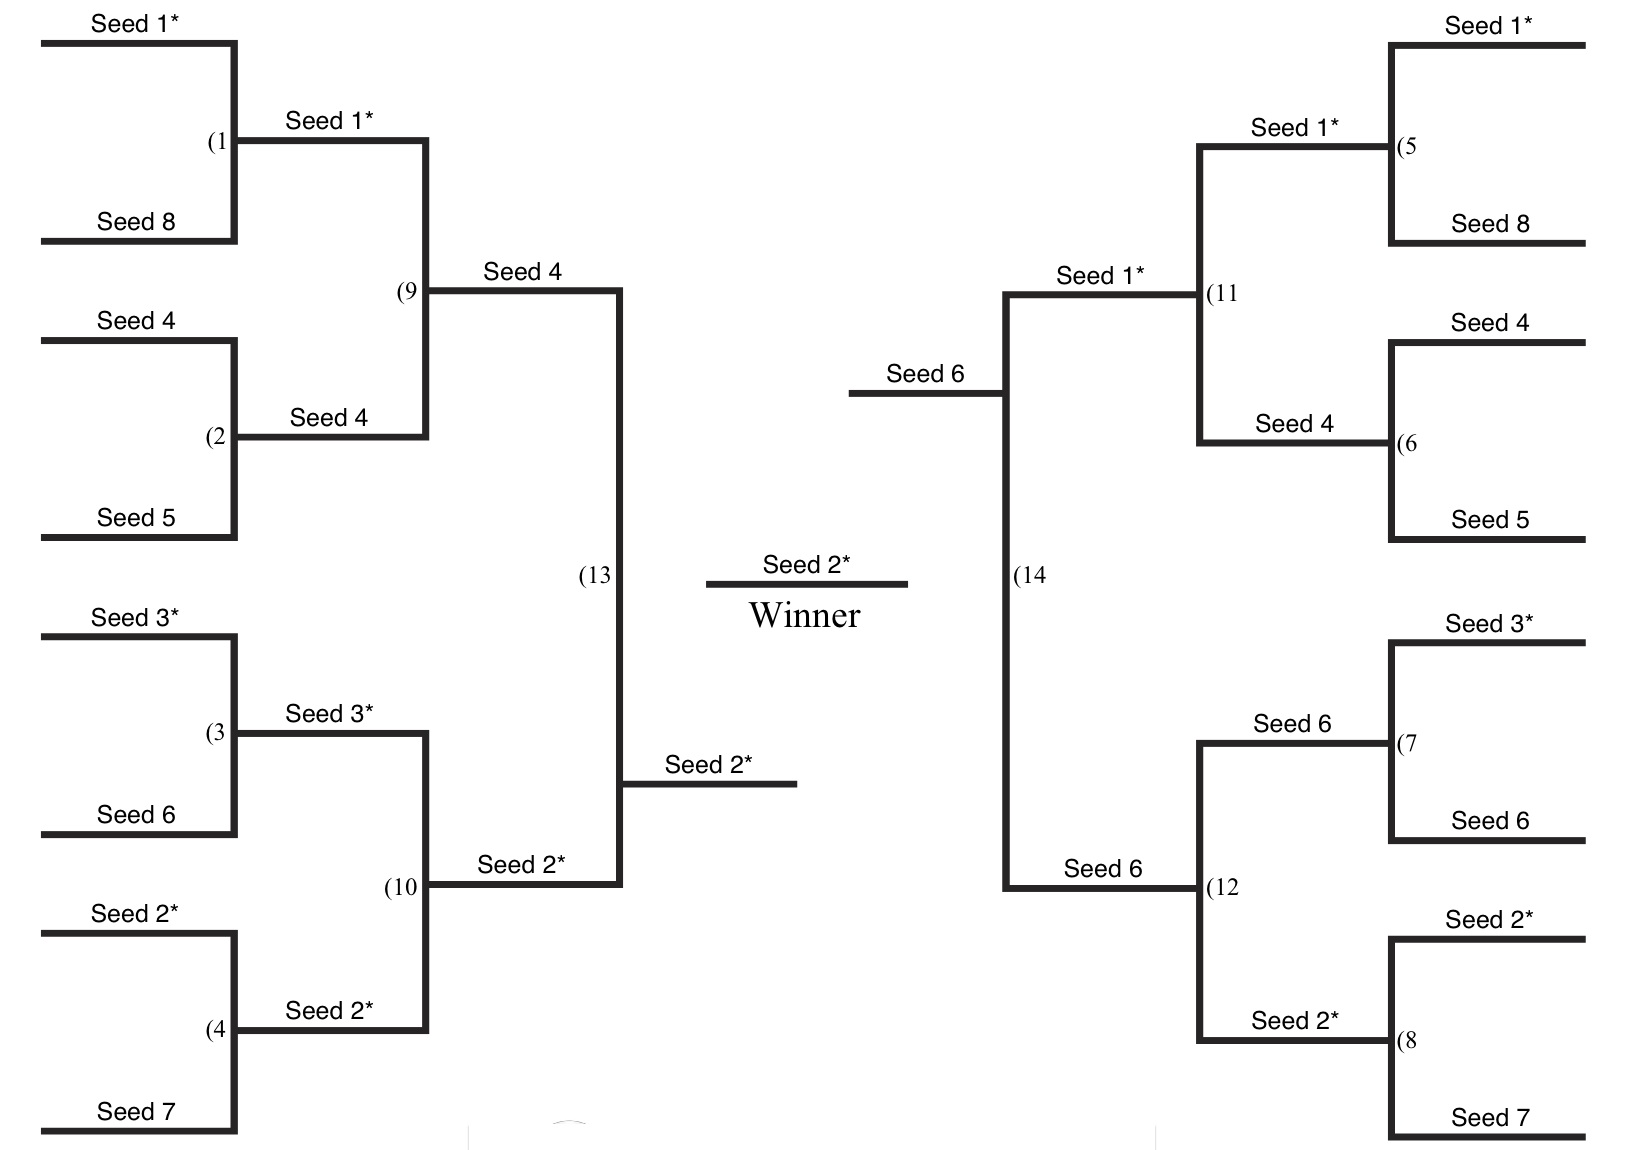

In [244]:
path = 'bracket_example.png'
Image(path, height = 700, width = 700)

## Simulating the playoffs

First, before we simulate the playoffs, we need to determine the probability that each team makes a seed. From the frequentist models, we will use the margin-adjusted boostrap model due to its high accuracy and low runtime. From the Bayesian models, we will use the Off Rating model adjusted for assists. 

Second, we will simulate the playoffs based on the predicted seeds to ultimately find the probability of the top teams winning the championship. First, we need to construct the brackets based on the seed probabilities. Then, we will take a frequentist approach to making the final predicition, as we will run the entire bracket simulation 1000 times, and look at the overall probability that each team makes it to a certain round in the playoffs. Finally, we will graph our output in Final Bracket Visualization.ipynb.


### Frequentist Model

First, we will build the seed and playoff simulation using the frequentist model.

In [196]:
'''create initial bracket
input: iterations, modeling function, parameters for the modeling function
output: DataFrame of teams with their probabilities of reaching that seed

Note: any modeling function will work as long as the output is like the following:
{"BOS":38, "DEN": 40...}
A dicitonary with the teams as the keys and the number of predicted wins as the value
'''

def build_seed(n, model, param):
    
    #create a DataFrame with team name as the index and each column representing a seed number
    temp = {x:[0,0,0,0,0,0,0,0] for x in NBA_teams}
    bracket_prob = pd.DataFrame([i for i in temp.values()],index=temp, columns=["1","2","3","4","5","6","7","8"])
    for x in range (0,n):
        
        #retrieve predictions
        result = model(*param)

        if len(result)==2:
            result = result[0]
        
        #find the seeds for each conference
        seeds = {}
        for conf, divisions in NBA_conferences.items():
            conf_team = {x: NBA_divisions[x] for x in divisions}
            top_seeds = []
            bottom_seeds = []
            
            #for each division in a conference, rank the teams based on their number of wins 
            for div, teams in conf_team.items():
                ranking_div = [list(x) for x in zip(teams, [result[x] for x in teams])]
                ranking_div.sort(key=lambda x: x[1], reverse=True)
                
                #grab the division winner
                top_seeds.append(ranking_div[0])
                #return the remaining teams in order of wins
                bottom_seeds.extend(ranking_div[1:4])
            
            #determine the seed rankings of the division winners
            top_seeds.sort(key=lambda tup: tup[1], reverse=True)
            #determine bottom seed rankings
            bottom_seeds.sort(key=lambda tup: tup[1], reverse=True)
            #append division seed rankings
            seeds.setdefault(conf, []).extend(top_seeds)
            seeds.setdefault(conf, []).extend(bottom_seeds[0:5])
    
        
        #track which teams got which seed
        for conf, teams in seeds.items():
            teams = np.array(teams)
            for i,team in enumerate(teams[:,0]):
                bracket_prob.loc[team,str(i+1)] +=1

    #calculate the probability that a team makes a given seed
    bracket_prob = bracket_prob.apply(lambda x: x/float(n))
    
    #add each team's conference
    bracket_prob["Conference"] = ""
    for x in bracket_prob.iterrows():
        if x[0] in NBA_conferencesT["East"]:
            bracket_prob.loc[x[0], "Conference"] = "East"
        else:
            bracket_prob.loc[x[0], "Conference"] = "West"
    
    return bracket_prob

In [197]:
#build a bracket for the frequentist model
predict_bracket =  build_seed(50, predict_results_boot, [schedule_2014, database_PTS2014, starting_fiveMP14, hist_margins_14, margin_adjust, "team1, team2, df"])

In [198]:
print(predict_bracket)

        1     2     3     4     5     6     7     8 Conference
ATL  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00       East
BKN  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00       East
BOS  0.00  0.00  0.00  0.92  0.04  0.00  0.04  0.00       East
CHA  0.00  0.00  0.00  0.00  0.02  0.20  0.16  0.26       East
CHI  0.00  0.32  0.24  0.02  0.32  0.04  0.04  0.02       East
CLE  0.00  0.10  0.26  0.04  0.34  0.14  0.08  0.02       East
DAL  0.00  0.00  0.04  0.00  0.02  0.04  0.08  0.16       West
DEN  0.00  0.00  0.00  0.02  0.00  0.02  0.16  0.34       West
DET  0.00  0.06  0.02  0.00  0.16  0.26  0.18  0.18       East
GSW  0.00  0.12  0.00  0.50  0.30  0.06  0.00  0.00       West
HOU  0.00  0.00  0.94  0.00  0.00  0.00  0.02  0.00       West
IND  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00       East
LAC  0.08  0.70  0.00  0.12  0.10  0.00  0.00  0.00       West
LAL  0.00  0.10  0.00  0.28  0.34  0.20  0.06  0.02       West
MEM  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00    

In [215]:

'''The following functions use the above generated predicted seeds in order
to make predictions on how far a team will make it in the ultimate NBA bracket.
First, we build a bracket for both the eastern and the western conferences.
The brackets are built with the following guidelines:
-   for each bracket spot (1-8), the team in the conference with the highest 
    probability of assuming that spot is given the spot
-   Once a team is seeded, it cannot be assigned to a lower spot in the bracket.
    Thus, we assign from the remaining unassigned teams to their spots in the bracket.'''

#retrieve probability built by predict_bracket
def get_prob(team, seed):
    return predict_bracket.loc[team][seed-1]

#find the teams with the max probabilities
def get_team_with_max_prob(teams, seed, seeded):
    values = {}
    for team in teams:
        if team not in seeded:
            values[team] = get_prob(team, seed)
    max_team = max(values.items(), key=operator.itemgetter(1))[0]
    return max_team

#build bracket
def build_bracket(region):
    conferences = predict_bracket.groupby('Conference').groups
    region_seeds = {}
    unseeded = set()
    seeded = set()
    
    # first form a bracket for conference based on the top seeded teams
    for team in conferences[region]:
        unseeded.add(team)
        seed_prob = predict_bracket.loc[team][:-1]
        max_prob = 0
        for i, prob in enumerate(seed_prob):
            if prob > max_prob:
                region_seeds[team] = i+1
                max_prob = prob
    
    #add teams to seeds
    region_bracket = defaultdict(list)
    for k, v in region_seeds.items():
        region_bracket[v].append(k)
    
    # ensure we have a team for each spot
    for i in range(1, 9):
        if not region_bracket[i]:
            region_bracket[i] = []
    
    for seed, teams in sorted(region_bracket.items()):
        #if only one team assigned to seed and not already in bracket
        highest_seed = None
        if len(teams) == 1 and teams[0] not in seeded:
            highest_seed = teams[0]
        #if no one or more than 1 team has been assigned to the ssed
        else:
            highest_seed = get_team_with_max_prob(list(unseeded), seed, seeded)
            if(len(teams)>1):
                for team in teams:
                    if (team != highest_seed):
                        unseeded.add(team)
        region_bracket[seed] = highest_seed
        unseeded.discard(highest_seed)
        seeded.add(highest_seed)
    return region_bracket

In [216]:
east_bracket = build_bracket("East")
west_bracket = build_bracket("West")
print (east_bracket)
print (west_bracket)

defaultdict(<class 'list'>, {4: 'BOS', 8: 'CHA', 2: 'WAS', 5: 'CHI', 6: 'DET', 7: 'TOR', 1: 'NYK', 3: 'CLE'})
defaultdict(<class 'list'>, {8: 'DEN', 4: 'GSW', 3: 'HOU', 2: 'LAC', 5: 'LAL', 6: 'OKC', 1: 'POR', 7: 'SAC'})


Once we have our western and eastern conference brackets built, we need to simulate the results of a bracket multiple times. To do this, our basic process is as follows:
- Using predict_bracket to predict the winner between two teams, we simulate all of the games in the bracket 100 times, starting with the first round and ending with the NBA finals. We record in a dictionary when a team makes it to a certain round.
- Like the NBA, two teams play a best of 7 series for each matchup.
- Once we have recorded the number of times each team makes it to each round, we divide this number by the total number of simulations, to find the probability that a team made it to a certain round in the tounament.

First, we will use the frequentist model to create the bracket and the playoff simulations


In [217]:
'''Generates predicted scores for 2 teams using the margin-adjusted bootstrap model
input: string for team1, string for team2, DataFrame of scores, starting lineup, DataFrame of historical margins
output: predicted score for team1, predicted score for team2
'''
def win_prediction(team1, team2, data, starting, margins):

    #run baseline score model
    team1_score = projected_score_boot(team1, data, starting)
    team2_score = projected_score_boot(team2, data, starting)
    
    #adjust with historical margins
    team1_score += margin_adjust(team1, team2, margins)
    
    return team1_score, team2_score

win_prediction("BOS", "NYK", database_PTS2014, starting_fiveMP14, hist_margins)

(59, 74)

In [218]:
'''Determines the winner of a matchup
input: array of two team names 
output: name of the winning team
'''
def get_winner(matchup):
    team1, team2 = matchup
    team1_wins = 0
    team2_wins = 0
    
    #simulate a 7 game matchup, find the first team to 4 games
    for i in range(7):
        score1, score2 = win_prediction(team1, team2, database_PTS2014, starting_fiveMP14, hist_margins)
        if score1 > score2:
            team1_wins += 1
        else:
            team2_wins +=1
        if team1_wins > 3 or team2_wins > 3:
            break
    if team1_wins > team2_wins:
        return team1
    else:
        return team2

'''Build final bracket uses the previously built inital brackets for both
the western and the eastern conferences, and builds 100 complete brackets. Thus, 
we record how often a team makes it to a certain round in the bracket, and by dividing 
this number by 100, we can find their probability of making it to a certain
round in the playoffs.'''
def build_final_bracket():
    final_bracket = defaultdict(dict)
    for team in west_bracket.values():
        final_bracket[team]['a'] = 0
        final_bracket[team]['b'] = 0
        final_bracket[team]['c'] = 0
        final_bracket[team]['d'] = 0
    for team in east_bracket.values():
        final_bracket[team]['a'] = 0
        final_bracket[team]['b'] = 0
        final_bracket[team]['c'] = 0
        final_bracket[team]['d'] = 0
    
    # we want to build 100 brackets, and see where each team makes it in each bracket
    total = 100
    for i in range(total):
        
        #keep track of the results of each round
        firstround_matchups = []
        semi_matchups = []
        firstround_winners = []
        semifinal_winners = []
        conf_winners = []
        finals_winners = []
        
        #first round match up
        for j in range(1, 5):
            firstround_matchups.append((west_bracket[j], west_bracket[9 - j]))
        for matchup in firstround_matchups:
            winner = get_winner(matchup)
            firstround_winners.append(winner)
            final_bracket[winner]['a'] += 1
        
        #second round match up
        for k in range(0, 2):
            semi_matchups.append((firstround_winners[k], firstround_winners[3-k]))
        for matchup in semi_matchups:
            winner = get_winner(matchup)
            semifinal_winners.append(winner)
            final_bracket[winner]['b'] += 1
        
        #final round matchups, determine winner of west conference
        conf_matchup = (semifinal_winners[0], semifinal_winners[1])
        west_winner = get_winner(conf_matchup)
        final_bracket[west_winner]['c'] += 1
        
        #repeat process for east conference
        firstround_matchups = []
        semi_matchups = []
        firstround_winners = []
        semifinal_winners = []
        conf_winners = []
        finals_winners = []
        
        for j in range(1, 5):
            firstround_matchups.append((east_bracket[j], east_bracket[9 - j]))
        for matchup in firstround_matchups:
            winner = get_winner(matchup)
            firstround_winners.append(winner)
            final_bracket[winner]['a'] += 1
        
        for k in range(0, 2):
            semi_matchups.append((firstround_winners[k], firstround_winners[3-k]))
        for matchup in semi_matchups:
            winner = get_winner(matchup)
            semifinal_winners.append(winner)
            final_bracket[winner]['b'] += 1
        
        conf_matchup = (semifinal_winners[0], semifinal_winners[1])
        east_winner = get_winner(conf_matchup)
        final_bracket[east_winner]['c'] += 1
        final_winner = get_winner((west_winner, east_winner))
        final_bracket[final_winner]['d'] += 1
    
    # after collecting the results of 100 iterations, divide each number
    # by 100 to get the final probability of making it to a certain round.
    for team in west_bracket.values():
        final_bracket[team]['a'] = final_bracket[team]['a'] / float(total)
        final_bracket[team]['b'] = final_bracket[team]['b'] / float(total)
        final_bracket[team]['c'] = final_bracket[team]['c'] / float(total)
        final_bracket[team]['d'] = final_bracket[team]['d'] / float(total)
        final_bracket[team]['team'] = 'West'
    for team in east_bracket.values():
        final_bracket[team]['a'] = final_bracket[team]['a'] / float(total)
        final_bracket[team]['b'] = final_bracket[team]['b'] / float(total)
        final_bracket[team]['c'] = final_bracket[team]['c'] / float(total)
        final_bracket[team]['d'] = final_bracket[team]['d'] / float(total)
        final_bracket[team]['team'] = 'East'
    
    df = pd.DataFrame(final_bracket).T
    return df
        
df = build_final_bracket()
df.to_csv('final_bracket1.csv')
df.head(15) 

,a,b,c,d,team
BOS,0.63,0.03,0.03,0.01,East
CHA,0.01,0.01,0,0,East
CHI,0.37,0,0,0,East
CLE,0.67,0.29,0,0,East
DEN,0.01,0,0,0,West
DET,0.33,0.11,0,0,East
GSW,0.47,0.14,0.08,0,West
HOU,0.49,0.18,0.05,0,West
LAC,0.86,0.7,0.31,0.09,West
LAL,0.53,0.12,0.05,0.01,West


In [219]:
"""
Creating Bracket: Because we are using a Bayesian model that is updated with November outcomes,
we will only model games that have not been played yet i.e. those in December onward.
This does mean that each team will play around 20 less games, but trying to model Oct and Nov data would obscure the true
accuracy of our model

Function predict_bayes_result:
    Input argument: a groupby with posterior, frequentist, and prior parameters
        i.e. posterior_groupby above
    Returns:
        a dictionary with Team name as Key and # predicted wins as value
"""
def predict_bayes_result(groupby):
    teams = NBA_teams
    result = dict.fromkeys(teams, 0)
    
    #select the correct scores 
    for index, row in finalscore.iterrows():   
        if row['Date']!= 'Oct' and row['Date']!='Nov':
            t1,t2 = competition(groupby,row['Visitor/Neutral'],row['Home/Neutral'])
            if t1>t2:
                result[row["Visitor/Neutral"]] += 1
            elif t1<t2:
                result[row["Home/Neutral"]] +=1
    
    return result

In [220]:
#create the bracket for the Bayesian model
predict_bracket=  build_seed(50, predict_bayes_result, [posterior_groupby_team])

In [221]:
#redefine get_winner for the Bayesian code
def get_winner(matchup):
    team1, team2 = matchup
    team1_wins = 0
    team2_wins = 0
    for i in range(7):
        score1, score2 = competition(posterior_groupby, team1, team2)
        if score1 > score2:
            team1_wins += 1
        else:
            team2_wins +=1
        if team1_wins > 3 or team2_wins > 3:
            break
    if team1_wins > team2_wins:
        return team1
    else:
        return team2
    
df2 = build_final_bracket()
df2.to_csv('final_bracket2.csv')
df2.head(15)

,a,b,c,d,team
BOS,0.46,0.09,0.01,0,East
CHA,0.13,0.07,0.02,0,East
CHI,0.54,0.06,0.01,0,East
CLE,0.42,0.06,0,0,East
DEN,0.5,0.36,0.08,0.01,West
DET,0.58,0.12,0.02,0,East
GSW,0.61,0.25,0.02,0,West
HOU,0.73,0.46,0.36,0.12,West
LAC,0.79,0.42,0.38,0.1,West
LAL,0.39,0.08,0.01,0,West


Below are screenshots of our final Bokeh visualizations. Because of some complications with Bokeh, we were forced to place the code in a different iPython notebook. For the code for the final visualizations of our brackets, please see Final Bracket Visualization.ipynb.

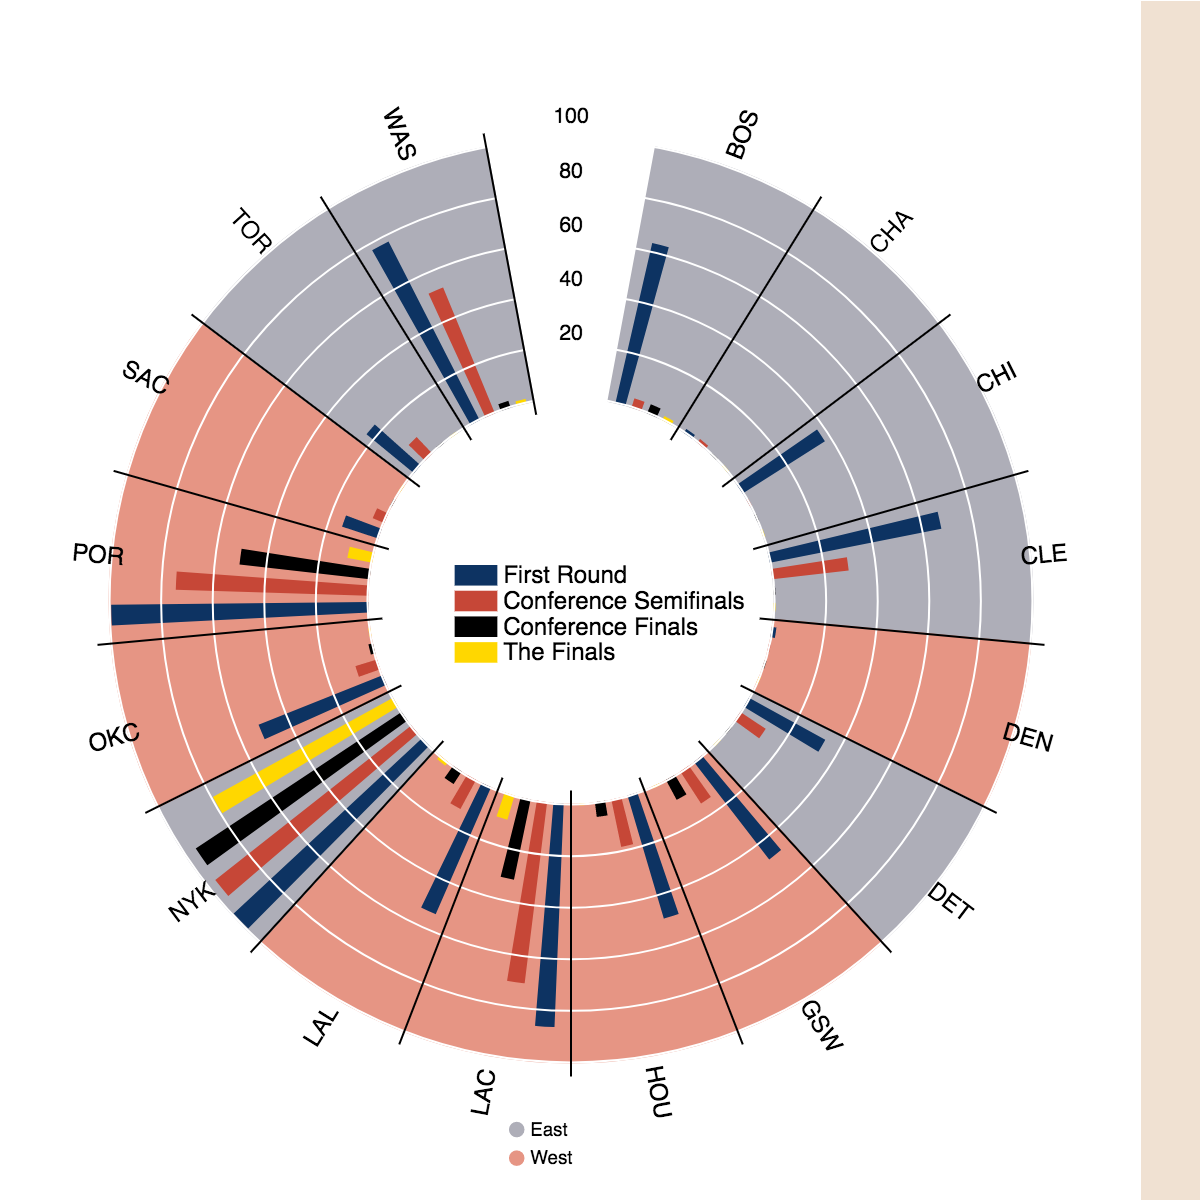

In [223]:
# Visualization of our results f the final NBA playoffs with the frequentist model
path = 'bokeh_freq.png'
Image(path, height = 500, width = 500)

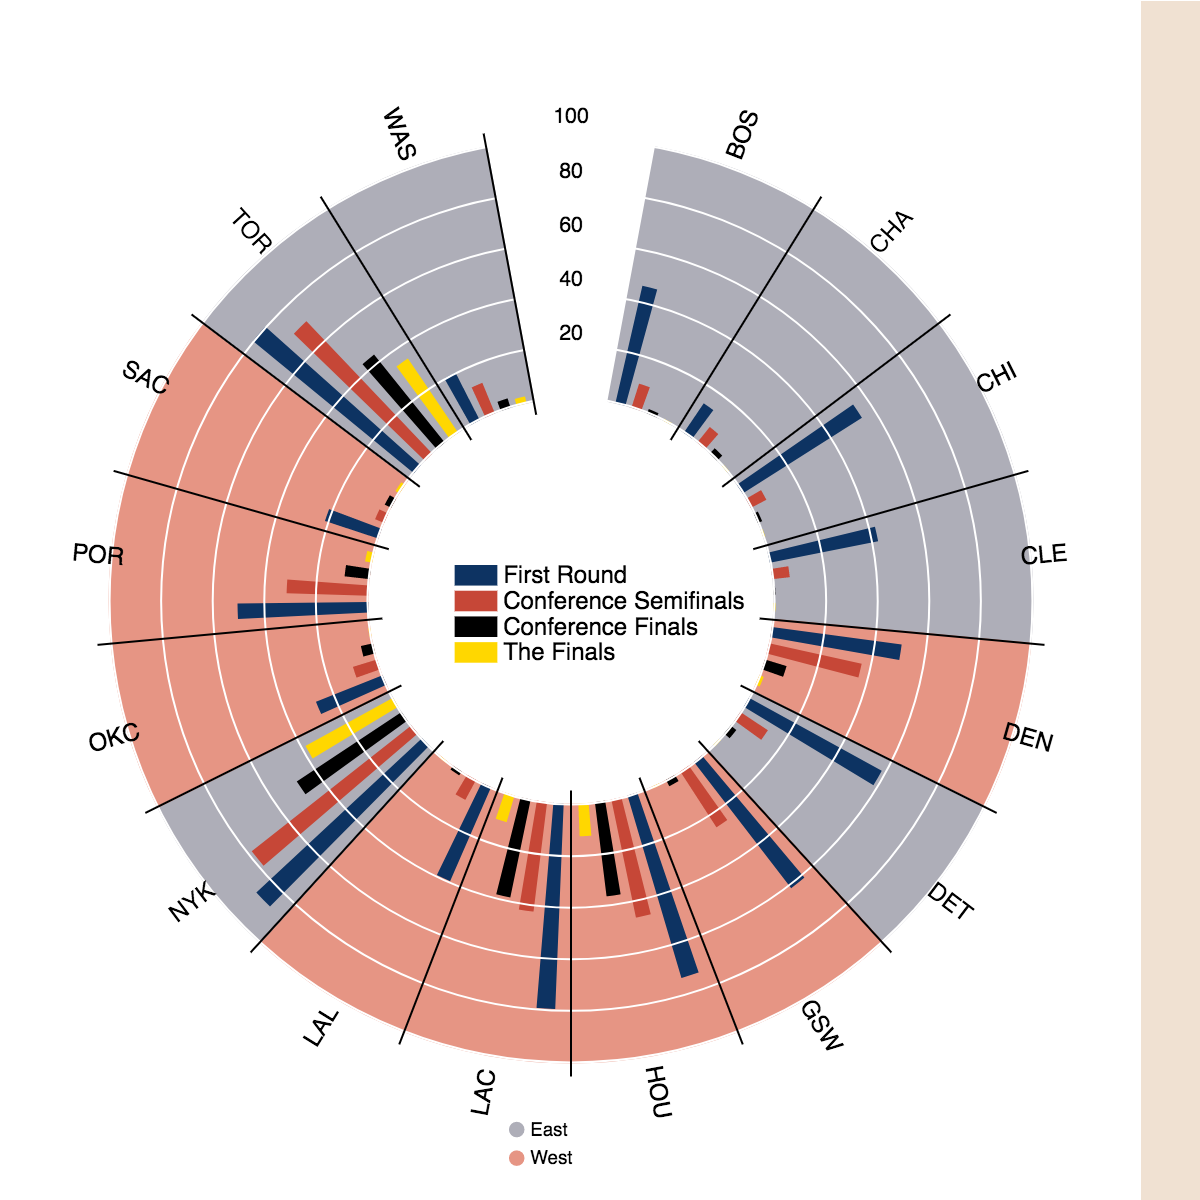

In [224]:
# Visualization of our results f the final NBA playoffs with the bayesian model
path = 'bokeh_baye.png'
Image(path, height = 500, width = 500)

### Analysis
One of the original driving goals of the project was to predict the probability of each team winning the NBA championship. Instead of returning the single most likely team to win the championship, we wanted to determine and visually show the probability of different teams making it to a certain level in the playoffs. Using the bracket simulation method (as described above) and our models for predicting the outcomes of games, we simulated a large number of possible brackets. According to this frequentist approach, the New York Knicks are highly predicted to win the NBA championship (around 79% probability). While the Knick’s aren’t exactly playing well this season, they played very well in the last few seasons (with Linsanity and Carmelo’s high scoring antics), which resulted in their prowess in our predictions. 

We used both a Frequentist model and a Bayesian model to create the brackets and simulate playoff. Both models predicted a high probability for the New York Knicks to win the NBA championship. Both models also predict the Los Angeles Clippers to win the championship. The Bayesian approach also assigns modest probabilities to the Toronto Raptors and Houston Rockets. Based on the caliber of their veteran players and in the way that they were matched up in the playoffs, these teams have a good chance of making it to the end, but not as high as a team like the New York Knicks.


<br>
# Conclusion and Remarks

In modeling our data, we started with a very basic predictive model that was based off of the historical scores between two teams. By sampling many times from the scoring results of a historical set of games, we made predictions on the results of games between two specified teams. In comparing this model with the true results of games in the 2012-2013 season, we found that this baseline frequentist model, based on game scores, was able to predict the outcomes of games with around 65% accuracy. In the 2013-2014, we found that the accuracy of the model fell to around 55%. However, the 2013-2014 season is still young, and the actual results of the season may be skewed with many outliers. As the season progresses, we hypothesize that our predictions will become more accurate, as there will be more games to compare our results to.

After creating the baseline model that looked at historical scores between teams, we wanted to create a more nuanced approach to predicting the outcome of games. We began by introducing historical margins (looking at the record between two teams), assists, turnovers, and rebounds to the model in order to make it more accurate. We found that after introducing historical margins, the accuracy of the model rose to around 67%, and after additionally including the assists, turnovers, and rebounds, the accuracy again rose to 68%. However, we noticed that introducing this more nuanced approach only resulted in marginal gains in the accuracy of the overall model. In our simulations, examining the historical scores between two teams created a relatively strong baseline that was only marginally improved by our more nuanced analysis.

One criticism of this model is that it treats every historical scoring outcome with equal weight. To improve it, it might be more accurate if the model is able to rate more recent games more heavily, since more recent game outcomes should more accurately reflect future play. Another area for future investigation is whether more historical data actually hinders the accuracy of the model as players’ skills fluctuate from year to year; perhaps we should have just sampled from last year’s data or from trailing 20 games. 

Building off the Points-only model, we decided to add in additional explanatory variables to better account for a team’s true offensive capabilities. The Association for Professional Basketball Reseach metrics (APBRmetrics) models a team’s performance based on an offensive rating that incorporates key variables: points, turnovers, offensive rebounds, field goals, and free throw attempts. We decided to build off the Frequentist approach by using Bayesian Analysis with the complete process detailed above. The resulting model achieves an overall prediction accuracy for December 2014 season games of around 52%. A look at the scatter plot and regression line above indicates that the model is still not very accurate, as predictions are almost like a coin-flip. 

We then decided to enhance the model by accounting for teamwork using the “Assists” metric, believing that a player’s teamwork skills can be estimated by how many assists he has during a game. We found that the “Offensive Rating with Assists” model does marginally better than the original Offensive Rating only model, but only by about 5-6% in overall game prediction accuracy. We then decided to attempt to improve the model again by account for defense.

Finally, we decided to use the Game Score (GmSc) metric that includes proxies for a player’s offensive, defensive, and teamwork skills. Game Score contains 12 key variables: points, field goals, field goal attempts, free throw attempts, free throw, offensive rebounds, defensive rebounds, steals, assists, blocks, personal fouls, and turnovers. We used the same Bayesian model as above and again found that the Game Score model was only marginally better than the Offensive Rating only model. The Game Score model predicted about 59% of Dec. 2014 season games accurately. 

There are two key takeaway from the Bayesian Analysis.

1. Although all models (each more technical and building off the other) had similar game prediction accuracies 52-58%, they all tended to do better when predicting blowout games (score difference greater than 10), described in more detail above. This reveals that the model does well when predicting game outcomes when one team’s metrics are significantly better than another (a blowout game). 
2. The model does more poorly for games with score differences between 4-9. These games tend to be ones in which teams are similar in ability but one may just be having a better day than the other i.e. luck that the model can’t account for. 

Areas for improvement: 

1. Determining how many year/seasons to go back in building data for a prior is quite important . Perhaps it doesn’t make sense to go back 5 seasons, since players’ offensive capabilities have grown more consistent over the years. However, we thought 5 seasons would be a reasonable start and given more time, we could have explored different sets of data for the prior that would give us the most accurate predictions. 
2. Modeling teamwork is very tricky, and the metric “Assists” may not do teamwork enough justice. Teamwork involves team chemistry, charisma, and experience that appears on the court but likely not in the metrics. The innate nature of an assist (calculated as a pass that leads to a basket) is flawed because in basketball, it is quite common for players to “swing” the ball multiple times until a teammate finds an open shot, which should definitely be considered a teamwork skill. The same argument goes for a player’s ability to make accurate and consistent passes to teammates.
3. Modeling history of team performance could perhaps enhance results. The bayesian model do not take into account a team playing another team for the second time during a season. It was difficult to account for since players switch around team very often. However, the frequentist model did take into account team historical performance against other teams, and the improvements were marginal if not insignificant.


In sum, a big picture view of the frequentist and bayesian models reveal that there is no dramatic improvement of the model’s prediction accuracy by use more metrics. The Bayesian approach, involving complicated metrics such as Offensive Rating and Game Score do not do much better than a standard Points-only model, although one would expect that metrics accounting for teamwork and defensive capabilities would increase prediction accuracy. Furthermore, there may be multicollinearity in the model because metrics are dependent i.e. a player with high points probably also has high number of assists, offensive rebounds, field goals, etc. Thus, the models demonstrate that metrics can only do so much in predicting games. From a points-only model to a 12 metric model (Game Scores), the prediction accuracy is still only around 55-65%. 

The team came to realize that unlike other team sports such as football and baseball, basketball is an extraordinarily volatile sport where a majority of games come down to only a few baskets. Furthermore, there is NO other sport in which one player can just go OFF...Unlike any other team sport, an NBA player can have an amazing day one game, taking the ENTIRE team to a win single-handedly and a poor day another. More so than in other sports, basketball has a big luck component and other key variables that are difficult to model. Metrics just cannot account for important key variables such as coaching ability, injuries, confidence, experience, and when a player simply “feels it” (for ex: knocking down ten 3-pointers in a row). Based on the natural volatility of basketball, the team though the models were in-line with expectations. The model could surely do better than a coin flip, but not by much due to the important qualitative factors of basketball we are not able to address. Therefore, a model with about 60% accuracy should be considered reasonably good from a quantitative-only perspective. 
